In [1]:
import numpy as np
import scipy
import time

from openfermion import expectation, variance
from openfermion.hamiltonians import MolecularData
from openfermion.ops import FermionOperator
from openfermion.transforms import jordan_wigner, bravyi_kitaev, bravyi_kitaev_fast, bravyi_kitaev_tree
from openfermion.transforms._conversion import get_sparse_operator
from openfermion.utils import count_qubits, _unitary_cc
from openfermion.utils._sparse_tools import jw_hartree_fock_state, jordan_wigner_sparse

from openfermioncirq.trotter.simulate_trotter import simulate_trotter
from openfermioncirq.variational.hamiltonian_objective import HamiltonianObjective

from openfermionpyscf import run_pyscf

from scipy.optimize import minimize

from pyscf import gto

In [82]:
def generate_h2_geometry(atomic_separation):
    return [['H', [0, 0, 0]], 
            ['H', [0, 0, atomic_separation]]]

def generate_heh_geometry(atomic_separation):
    return [['He', [0, 0, 0]], 
            ['H', [0, 0, atomic_separation]]]

def generate_lih_geometry(atomic_separation):
    return [['Li', [0, 0, 0]], 
            ['H', [0, 0, atomic_separation]]]

def generate_li2_geometry(atomic_separation):
    return [['Li', [0, 0, 0]], 
            ['Li', [0, 0, atomic_separation]]]

def generate_h2o_geometry(atomic_separation):
    mol_h2o = gto.M()

    mol_h2o.atom = """H
                O 1 {atomic_separation}
                H 2 0.958 1 104.45
                """.format(atomic_separation=atomic_separation)
    mol_h2o.basis = "sto-3g"
    mol_h2o.build()
    
    h2o_geometry = [[mol_h2o.atom_pure_symbol(atom_idx), list(mol_h2o.atom_coords()[atom_idx])]
                        for atom_idx in range(mol_h2o.natm)]

    return(h2o_geometry)

h2_specification = {"geometry_fn": generate_h2_geometry,
                    "basis": "sto-3g",
#                     "basis": "6-31g*",
                    "multiplicity": 1,
                    "charge": 0}

heh_specification = {"geometry_fn": generate_heh_geometry,
                     "basis": "sto-3g",
                     "multiplicity": 1,
                     "charge": 1}

lih_specification = {"geometry_fn": generate_lih_geometry,
                     "basis": "sto-3g",
                     "multiplicity": 1,
                     "charge": 0}

h2o_specification = {"geometry_fn": generate_h2o_geometry,
                     "basis": "sto-3g",
                     "multiplicity": 1,
                     "charge": 0}

li2_specification = {"geometry_fn": generate_li2_geometry,
                     "basis": "sto-3g",
                     "multiplicity": 1,
                     "charge": 0}

# geometry = [['C', [0, 0, 0]], 
#             ['H', [0.6276, 0.6276, 0.6276]],
#             ['H', [0.6276, -0.6276, -0.6276]],
#             ['H', [-0.6276, 0.6276, -0.6276]],
#             ['H', [-0.6276, -0.6276, 0.6276]]]

# basis = 'sto-3g'
# charge = 0
# multiplicity = 1

In [3]:
def MolecularData_from_specification(molecule_specification, atomic_separation):
    return MolecularData(molecule_specification["geometry_fn"](atomic_separation),
                         molecule_specification["basis"],
                         molecule_specification["multiplicity"],
                         molecule_specification["charge"])

In [4]:
# molecule = MolecularData(generate_h2_geometry(0.741),
#                          basis,
#                          multiplicity,
#                          charge)

# hamiltonian_interaction_op = molecule.get_molecular_hamiltonian()
# num_qubits = hamiltonian_interaction_op.n_qubits
# print("Number of qubits:", num_qubits)

# num_electrons = molecule.n_electrons
# print("Number of electrons:", num_electrons)

In [5]:
def prepare_hamiltonian_matrix(molecule):
    t = time.time()
    run_pyscf(molecule, run_scf=True)

    hamiltonian_interaction_op = molecule.get_molecular_hamiltonian()
    
    hamiltonian_fermion_op = FermionOperator()
    for term in hamiltonian_interaction_op:
        hamiltonian_fermion_op += FermionOperator(term, hamiltonian_interaction_op[term])
        
    jw_hamiltonian_qubit_op = jordan_wigner(hamiltonian_fermion_op)

    hamiltonian_matrix = get_sparse_operator(jw_hamiltonian_qubit_op)
    
    print("time to generate hamiltonian:", time.time()-t)
    return hamiltonian_matrix

In [6]:
# Generalized Singles and Doubles Unitary Coupled Cluster
def uccgsd_ansatz_preparation(flattened_params, reference_state):
    num_qubits = int(np.log2(reference_state.shape[0]))
    one_body_params = flattened_params[:num_qubits**2]
    two_body_params = flattened_params[num_qubits**2:]
    
    one_body_params = one_body_params.view()
    one_body_params.shape = (num_qubits, num_qubits)
    
    two_body_params = two_body_params.view()
    two_body_params.shape = (num_qubits, num_qubits, num_qubits, num_qubits)

    uccgsd_fermion_op = _unitary_cc.uccsd_generator(one_body_params, two_body_params)
    uccgsd_sparse = jordan_wigner_sparse(uccgsd_fermion_op, num_qubits)
    uccgsd_state = scipy.sparse.linalg.expm_multiply(uccgsd_sparse, reference_state)
    return uccgsd_state


In [7]:
# Singlet Singles and Doubles Unitary Coupled Cluster for use defined relative to a reference
# state with M orbitals and N electrons
def singlet_uccsd_ansatz_preparation(packed_params, reference_state, num_qubits, num_electrons):
    uccgsd_fermion_op = _unitary_cc.uccsd_singlet_generator(packed_params, num_qubits, num_electrons)
    uccgsd_sparse = jordan_wigner_sparse(uccgsd_fermion_op, num_qubits)
    uccgsd_state = scipy.sparse.linalg.expm_multiply(uccgsd_sparse, reference_state)
    return uccgsd_state


In [8]:
# All code for generating singlet k-UpCCSD
# Roughly following OpenFermion style

import itertools
from openfermion.ops import up_index, down_index

def singlet_k_upccsd_paramsize(k, n_qubits, n_electrons):
#     if n_qubits % 2 != 0:
#         raise ValueError("The total number of spin orbitals should be even")

    n_spatial = n_qubits // 2
    n_occupied = int(np.ceil(n_electrons / 2))
    n_virtual = n_spatial - n_occupied
    
    n_single_amplitudes = n_occupied * n_virtual
    n_double_amplitudes = n_occupied * n_virtual
    
    return k * (n_single_amplitudes + n_double_amplitudes)

# single unitary pair coupled cluster
# Has the same number of singles excitation parameters as singlet UCCSD
# Sparser doubles excitations, as it excites an alpha-beta pair from an occupied
# orbital to an unoccupied orbital
def singlet_k_upccsd_ansatz_preparation(packed_params, k, reference_state, n_qubits, n_electrons, anti_hermitian=True):
    n_spatial = n_qubits // 2
    n_occupied = int(np.ceil(n_electrons / 2))
    n_virtual = n_spatial - n_occupied
    
    n_single_amplitudes = n_occupied * n_virtual
    n_double_amplitudes = n_occupied * n_virtual
    
    n_amplitudes = n_single_amplitudes + n_double_amplitudes
    
    singlet_k_upccsd_state = reference_state
    
    for iter_idx in range(k):
        generator = FermionOperator()
        k_iter_params_offset = iter_idx * n_amplitudes
        params_idx = 0
        for virt_idx, occ_idx in itertools.product(range(n_virtual), range(n_occupied)):
            virt_spatial = virt_idx + n_occupied
            virt_up = up_index(virt_spatial)
            virt_down = down_index(virt_spatial)
            occ_up = up_index(occ_idx)
            occ_down = down_index(occ_idx)

            # Singlet singles excitations
            generator += FermionOperator(((virt_up, 1), (occ_up, 0)), 
                                         packed_params[k_iter_params_offset + params_idx])

            if anti_hermitian:
                generator += FermionOperator(((occ_up, 1), (virt_up, 0)), 
                                             -packed_params[k_iter_params_offset + params_idx])

            # Singlet doubles excitations
            generator += FermionOperator(((virt_up, 1), (occ_up, 0), 
                                         (virt_down, 1), (occ_down, 0)), 
                                         packed_params[k_iter_params_offset + params_idx + n_single_amplitudes])

            if anti_hermitian:
                generator += FermionOperator(((occ_up, 1), (virt_up, 0), 
                                             (occ_down, 1), (virt_down, 0)), 
                                             -packed_params[k_iter_params_offset + params_idx + n_single_amplitudes])

            params_idx += 1
        
        singlet_k_upccsd_sparse = jordan_wigner_sparse(generator, n_qubits)
        singlet_k_upccsd_state = scipy.sparse.linalg.expm_multiply(singlet_k_upccsd_sparse, singlet_k_upccsd_state)
    
#     num_terms = 0
#     for term in generator:
#         num_terms += 1
#     print("terms per iteration k:", num_terms)
    
    return singlet_k_upccsd_state

# num_qubits = 14
# num_electrons = 10
# hf_state = jw_hartree_fock_state(num_electrons, num_qubits)
# k = 2
# params = np.random.rand(k * singlet_k_upccsd_paramsize(num_qubits, num_electrons))
# t = time.time()
# singlet_k_upccsd_ansatz_preparation(k, params, hf_state, num_qubits, num_electrons)
# print(time.time() - t)

In [9]:
# All code for generating k-UpCCGSD -- WORK IN PROGRESS
# Roughly following OpenFermion style

# import itertools
# from openfermion.ops import up_index, down_index

# def k_upccgsd_paramsize(k, n_qubits, n_electrons):
# #     if n_qubits % 2 != 0:
# #         raise ValueError("The total number of spin orbitals should be even")

#     n_spatial = n_qubits // 2
#     n_occupied = int(np.ceil(n_electrons / 2))
#     n_virtual = n_spatial - n_occupied
    
#     n_single_amplitudes = n_spatial**2
#     n_double_amplitudes = n_occupied * n_virtual
    
#     return k * (n_single_amplitudes + n_double_amplitudes)

# single unitary pair coupled cluster
# Has the same number of singles excitation parameters as generalized UCCSD
# Generalized pair doubles excitations, parameterizes excitations and deexcitations
# for all possible pair exchanges
# def k_upccgsd_ansatz_preparation(packed_params, k, reference_state, n_qubits, n_electrons, anti_hermitian=True):
#     n_spatial = n_qubits // 2
#     n_occupied = int(np.ceil(n_electrons / 2))
#     n_virtual = n_spatial - n_occupied
    
#     n_single_amplitudes = n_spatial**2
#     n_double_amplitudes = n_occupied * n_virtual
    
#     n_amplitudes = n_single_amplitudes + n_double_amplitudes
    
#     k_upccgsd_state = reference_state
    
#     for iter_idx in range(k):    
#         generator = FermionOperator()
#         k_iter_params_offset = iter_idx * n_amplitudes
        
#         # Generalized singles excitations        
#         params_idx = 0
#         for create_idx, annihilate_idx in itertools.product(range(n_spatial), range(n_spatial)):
#             create_up = up_index(create_idx)
#             create_down = down_index(create_idx)
#             annihilate_up = up_index(annihilate_idx)
#             annihilate_down = down_index(annihilate_idx)
            
#             generator += FermionOperator(((create_up, 1), (annihilate_up, 0)), 
#                                          packed_params[k_iter_params_offset + params_idx])
            
#             generator += FermionOperator(((create_down, 1), (annihilate_down, 0)), 
#                                          packed_params[k_iter_params_offset + params_idx])

#             if anti_hermitian:
#                 generator += FermionOperator(((create_up, 1), (annihilate_up, 0)), 
#                                              -packed_params[k_iter_params_offset + params_idx])
                
#                 generator += FermionOperator(((create_down, 1), (annihilate_down, 0)), 
#                                              -packed_params[k_iter_params_offset + params_idx])
        
#             params_idx += 1
        
#         # Generalized doubles excitations
#         params_idx = 0
#         for virt_idx, occ_idx in itertools.product(range(n_spatial), range(n_spatial)):
#             create_up = up_index(create_idx)
#             create_down = down_index(create_idx)
#             annihilate_up = up_index(annihilate_idx)
#             annihilate_down = down_index(annihilate_idx)

#             generator += FermionOperator(((create_up, 1), (annihilate_up, 0), 
#                                          (create_down, 1), (annihilate_down, 0)), 
#                                          packed_params[k_iter_params_offset + params_idx + n_single_amplitudes])

#             if anti_hermitian:
#                 generator += FermionOperator(((occ_up, 1), (virt_up, 0), 
#                                              (occ_down, 1), (virt_down, 0)), 
#                                              -packed_params[k_iter_params_offset + params_idx + n_single_amplitudes])
#             params_idx += 1
            
#         k_upccgsd_sparse = jordan_wigner_sparse(generator, n_qubits)
#         k_upccgsd_state = scipy.sparse.linalg.expm_multiply(singlet_k_upccsd_sparse, k_upccgsd_state)

#     num_terms = 0
#     for term in generator:
#         num_terms += 1
#     print("terms per iteration k:", num_terms)
    
#     return k_upccgsd_state

# num_qubits = 14
# num_electrons = 10
# hf_state = jw_hartree_fock_state(num_electrons, num_qubits)
# k = 2
# params = np.random.rand(k * singlet_k_upccsd_paramsize(num_qubits, num_electrons))
# t = time.time()
# k_upccgsd_ansatz_preparation(k, params, hf_state, num_qubits, num_electrons)
# print(time.time() - t)

In [10]:
def eval_ansatz_energy(ansatz_state, hamiltonian_matrix):
#     t = time.time()
    expected_uccsd_energy = expectation(hamiltonian_matrix, ansatz_state)
    return expected_uccsd_energy


In [11]:
def eval_ansatz_variance(ansatz_state, hamiltonian_matrix):
#     t = time.time()
    expected_variance = variance(hamiltonian_matrix, ansatz_state)
    return expected_variance


In [12]:
def eval_energy(ansatz_parameters, hamiltonian_matrix, reference_state):
    t = time.time()
    ansatz = uccgsd_ansatz_preparation(ansatz_parameters, reference_state)
    print("time to generate ansatz:", time.time()-t)
    t = time.time()
    expected_energy = eval_ansatz_energy(ansatz, hamiltonian_matrix)
    return expected_energy.real


In [13]:
def singlet_eval_energy(ansatz_parameters, hamiltonian_matrix, reference_state, num_qubits, num_electrons):
    t = time.time()
    ansatz = singlet_uccsd_ansatz_preparation(ansatz_parameters, reference_state, num_qubits, num_electrons)
    print("time to generate ansatz:", time.time()-t)
    t = time.time()
    expected_energy = eval_ansatz_energy(ansatz, hamiltonian_matrix)

    return expected_energy.real


In [14]:
def singlet_k_upccsd_eval_energy(ansatz_parameters, k, hamiltonian_matrix, reference_state, num_qubits, num_electrons):
    t = time.time()
    ansatz = singlet_k_upccsd_ansatz_preparation(ansatz_parameters, k, reference_state, num_qubits, num_electrons)
    print("time to generate ansatz:", time.time()-t)
    expected_energy = eval_ansatz_energy(ansatz, hamiltonian_matrix)

    return expected_energy.real

In [15]:
def singlet_eval_variance(ansatz_parameters, hamiltonian_matrix, reference_state, num_qubits, num_electrons):
    ansatz = singlet_uccsd_ansatz_preparation(ansatz_parameters, reference_state, num_qubits, num_electrons)
    expected_variance = eval_ansatz_variance(ansatz, hamiltonian_matrix)
    return expected_variance

In [71]:
def multiple_repetitions(start, stop, num_steps, num_repetitions):
    separations = []
    energies_dict = {}
    for i in range(num_repetitions):
        energies_dict[i] = []
    energies = []

    step = 1
    for atomic_separation in np.linspace(start=start,
                                         stop=stop,
                                         num=num_steps,
                                         endpoint=True):
        print("Working on step", step, "for d =", atomic_separation)
        t = time.time()
        molecule = MolecularData(generate_h2_geometry(atomic_separation),
                                 basis,
                                 multiplicity,
                                 charge)

        hamiltonian_matrix = prepare_hamiltonian_matrix(molecule)

        energy = 0

        for rep in range(num_repetitions):
            print("\tWorking on repetition", rep)
            rep_timer = time.time()
            
            optimize_result = minimize(fun=eval_energy,
                                       x0=flat_packed_params,
                                       args=(hamiltonian_matrix, hf_state),
                                       method="L-BFGS-B")
           
            print("\tRepetition", rep, "completed in", time.time()-rep_timer)

            energies_dict[rep].append(optimize_result.fun)
            energy += optimize_result.fun


        energy /= num_repetitions

        separations.append(atomic_separation)
        energies.append(energy)

        print("Step", step,
              "complete for d =", atomic_separation,
              "with energy", energy, "hartree.",
              "Time elapsed:", time.time()-t)
        
        step += 1
    
    return separations, energies, energies_dict


In [87]:
def single_repetition_with_variance(molecule_specification,
                                    reference_state,
#                                     ansatz_generating_function,
                                    ansatz_params_initial_guess,
                                    min_bond_length,
                                    max_bond_length,
                                    num_steps,
                                    optimization_method=None,
                                    k=None):
    separation = []
    observable = []
    observable_variance = []

    step = 1
    
    molecule = MolecularData_from_specification(molecule_specification, atomic_separation=1)
    
    for atomic_separation in np.linspace(start=min_bond_length,
                                         stop=max_bond_length,
                                         num=num_steps,
                                         endpoint=True):
        print("Working on step", step, "for d =", atomic_separation)
        separation.append(atomic_separation)
        
        t = time.time()
        
        molecule = MolecularData_from_specification(molecule_specification, atomic_separation)
        
        # Populate 1 and 2 body integrals
        run_pyscf(molecule, run_scf=True)

        hamiltonian_matrix = prepare_hamiltonian_matrix(molecule)

        optimize_result = minimize(fun=eval_energy,
                                   x0=flat_params,
                                   args=(hamiltonian_matrix, reference_state),
                                   method=optimization_method,
                                   options={"disp": False})
        
#         optimize_result = minimize(fun=singlet_eval_energy,
#                                    x0=flat_params,
#                                    args=(hamiltonian_matrix, hf_state, num_qubits, num_electrons),
#                                    method=optimization_method,
#                                    options={"disp": False})

#         optimize_result = minimize(fun=singlet_k_upccsd_eval_energy,
#                                    x0=flat_params,
#                                    args=(k, hamiltonian_matrix, hf_state, num_qubits, num_electrons),
#                                    method=optimization_method,
#                                    options={"disp": False})

#         observable_variance.append(singlet_eval_variance(optimize_result.x,
#                                                          hamiltonian_matrix,
#                                                          reference_state,
#                                                          num_qubits,
#                                                          num_electrons))
        
        observable.append(optimize_result.fun)

        print("Step", step, 
              "complete for d =", atomic_separation, 
              "with energy", optimize_result.fun, "hartree.\n",
              "Number of function evaluations:", optimize_result.nfev, '\n',
              "Time elapsed:", time.time()-t)
        
        step += 1
    
    return separation, observable, variance

In [89]:
molecule_specification = h2_specification
# molecule_specification = heh_specification
# molecule_specification = lih_specification
# molecule_specification = h2o_specification

molecule_specification["basis"] = "sto-3g"
# molecule_specification["basis"] = "6-31g*"
# molecule_specification["basis"] = "cc-pVDZ"

molecule = MolecularData_from_specification(molecule_specification, 1)
run_pyscf(molecule, run_scf=True)

hamiltonian_interaction_op = molecule.get_molecular_hamiltonian()

num_qubits = hamiltonian_interaction_op.n_qubits
num_electrons = molecule.n_electrons

print("Number of qubits required:", num_qubits)
print("Number of electrons in system:", num_electrons)

hf_state = jw_hartree_fock_state(num_electrons, num_qubits)

one_body_params_init_guess = np.zeros(shape=(num_qubits, num_qubits))
two_body_params_init_guess = np.zeros(shape=(num_qubits, num_qubits, num_qubits, num_qubits))
flat_params = np.concatenate((np.ravel(one_body_params_init_guess), np.ravel(two_body_params_init_guess)))
print("Number of parameters for generalized uccsd:", num_qubits**2 + num_qubits**4)

separation, observable, observable_variance = single_repetition_with_variance(molecule_specification,
                                                                               hf_state,
                                                                               flat_params,
                                                                               0.3, 
                                                                               3, 
                                                                               30,
                                                                               optimization_method="L-BFGS-B")


# flat_params = np.zeros(shape=(_unitary_cc.uccsd_singlet_paramsize(num_qubits, num_electrons),))
# flat_params = np.random.rand(_unitary_cc.uccsd_singlet_paramsize(num_qubits, num_electrons))
print("Number of parameters for singlet uccsd:", _unitary_cc.uccsd_singlet_paramsize(num_qubits, num_electrons))

# separation, observable, observable_variance = single_repetition_with_variance(molecule_specification,
#                                                                                hf_state,
# #                                                                                singlet_uccsd_ansatz_preparation,
#                                                                                flat_params,
#                                                                                0.5, 
#                                                                                3, 
#                                                                                20, 
#                                                                                optimization_method="L-BFGS-B")


# k = 1
# flat_params = np.zeros(shape=(singlet_k_upccsd_paramsize(k, num_qubits, num_electrons),))
# flat_params = np.random.rand(singlet_k_upccsd_paramsize(k, num_qubits, num_electrons))
# print("Number of parameters for singlet k-UpCCSD:", singlet_k_upccsd_paramsize(k, num_qubits, num_electrons))

# separation, observable, observable_variance = single_repetition_with_variance(molecule_specification,
#                                                                                hf_state,
# #                                                                                singlet_k_upccsd_ansatz_preparation,
#                                                                                flat_params,
#                                                                                0.5, 
#                                                                                3, 
#                                                                                10, 
#                                                                                optimization_method="L-BFGS-B",
#                                                                                k=k)


Number of qubits required: 4
Number of electrons in system: 2
Number of parameters for generalized uccsd: 272
Working on step 1 for d = 0.5
time to generate hamiltonian: 0.10450029373168945
time to generate ansatz: 0.00840902328491211
time to generate ansatz: 0.007864952087402344
time to generate ansatz: 0.008550167083740234
time to generate ansatz: 0.01333308219909668
time to generate ansatz: 0.009078025817871094
time to generate ansatz: 0.009972095489501953
time to generate ansatz: 0.007586956024169922
time to generate ansatz: 0.009720087051391602
time to generate ansatz: 0.008322000503540039
time to generate ansatz: 0.009301185607910156
time to generate ansatz: 0.008964776992797852
time to generate ansatz: 0.008082866668701172
time to generate ansatz: 0.008712291717529297
time to generate ansatz: 0.009428262710571289
time to generate ansatz: 0.008141040802001953
time to generate ansatz: 0.009399175643920898
time to generate ansatz: 0.007618904113769531
time to generate ansatz: 0.008

time to generate ansatz: 0.008075952529907227
time to generate ansatz: 0.010793924331665039
time to generate ansatz: 0.009992837905883789
time to generate ansatz: 0.01177978515625
time to generate ansatz: 0.01037907600402832
time to generate ansatz: 0.010134220123291016
time to generate ansatz: 0.010936975479125977
time to generate ansatz: 0.010939836502075195
time to generate ansatz: 0.008790016174316406
time to generate ansatz: 0.0090789794921875
time to generate ansatz: 0.009572029113769531
time to generate ansatz: 0.009892702102661133
time to generate ansatz: 0.009641885757446289
time to generate ansatz: 0.010035037994384766
time to generate ansatz: 0.00950002670288086
time to generate ansatz: 0.009804964065551758
time to generate ansatz: 0.009775876998901367
time to generate ansatz: 0.008682012557983398
time to generate ansatz: 0.009199142456054688
time to generate ansatz: 0.010116100311279297
time to generate ansatz: 0.008257150650024414
time to generate ansatz: 0.010110855102539

time to generate ansatz: 0.021970272064208984
time to generate ansatz: 0.021898984909057617
time to generate ansatz: 0.01912403106689453
time to generate ansatz: 0.018852710723876953
time to generate ansatz: 0.015478134155273438
time to generate ansatz: 0.016083955764770508
time to generate ansatz: 0.01529383659362793
time to generate ansatz: 0.014867067337036133
time to generate ansatz: 0.015970945358276367
time to generate ansatz: 0.01500701904296875
time to generate ansatz: 0.015410900115966797
time to generate ansatz: 0.015013933181762695
time to generate ansatz: 0.015784025192260742
time to generate ansatz: 0.01544189453125
time to generate ansatz: 0.015407800674438477
time to generate ansatz: 0.01582503318786621
time to generate ansatz: 0.015993833541870117
time to generate ansatz: 0.015677928924560547
time to generate ansatz: 0.014691829681396484
time to generate ansatz: 0.015066862106323242
time to generate ansatz: 0.015435934066772461
time to generate ansatz: 0.014876842498779

time to generate ansatz: 0.01455998420715332
time to generate ansatz: 0.015295982360839844
time to generate ansatz: 0.015581846237182617
time to generate ansatz: 0.014026641845703125
time to generate ansatz: 0.014631986618041992
time to generate ansatz: 0.014427900314331055
time to generate ansatz: 0.013802051544189453
time to generate ansatz: 0.015400886535644531
time to generate ansatz: 0.014986753463745117
time to generate ansatz: 0.01467585563659668
time to generate ansatz: 0.01385807991027832
time to generate ansatz: 0.014958858489990234
time to generate ansatz: 0.014141082763671875
time to generate ansatz: 0.014927864074707031
time to generate ansatz: 0.014622926712036133
time to generate ansatz: 0.01493692398071289
time to generate ansatz: 0.015568733215332031
time to generate ansatz: 0.013424158096313477
time to generate ansatz: 0.014793872833251953
time to generate ansatz: 0.014745950698852539
time to generate ansatz: 0.01415395736694336
time to generate ansatz: 0.014734745025

time to generate ansatz: 0.014327049255371094
time to generate ansatz: 0.016350984573364258
time to generate ansatz: 0.01846909523010254
time to generate ansatz: 0.01951289176940918
time to generate ansatz: 0.019028902053833008
time to generate ansatz: 0.017884016036987305
time to generate ansatz: 0.018342018127441406
time to generate ansatz: 0.017085790634155273
time to generate ansatz: 0.014941215515136719
time to generate ansatz: 0.01447296142578125
time to generate ansatz: 0.014289140701293945
time to generate ansatz: 0.013966083526611328
time to generate ansatz: 0.014799118041992188
time to generate ansatz: 0.014308929443359375
time to generate ansatz: 0.013871908187866211
time to generate ansatz: 0.01590108871459961
time to generate ansatz: 0.015017986297607422
time to generate ansatz: 0.015554189682006836
time to generate ansatz: 0.014513015747070312
time to generate ansatz: 0.014892101287841797
time to generate ansatz: 0.013920068740844727
time to generate ansatz: 0.01304292678

time to generate ansatz: 0.01698780059814453
time to generate ansatz: 0.01840996742248535
time to generate ansatz: 0.020055770874023438
time to generate ansatz: 0.017679929733276367
time to generate ansatz: 0.019797086715698242
time to generate ansatz: 0.01831197738647461
time to generate ansatz: 0.017240047454833984
time to generate ansatz: 0.016153812408447266
time to generate ansatz: 0.0186159610748291
time to generate ansatz: 0.01929926872253418
time to generate ansatz: 0.021755695343017578
time to generate ansatz: 0.018895864486694336
time to generate ansatz: 0.01940298080444336
time to generate ansatz: 0.02055811882019043
time to generate ansatz: 0.018991947174072266
time to generate ansatz: 0.019217729568481445
time to generate ansatz: 0.01958298683166504
time to generate ansatz: 0.020483970642089844
time to generate ansatz: 0.020318984985351562
time to generate ansatz: 0.01864004135131836
time to generate ansatz: 0.018253803253173828
time to generate ansatz: 0.01830410957336425

time to generate ansatz: 0.015104055404663086
time to generate ansatz: 0.01581287384033203
time to generate ansatz: 0.01572108268737793
time to generate ansatz: 0.014590978622436523
time to generate ansatz: 0.013984203338623047
time to generate ansatz: 0.013788938522338867
time to generate ansatz: 0.014437198638916016
time to generate ansatz: 0.014267921447753906
time to generate ansatz: 0.01452779769897461
time to generate ansatz: 0.014404773712158203
time to generate ansatz: 0.014723062515258789
time to generate ansatz: 0.014868974685668945
time to generate ansatz: 0.016244888305664062
time to generate ansatz: 0.014700174331665039
time to generate ansatz: 0.019351959228515625
time to generate ansatz: 0.019260883331298828
time to generate ansatz: 0.019711971282958984
time to generate ansatz: 0.019898176193237305
time to generate ansatz: 0.022871971130371094
time to generate ansatz: 0.019526958465576172
time to generate ansatz: 0.018906116485595703
time to generate ansatz: 0.0196390151

time to generate ansatz: 0.014055252075195312
time to generate ansatz: 0.013181209564208984
time to generate ansatz: 0.015285015106201172
time to generate ansatz: 0.015117883682250977
time to generate ansatz: 0.014898300170898438
time to generate ansatz: 0.015825748443603516
time to generate ansatz: 0.014639854431152344
time to generate ansatz: 0.013965129852294922
time to generate ansatz: 0.014311075210571289
time to generate ansatz: 0.014291763305664062
time to generate ansatz: 0.01619100570678711
time to generate ansatz: 0.01609969139099121
time to generate ansatz: 0.014505386352539062
time to generate ansatz: 0.013726949691772461
time to generate ansatz: 0.014621257781982422
time to generate ansatz: 0.013392925262451172
time to generate ansatz: 0.012978076934814453
time to generate ansatz: 0.01401209831237793
time to generate ansatz: 0.016508817672729492
time to generate ansatz: 0.015891075134277344
time to generate ansatz: 0.01807093620300293
time to generate ansatz: 0.01543903350

/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/scf/chkfile.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(chkfile) as fh5:
/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/lib/misc.py:876: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5py.File.__init__(self, filename, *args, **kwargs)


time to generate ansatz: 0.007737874984741211
time to generate ansatz: 0.009369134902954102
time to generate ansatz: 0.008881092071533203
time to generate ansatz: 0.00927591323852539
time to generate ansatz: 0.010669946670532227
time to generate ansatz: 0.007997751235961914
time to generate ansatz: 0.00908207893371582
time to generate ansatz: 0.008732795715332031
time to generate ansatz: 0.009630203247070312
time to generate ansatz: 0.011254072189331055
time to generate ansatz: 0.008439779281616211
time to generate ansatz: 0.008519887924194336
time to generate ansatz: 0.009353876113891602
time to generate ansatz: 0.009022235870361328
time to generate ansatz: 0.008881092071533203
time to generate ansatz: 0.008380889892578125
time to generate ansatz: 0.007919788360595703
time to generate ansatz: 0.008949041366577148
time to generate ansatz: 0.008920907974243164
time to generate ansatz: 0.00948190689086914
time to generate ansatz: 0.009553909301757812
time to generate ansatz: 0.0103321075

time to generate ansatz: 0.008688926696777344
time to generate ansatz: 0.011489152908325195
time to generate ansatz: 0.011626005172729492
time to generate ansatz: 0.01269078254699707
time to generate ansatz: 0.010139942169189453
time to generate ansatz: 0.009531021118164062
time to generate ansatz: 0.01024484634399414
time to generate ansatz: 0.010649919509887695
time to generate ansatz: 0.009068012237548828
time to generate ansatz: 0.009680747985839844
time to generate ansatz: 0.00938105583190918
time to generate ansatz: 0.009798049926757812
time to generate ansatz: 0.009057044982910156
time to generate ansatz: 0.009820222854614258
time to generate ansatz: 0.009916067123413086
time to generate ansatz: 0.00964808464050293
time to generate ansatz: 0.007786273956298828
time to generate ansatz: 0.01028299331665039
time to generate ansatz: 0.008935213088989258
time to generate ansatz: 0.011222124099731445
time to generate ansatz: 0.008925199508666992
time to generate ansatz: 0.007912874221

time to generate ansatz: 0.013761043548583984
time to generate ansatz: 0.016983985900878906
time to generate ansatz: 0.017209768295288086
time to generate ansatz: 0.015580177307128906
time to generate ansatz: 0.015118122100830078
time to generate ansatz: 0.014455080032348633
time to generate ansatz: 0.013857841491699219
time to generate ansatz: 0.015206098556518555
time to generate ansatz: 0.01476287841796875
time to generate ansatz: 0.01381826400756836
time to generate ansatz: 0.013415098190307617
time to generate ansatz: 0.014290094375610352
time to generate ansatz: 0.015217781066894531
time to generate ansatz: 0.014468908309936523
time to generate ansatz: 0.014396905899047852
time to generate ansatz: 0.014808177947998047
time to generate ansatz: 0.014878034591674805
time to generate ansatz: 0.01953887939453125
time to generate ansatz: 0.015902996063232422
time to generate ansatz: 0.014575719833374023
time to generate ansatz: 0.014980792999267578
time to generate ansatz: 0.0151910781

time to generate ansatz: 0.015069007873535156
time to generate ansatz: 0.015291213989257812
time to generate ansatz: 0.014672994613647461
time to generate ansatz: 0.015048980712890625
time to generate ansatz: 0.014194965362548828
time to generate ansatz: 0.013885974884033203
time to generate ansatz: 0.013290166854858398
time to generate ansatz: 0.013983011245727539
time to generate ansatz: 0.013442754745483398
time to generate ansatz: 0.016115903854370117
time to generate ansatz: 0.013961076736450195
time to generate ansatz: 0.01534891128540039
time to generate ansatz: 0.013555288314819336
time to generate ansatz: 0.012470006942749023
time to generate ansatz: 0.014280080795288086
time to generate ansatz: 0.01551198959350586
time to generate ansatz: 0.015933990478515625
time to generate ansatz: 0.014872074127197266
time to generate ansatz: 0.014518976211547852
time to generate ansatz: 0.014347076416015625
time to generate ansatz: 0.013900995254516602
time to generate ansatz: 0.014442920

time to generate ansatz: 0.014565706253051758
time to generate ansatz: 0.014039993286132812
time to generate ansatz: 0.019536972045898438
time to generate ansatz: 0.015827178955078125
time to generate ansatz: 0.01574087142944336
time to generate ansatz: 0.0177309513092041
time to generate ansatz: 0.013241052627563477
time to generate ansatz: 0.01895594596862793
time to generate ansatz: 0.014601945877075195
time to generate ansatz: 0.016058921813964844
time to generate ansatz: 0.015045166015625
time to generate ansatz: 0.014806032180786133
time to generate ansatz: 0.014672994613647461
time to generate ansatz: 0.015536785125732422
time to generate ansatz: 0.016098976135253906
time to generate ansatz: 0.015768051147460938
time to generate ansatz: 0.015826940536499023
time to generate ansatz: 0.01711726188659668
time to generate ansatz: 0.014947175979614258
time to generate ansatz: 0.014786005020141602
time to generate ansatz: 0.015045881271362305
time to generate ansatz: 0.013859748840332

time to generate ansatz: 0.016192913055419922
time to generate ansatz: 0.019942045211791992
time to generate ansatz: 0.02233409881591797
time to generate ansatz: 0.0218660831451416
time to generate ansatz: 0.021326065063476562
time to generate ansatz: 0.02063584327697754
time to generate ansatz: 0.019537925720214844
time to generate ansatz: 0.019884109497070312
time to generate ansatz: 0.019833803176879883
time to generate ansatz: 0.02146124839782715
time to generate ansatz: 0.020352840423583984
time to generate ansatz: 0.024876832962036133
time to generate ansatz: 0.019836902618408203
time to generate ansatz: 0.018594026565551758
time to generate ansatz: 0.01526784896850586
time to generate ansatz: 0.014842987060546875
time to generate ansatz: 0.014271974563598633
time to generate ansatz: 0.014311790466308594
time to generate ansatz: 0.014039993286132812
time to generate ansatz: 0.013384103775024414
time to generate ansatz: 0.014261007308959961
time to generate ansatz: 0.0145180225372

time to generate ansatz: 0.013865947723388672
time to generate ansatz: 0.014196157455444336
time to generate ansatz: 0.016152143478393555
time to generate ansatz: 0.013566970825195312
time to generate ansatz: 0.013650178909301758
time to generate ansatz: 0.014755010604858398
time to generate ansatz: 0.014349937438964844
time to generate ansatz: 0.014279842376708984
time to generate ansatz: 0.014968156814575195
time to generate ansatz: 0.015016317367553711
time to generate ansatz: 0.01398324966430664
time to generate ansatz: 0.015350103378295898
time to generate ansatz: 0.01593804359436035
time to generate ansatz: 0.015105009078979492
time to generate ansatz: 0.015429973602294922
time to generate ansatz: 0.015900135040283203
time to generate ansatz: 0.015012025833129883
time to generate ansatz: 0.014281988143920898
time to generate ansatz: 0.014027118682861328
time to generate ansatz: 0.01356196403503418
time to generate ansatz: 0.013991832733154297
time to generate ansatz: 0.0140807628

time to generate ansatz: 0.018330097198486328
time to generate ansatz: 0.02171802520751953
time to generate ansatz: 0.020164966583251953
time to generate ansatz: 0.018921852111816406
time to generate ansatz: 0.018056154251098633
time to generate ansatz: 0.018886804580688477
time to generate ansatz: 0.015983104705810547
time to generate ansatz: 0.016702890396118164
time to generate ansatz: 0.01891493797302246
time to generate ansatz: 0.019680023193359375
time to generate ansatz: 0.0165708065032959
time to generate ansatz: 0.015223979949951172
time to generate ansatz: 0.014150142669677734
time to generate ansatz: 0.014792919158935547
time to generate ansatz: 0.015713930130004883
time to generate ansatz: 0.016566753387451172
time to generate ansatz: 0.01481771469116211
time to generate ansatz: 0.014225006103515625
time to generate ansatz: 0.013983964920043945
time to generate ansatz: 0.01418304443359375
time to generate ansatz: 0.014055013656616211
time to generate ansatz: 0.0136630535125

/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/scf/chkfile.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(chkfile) as fh5:
/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/lib/misc.py:876: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5py.File.__init__(self, filename, *args, **kwargs)


time to generate hamiltonian: 0.1061859130859375
time to generate ansatz: 0.009865045547485352
time to generate ansatz: 0.008002042770385742
time to generate ansatz: 0.008615970611572266
time to generate ansatz: 0.009340286254882812
time to generate ansatz: 0.009435176849365234
time to generate ansatz: 0.00890493392944336
time to generate ansatz: 0.00803685188293457
time to generate ansatz: 0.010027885437011719
time to generate ansatz: 0.009797811508178711
time to generate ansatz: 0.009932994842529297
time to generate ansatz: 0.008762836456298828
time to generate ansatz: 0.01011800765991211
time to generate ansatz: 0.009036064147949219
time to generate ansatz: 0.009819984436035156
time to generate ansatz: 0.009618759155273438
time to generate ansatz: 0.009991884231567383
time to generate ansatz: 0.007255077362060547
time to generate ansatz: 0.009068012237548828
time to generate ansatz: 0.009356021881103516
time to generate ansatz: 0.00913095474243164
time to generate ansatz: 0.01094913

time to generate ansatz: 0.010390043258666992
time to generate ansatz: 0.010056018829345703
time to generate ansatz: 0.010675907135009766
time to generate ansatz: 0.008545875549316406
time to generate ansatz: 0.01201176643371582
time to generate ansatz: 0.009994983673095703
time to generate ansatz: 0.009160995483398438
time to generate ansatz: 0.00877690315246582
time to generate ansatz: 0.009177923202514648
time to generate ansatz: 0.009124040603637695
time to generate ansatz: 0.008934259414672852
time to generate ansatz: 0.009916067123413086
time to generate ansatz: 0.009260177612304688
time to generate ansatz: 0.008720874786376953
time to generate ansatz: 0.009428024291992188
time to generate ansatz: 0.010303020477294922
time to generate ansatz: 0.008681058883666992
time to generate ansatz: 0.008375883102416992
time to generate ansatz: 0.009784221649169922
time to generate ansatz: 0.008569955825805664
time to generate ansatz: 0.008612871170043945
time to generate ansatz: 0.008872985

time to generate ansatz: 0.019655942916870117
time to generate ansatz: 0.023630142211914062
time to generate ansatz: 0.02060222625732422
time to generate ansatz: 0.021010875701904297
time to generate ansatz: 0.02277684211730957
time to generate ansatz: 0.019583940505981445
time to generate ansatz: 0.016019821166992188
time to generate ansatz: 0.0156097412109375
time to generate ansatz: 0.015535116195678711
time to generate ansatz: 0.01453709602355957
time to generate ansatz: 0.015317916870117188
time to generate ansatz: 0.015316009521484375
time to generate ansatz: 0.015510082244873047
time to generate ansatz: 0.014448881149291992
time to generate ansatz: 0.016005277633666992
time to generate ansatz: 0.014895915985107422
time to generate ansatz: 0.015533924102783203
time to generate ansatz: 0.014428138732910156
time to generate ansatz: 0.015681028366088867
time to generate ansatz: 0.013597249984741211
time to generate ansatz: 0.015025854110717773
time to generate ansatz: 0.014165878295

time to generate ansatz: 0.014055013656616211
time to generate ansatz: 0.01449131965637207
time to generate ansatz: 0.015528202056884766
time to generate ansatz: 0.014990091323852539
time to generate ansatz: 0.014382123947143555
time to generate ansatz: 0.014404296875
time to generate ansatz: 0.014612913131713867
time to generate ansatz: 0.013547658920288086
time to generate ansatz: 0.014399051666259766
time to generate ansatz: 0.014098882675170898
time to generate ansatz: 0.01485896110534668
time to generate ansatz: 0.015804052352905273
time to generate ansatz: 0.015491962432861328
time to generate ansatz: 0.015047073364257812
time to generate ansatz: 0.01505422592163086
time to generate ansatz: 0.015545845031738281
time to generate ansatz: 0.015067815780639648
time to generate ansatz: 0.014963865280151367
time to generate ansatz: 0.014852762222290039
time to generate ansatz: 0.014149904251098633
time to generate ansatz: 0.015040874481201172
time to generate ansatz: 0.0142772197723388

time to generate ansatz: 0.01663804054260254
time to generate ansatz: 0.014307975769042969
time to generate ansatz: 0.016271114349365234
time to generate ansatz: 0.015608072280883789
time to generate ansatz: 0.015324831008911133
time to generate ansatz: 0.014634132385253906
time to generate ansatz: 0.012933969497680664
time to generate ansatz: 0.015657901763916016
time to generate ansatz: 0.014772891998291016
time to generate ansatz: 0.014062166213989258
time to generate ansatz: 0.014355182647705078
time to generate ansatz: 0.01470804214477539
time to generate ansatz: 0.013567924499511719
time to generate ansatz: 0.0152740478515625
time to generate ansatz: 0.015526056289672852
time to generate ansatz: 0.014694929122924805
time to generate ansatz: 0.015333175659179688
time to generate ansatz: 0.015590906143188477
time to generate ansatz: 0.014430046081542969
time to generate ansatz: 0.015005826950073242
time to generate ansatz: 0.016222000122070312
time to generate ansatz: 0.01539587974

time to generate ansatz: 0.01522207260131836
time to generate ansatz: 0.01565861701965332
time to generate ansatz: 0.01584315299987793
time to generate ansatz: 0.013979911804199219
time to generate ansatz: 0.0152587890625
time to generate ansatz: 0.015758991241455078
time to generate ansatz: 0.014304876327514648
time to generate ansatz: 0.013751029968261719
time to generate ansatz: 0.013514995574951172
time to generate ansatz: 0.015288829803466797
time to generate ansatz: 0.012898921966552734
time to generate ansatz: 0.015102863311767578
time to generate ansatz: 0.01345205307006836
time to generate ansatz: 0.016057968139648438
time to generate ansatz: 0.015880107879638672
time to generate ansatz: 0.015279769897460938
time to generate ansatz: 0.015303850173950195
time to generate ansatz: 0.015635967254638672
time to generate ansatz: 0.016520977020263672
time to generate ansatz: 0.015461921691894531
time to generate ansatz: 0.014636754989624023
time to generate ansatz: 0.0138320922851562

time to generate ansatz: 0.016095876693725586
time to generate ansatz: 0.01636505126953125
time to generate ansatz: 0.015236854553222656
time to generate ansatz: 0.01467585563659668
time to generate ansatz: 0.014601945877075195
time to generate ansatz: 0.015863895416259766
time to generate ansatz: 0.012820005416870117
time to generate ansatz: 0.01398611068725586
time to generate ansatz: 0.014672994613647461
time to generate ansatz: 0.014705181121826172
time to generate ansatz: 0.013657093048095703
time to generate ansatz: 0.014808893203735352
time to generate ansatz: 0.015609025955200195
time to generate ansatz: 0.014184236526489258
time to generate ansatz: 0.014611005783081055
time to generate ansatz: 0.015088796615600586
time to generate ansatz: 0.018774986267089844
time to generate ansatz: 0.014467000961303711
time to generate ansatz: 0.013826131820678711
time to generate ansatz: 0.013263225555419922
time to generate ansatz: 0.015188932418823242
time to generate ansatz: 0.0136082172

time to generate ansatz: 0.016356945037841797
time to generate ansatz: 0.01550602912902832
time to generate ansatz: 0.017689943313598633
time to generate ansatz: 0.0157468318939209
time to generate ansatz: 0.015453815460205078
time to generate ansatz: 0.014327764511108398
time to generate ansatz: 0.014450788497924805
time to generate ansatz: 0.01413869857788086
time to generate ansatz: 0.014545917510986328
time to generate ansatz: 0.013165712356567383
time to generate ansatz: 0.015303850173950195
time to generate ansatz: 0.014146089553833008
time to generate ansatz: 0.014156818389892578
time to generate ansatz: 0.01604318618774414
time to generate ansatz: 0.015657901763916016
time to generate ansatz: 0.017199039459228516
time to generate ansatz: 0.016270875930786133
time to generate ansatz: 0.01565694808959961
time to generate ansatz: 0.01519632339477539
time to generate ansatz: 0.015150070190429688
time to generate ansatz: 0.014577150344848633
time to generate ansatz: 0.01532506942749

/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/scf/chkfile.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(chkfile) as fh5:
/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/lib/misc.py:876: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5py.File.__init__(self, filename, *args, **kwargs)


time to generate hamiltonian: 0.10321044921875
time to generate ansatz: 0.00957489013671875
time to generate ansatz: 0.0070400238037109375
time to generate ansatz: 0.008178949356079102
time to generate ansatz: 0.009265899658203125
time to generate ansatz: 0.008553028106689453
time to generate ansatz: 0.009494781494140625
time to generate ansatz: 0.007238864898681641
time to generate ansatz: 0.008964061737060547
time to generate ansatz: 0.008666038513183594
time to generate ansatz: 0.010481119155883789
time to generate ansatz: 0.009310007095336914
time to generate ansatz: 0.007616996765136719
time to generate ansatz: 0.008697748184204102
time to generate ansatz: 0.009783029556274414
time to generate ansatz: 0.009488105773925781
time to generate ansatz: 0.008802175521850586
time to generate ansatz: 0.007604122161865234
time to generate ansatz: 0.007361650466918945
time to generate ansatz: 0.008650064468383789
time to generate ansatz: 0.008836984634399414
time to generate ansatz: 0.009013

time to generate ansatz: 0.010403156280517578
time to generate ansatz: 0.009295225143432617
time to generate ansatz: 0.010350942611694336
time to generate ansatz: 0.010851144790649414
time to generate ansatz: 0.010032892227172852
time to generate ansatz: 0.009140968322753906
time to generate ansatz: 0.008957147598266602
time to generate ansatz: 0.01040792465209961
time to generate ansatz: 0.009954214096069336
time to generate ansatz: 0.008504152297973633
time to generate ansatz: 0.008996009826660156
time to generate ansatz: 0.009378194808959961
time to generate ansatz: 0.009422779083251953
time to generate ansatz: 0.009366989135742188
time to generate ansatz: 0.008833169937133789
time to generate ansatz: 0.008984088897705078
time to generate ansatz: 0.009090900421142578
time to generate ansatz: 0.00886392593383789
time to generate ansatz: 0.008932113647460938
time to generate ansatz: 0.009566307067871094
time to generate ansatz: 0.009026050567626953
time to generate ansatz: 0.007576942

time to generate ansatz: 0.014202117919921875
time to generate ansatz: 0.013980865478515625
time to generate ansatz: 0.01760125160217285
time to generate ansatz: 0.013835906982421875
time to generate ansatz: 0.014326810836791992
time to generate ansatz: 0.015370845794677734
time to generate ansatz: 0.01397705078125
time to generate ansatz: 0.014133453369140625
time to generate ansatz: 0.014345884323120117
time to generate ansatz: 0.01440286636352539
time to generate ansatz: 0.01425790786743164
time to generate ansatz: 0.013688087463378906
time to generate ansatz: 0.014744997024536133
time to generate ansatz: 0.015111207962036133
time to generate ansatz: 0.015194892883300781
time to generate ansatz: 0.016097068786621094
time to generate ansatz: 0.015095949172973633
time to generate ansatz: 0.016362905502319336
time to generate ansatz: 0.015125274658203125
time to generate ansatz: 0.01579904556274414
time to generate ansatz: 0.014850139617919922
time to generate ansatz: 0.015130996704101

time to generate ansatz: 0.014362096786499023
time to generate ansatz: 0.015776872634887695
time to generate ansatz: 0.01513981819152832
time to generate ansatz: 0.014114141464233398
time to generate ansatz: 0.014134883880615234
time to generate ansatz: 0.01771688461303711
time to generate ansatz: 0.018639087677001953
time to generate ansatz: 0.0202639102935791
time to generate ansatz: 0.01929497718811035
time to generate ansatz: 0.019510746002197266
time to generate ansatz: 0.018559932708740234
time to generate ansatz: 0.02051091194152832
time to generate ansatz: 0.01860809326171875
time to generate ansatz: 0.02016162872314453
time to generate ansatz: 0.019221067428588867
time to generate ansatz: 0.018802881240844727
time to generate ansatz: 0.019190073013305664
time to generate ansatz: 0.019846200942993164
time to generate ansatz: 0.019193172454833984
time to generate ansatz: 0.017815113067626953
time to generate ansatz: 0.017210721969604492
time to generate ansatz: 0.018777132034301

time to generate ansatz: 0.021075963973999023
time to generate ansatz: 0.021720170974731445
time to generate ansatz: 0.021394729614257812
time to generate ansatz: 0.020117998123168945
time to generate ansatz: 0.020253896713256836
time to generate ansatz: 0.019600868225097656
time to generate ansatz: 0.01995396614074707
time to generate ansatz: 0.016434907913208008
time to generate ansatz: 0.015249013900756836
time to generate ansatz: 0.014117240905761719
time to generate ansatz: 0.014740943908691406
time to generate ansatz: 0.014034032821655273
time to generate ansatz: 0.013749122619628906
time to generate ansatz: 0.012572050094604492
time to generate ansatz: 0.014652252197265625
time to generate ansatz: 0.014887809753417969
time to generate ansatz: 0.014200210571289062
time to generate ansatz: 0.015324115753173828
time to generate ansatz: 0.012125968933105469
time to generate ansatz: 0.014783143997192383
time to generate ansatz: 0.014353752136230469
time to generate ansatz: 0.01406288

time to generate ansatz: 0.019975900650024414
time to generate ansatz: 0.018756866455078125
time to generate ansatz: 0.018684864044189453
time to generate ansatz: 0.018508195877075195
time to generate ansatz: 0.01862931251525879
time to generate ansatz: 0.015919208526611328
time to generate ansatz: 0.014149904251098633
time to generate ansatz: 0.014662027359008789
time to generate ansatz: 0.014474868774414062
time to generate ansatz: 0.01454782485961914
time to generate ansatz: 0.013914108276367188
time to generate ansatz: 0.015005350112915039
time to generate ansatz: 0.01459503173828125
time to generate ansatz: 0.013688087463378906
time to generate ansatz: 0.01386713981628418
time to generate ansatz: 0.01500391960144043
time to generate ansatz: 0.016581058502197266
time to generate ansatz: 0.021265029907226562
time to generate ansatz: 0.024868011474609375
time to generate ansatz: 0.023042917251586914
time to generate ansatz: 0.021541833877563477
time to generate ansatz: 0.018310785293

time to generate ansatz: 0.019694805145263672
time to generate ansatz: 0.021785259246826172
time to generate ansatz: 0.0222628116607666
time to generate ansatz: 0.019736766815185547
time to generate ansatz: 0.019760847091674805
time to generate ansatz: 0.01896810531616211
time to generate ansatz: 0.019238948822021484
time to generate ansatz: 0.020437002182006836
time to generate ansatz: 0.018338918685913086
time to generate ansatz: 0.0200650691986084
time to generate ansatz: 0.021569013595581055
time to generate ansatz: 0.020277976989746094
time to generate ansatz: 0.02094578742980957
time to generate ansatz: 0.019948959350585938
time to generate ansatz: 0.020355224609375
time to generate ansatz: 0.018251895904541016
time to generate ansatz: 0.020286083221435547
time to generate ansatz: 0.017312049865722656
time to generate ansatz: 0.01435089111328125
time to generate ansatz: 0.014178037643432617
time to generate ansatz: 0.014420270919799805
time to generate ansatz: 0.01583480834960937

time to generate ansatz: 0.015171051025390625
time to generate ansatz: 0.015236854553222656
time to generate ansatz: 0.01600193977355957
time to generate ansatz: 0.01648116111755371
time to generate ansatz: 0.014207839965820312
time to generate ansatz: 0.013757944107055664
time to generate ansatz: 0.013286828994750977
time to generate ansatz: 0.01503896713256836
time to generate ansatz: 0.015349149703979492
time to generate ansatz: 0.014416217803955078
time to generate ansatz: 0.01516413688659668
time to generate ansatz: 0.013963937759399414
time to generate ansatz: 0.012412786483764648
time to generate ansatz: 0.014948844909667969
time to generate ansatz: 0.01406097412109375
time to generate ansatz: 0.014300107955932617
time to generate ansatz: 0.01636815071105957
time to generate ansatz: 0.018911123275756836
time to generate ansatz: 0.015256881713867188
time to generate ansatz: 0.014806032180786133
time to generate ansatz: 0.015105009078979492
time to generate ansatz: 0.0157279968261

/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/scf/chkfile.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(chkfile) as fh5:
/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/lib/misc.py:876: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5py.File.__init__(self, filename, *args, **kwargs)


time to generate hamiltonian: 0.10328817367553711
time to generate ansatz: 0.007438182830810547
time to generate ansatz: 0.007963895797729492
time to generate ansatz: 0.00813603401184082
time to generate ansatz: 0.008253812789916992
time to generate ansatz: 0.009260892868041992
time to generate ansatz: 0.008354902267456055
time to generate ansatz: 0.007890939712524414
time to generate ansatz: 0.008835077285766602
time to generate ansatz: 0.008600234985351562
time to generate ansatz: 0.009575128555297852
time to generate ansatz: 0.009535074234008789
time to generate ansatz: 0.009419918060302734
time to generate ansatz: 0.013708114624023438
time to generate ansatz: 0.008820056915283203
time to generate ansatz: 0.008543968200683594
time to generate ansatz: 0.008522987365722656
time to generate ansatz: 0.009427309036254883
time to generate ansatz: 0.010871171951293945
time to generate ansatz: 0.009322881698608398
time to generate ansatz: 0.008765220642089844
time to generate ansatz: 0.0092

time to generate ansatz: 0.008897066116333008
time to generate ansatz: 0.01003122329711914
time to generate ansatz: 0.010557889938354492
time to generate ansatz: 0.00855398178100586
time to generate ansatz: 0.009907007217407227
time to generate ansatz: 0.009703874588012695
time to generate ansatz: 0.008736133575439453
time to generate ansatz: 0.009344816207885742
time to generate ansatz: 0.009092092514038086
time to generate ansatz: 0.009100914001464844
time to generate ansatz: 0.009207963943481445
time to generate ansatz: 0.008769035339355469
time to generate ansatz: 0.00841379165649414
time to generate ansatz: 0.008461236953735352
time to generate ansatz: 0.009713172912597656
time to generate ansatz: 0.009369134902954102
time to generate ansatz: 0.008164167404174805
time to generate ansatz: 0.009002923965454102
time to generate ansatz: 0.009417057037353516
time to generate ansatz: 0.008793830871582031
time to generate ansatz: 0.010275840759277344
time to generate ansatz: 0.0089111328

time to generate ansatz: 0.02229928970336914
time to generate ansatz: 0.021167993545532227
time to generate ansatz: 0.021503925323486328
time to generate ansatz: 0.020409107208251953
time to generate ansatz: 0.019739151000976562
time to generate ansatz: 0.020030975341796875
time to generate ansatz: 0.020916223526000977
time to generate ansatz: 0.018596172332763672
time to generate ansatz: 0.02201700210571289
time to generate ansatz: 0.02210211753845215
time to generate ansatz: 0.019682884216308594
time to generate ansatz: 0.019707202911376953
time to generate ansatz: 0.01958775520324707
time to generate ansatz: 0.019789934158325195
time to generate ansatz: 0.017156124114990234
time to generate ansatz: 0.01503300666809082
time to generate ansatz: 0.01542806625366211
time to generate ansatz: 0.014233827590942383
time to generate ansatz: 0.014376163482666016
time to generate ansatz: 0.01570725440979004
time to generate ansatz: 0.014719963073730469
time to generate ansatz: 0.01488280296325

time to generate ansatz: 0.02074408531188965
time to generate ansatz: 0.018648862838745117
time to generate ansatz: 0.020572900772094727
time to generate ansatz: 0.02113485336303711
time to generate ansatz: 0.018496990203857422
time to generate ansatz: 0.020622730255126953
time to generate ansatz: 0.020682096481323242
time to generate ansatz: 0.01897287368774414
time to generate ansatz: 0.02071213722229004
time to generate ansatz: 0.01862502098083496
time to generate ansatz: 0.01984095573425293
time to generate ansatz: 0.02048015594482422
time to generate ansatz: 0.020719051361083984
time to generate ansatz: 0.018413066864013672
time to generate ansatz: 0.018038034439086914
time to generate ansatz: 0.018329143524169922
time to generate ansatz: 0.01919698715209961
time to generate ansatz: 0.018225908279418945
time to generate ansatz: 0.018782854080200195
time to generate ansatz: 0.018537282943725586
time to generate ansatz: 0.018731117248535156
time to generate ansatz: 0.018984794616699

time to generate ansatz: 0.014745950698852539
time to generate ansatz: 0.015529155731201172
time to generate ansatz: 0.014201641082763672
time to generate ansatz: 0.01487588882446289
time to generate ansatz: 0.015538930892944336
time to generate ansatz: 0.015574932098388672
time to generate ansatz: 0.014678001403808594
time to generate ansatz: 0.013082742691040039
time to generate ansatz: 0.013348102569580078
time to generate ansatz: 0.014678001403808594
time to generate ansatz: 0.014941930770874023
time to generate ansatz: 0.014691829681396484
time to generate ansatz: 0.013151884078979492
time to generate ansatz: 0.014149904251098633
time to generate ansatz: 0.01547384262084961
time to generate ansatz: 0.015372037887573242
time to generate ansatz: 0.014909029006958008
time to generate ansatz: 0.017688989639282227
time to generate ansatz: 0.013514995574951172
time to generate ansatz: 0.013799905776977539
time to generate ansatz: 0.01400899887084961
time to generate ansatz: 0.0135591030

time to generate ansatz: 0.019063949584960938
time to generate ansatz: 0.01962590217590332
time to generate ansatz: 0.020673751831054688
time to generate ansatz: 0.020668983459472656
time to generate ansatz: 0.018615007400512695
time to generate ansatz: 0.018941164016723633
time to generate ansatz: 0.018217802047729492
time to generate ansatz: 0.016399145126342773
time to generate ansatz: 0.01542210578918457
time to generate ansatz: 0.014909029006958008
time to generate ansatz: 0.015044689178466797
time to generate ansatz: 0.014137983322143555
time to generate ansatz: 0.013914108276367188
time to generate ansatz: 0.015519142150878906
time to generate ansatz: 0.01677989959716797
time to generate ansatz: 0.014271974563598633
time to generate ansatz: 0.015185832977294922
time to generate ansatz: 0.014309883117675781
time to generate ansatz: 0.014101982116699219
time to generate ansatz: 0.015156984329223633
time to generate ansatz: 0.013314962387084961
time to generate ansatz: 0.0139379501

time to generate ansatz: 0.01495981216430664
time to generate ansatz: 0.016041040420532227
time to generate ansatz: 0.01473689079284668
time to generate ansatz: 0.016300201416015625
time to generate ansatz: 0.013689279556274414
time to generate ansatz: 0.015177011489868164
time to generate ansatz: 0.015628814697265625
time to generate ansatz: 0.015239953994750977
time to generate ansatz: 0.01576399803161621
time to generate ansatz: 0.015753984451293945
time to generate ansatz: 0.0140838623046875
time to generate ansatz: 0.014767885208129883
time to generate ansatz: 0.01578807830810547
time to generate ansatz: 0.013667106628417969
time to generate ansatz: 0.015282869338989258
time to generate ansatz: 0.016047239303588867
time to generate ansatz: 0.0170290470123291
time to generate ansatz: 0.01946401596069336
time to generate ansatz: 0.014446020126342773
time to generate ansatz: 0.014496088027954102
time to generate ansatz: 0.014762163162231445
time to generate ansatz: 0.0147900581359863

time to generate ansatz: 0.014797210693359375
time to generate ansatz: 0.014889955520629883
time to generate ansatz: 0.014746904373168945
time to generate ansatz: 0.01487278938293457
time to generate ansatz: 0.014903068542480469
time to generate ansatz: 0.01373910903930664
time to generate ansatz: 0.013054847717285156
time to generate ansatz: 0.01485586166381836
time to generate ansatz: 0.013944625854492188
time to generate ansatz: 0.014343976974487305
time to generate ansatz: 0.014849185943603516
time to generate ansatz: 0.014482975006103516
time to generate ansatz: 0.015772104263305664
time to generate ansatz: 0.01806807518005371
time to generate ansatz: 0.01887202262878418
time to generate ansatz: 0.021539688110351562
time to generate ansatz: 0.021370887756347656
time to generate ansatz: 0.0249478816986084
time to generate ansatz: 0.02302408218383789
time to generate ansatz: 0.023406982421875
time to generate ansatz: 0.019395112991333008
time to generate ansatz: 0.02112889289855957


/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/scf/chkfile.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(chkfile) as fh5:
/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/lib/misc.py:876: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5py.File.__init__(self, filename, *args, **kwargs)


time to generate hamiltonian: 0.10664129257202148
time to generate ansatz: 0.008645057678222656
time to generate ansatz: 0.007295846939086914
time to generate ansatz: 0.009598970413208008
time to generate ansatz: 0.008433818817138672
time to generate ansatz: 0.008737564086914062
time to generate ansatz: 0.009135961532592773
time to generate ansatz: 0.007748126983642578
time to generate ansatz: 0.008111953735351562
time to generate ansatz: 0.009608030319213867
time to generate ansatz: 0.009487152099609375
time to generate ansatz: 0.00852513313293457
time to generate ansatz: 0.009498834609985352
time to generate ansatz: 0.00835108757019043
time to generate ansatz: 0.008864879608154297
time to generate ansatz: 0.009424209594726562
time to generate ansatz: 0.008723020553588867
time to generate ansatz: 0.007238864898681641
time to generate ansatz: 0.007456064224243164
time to generate ansatz: 0.009307861328125
time to generate ansatz: 0.008694171905517578
time to generate ansatz: 0.00960397

time to generate ansatz: 0.010076761245727539
time to generate ansatz: 0.012070894241333008
time to generate ansatz: 0.011741876602172852
time to generate ansatz: 0.009851932525634766
time to generate ansatz: 0.009459972381591797
time to generate ansatz: 0.00892782211303711
time to generate ansatz: 0.010102033615112305
time to generate ansatz: 0.009641885757446289
time to generate ansatz: 0.009753942489624023
time to generate ansatz: 0.008980989456176758
time to generate ansatz: 0.009512901306152344
time to generate ansatz: 0.010264158248901367
time to generate ansatz: 0.009744882583618164
time to generate ansatz: 0.008515119552612305
time to generate ansatz: 0.008768081665039062
time to generate ansatz: 0.009701013565063477
time to generate ansatz: 0.008467912673950195
time to generate ansatz: 0.008907079696655273
time to generate ansatz: 0.00979304313659668
time to generate ansatz: 0.010096073150634766
time to generate ansatz: 0.009019136428833008
time to generate ansatz: 0.008369207

time to generate ansatz: 0.016331911087036133
time to generate ansatz: 0.014493942260742188
time to generate ansatz: 0.01675891876220703
time to generate ansatz: 0.014220952987670898
time to generate ansatz: 0.014261007308959961
time to generate ansatz: 0.01571202278137207
time to generate ansatz: 0.013821840286254883
time to generate ansatz: 0.014074087142944336
time to generate ansatz: 0.015524148941040039
time to generate ansatz: 0.015896081924438477
time to generate ansatz: 0.014842748641967773
time to generate ansatz: 0.014449834823608398
time to generate ansatz: 0.01410984992980957
time to generate ansatz: 0.013787031173706055
time to generate ansatz: 0.016583919525146484
time to generate ansatz: 0.018010854721069336
time to generate ansatz: 0.015566110610961914
time to generate ansatz: 0.0158689022064209
time to generate ansatz: 0.016411781311035156
time to generate ansatz: 0.013879060745239258
time to generate ansatz: 0.01594376564025879
time to generate ansatz: 0.0144920349121

time to generate ansatz: 0.017135143280029297
time to generate ansatz: 0.015596866607666016
time to generate ansatz: 0.015347957611083984
time to generate ansatz: 0.01424407958984375
time to generate ansatz: 0.013787031173706055
time to generate ansatz: 0.01481771469116211
time to generate ansatz: 0.014992952346801758
time to generate ansatz: 0.014159679412841797
time to generate ansatz: 0.014438152313232422
time to generate ansatz: 0.014920949935913086
time to generate ansatz: 0.014456033706665039
time to generate ansatz: 0.013751983642578125
time to generate ansatz: 0.01452779769897461
time to generate ansatz: 0.01392364501953125
time to generate ansatz: 0.014000892639160156
time to generate ansatz: 0.01572895050048828
time to generate ansatz: 0.01663494110107422
time to generate ansatz: 0.015259027481079102
time to generate ansatz: 0.016244888305664062
time to generate ansatz: 0.01431417465209961
time to generate ansatz: 0.014361858367919922
time to generate ansatz: 0.01557016372680

time to generate ansatz: 0.016994953155517578
time to generate ansatz: 0.015285015106201172
time to generate ansatz: 0.01532125473022461
time to generate ansatz: 0.01764392852783203
time to generate ansatz: 0.014742136001586914
time to generate ansatz: 0.015177011489868164
time to generate ansatz: 0.015453100204467773
time to generate ansatz: 0.014197111129760742
time to generate ansatz: 0.014144182205200195
time to generate ansatz: 0.014053106307983398
time to generate ansatz: 0.013805866241455078
time to generate ansatz: 0.014992952346801758
time to generate ansatz: 0.015538215637207031
time to generate ansatz: 0.015423297882080078
time to generate ansatz: 0.015442848205566406
time to generate ansatz: 0.01626300811767578
time to generate ansatz: 0.01610708236694336
time to generate ansatz: 0.015197992324829102
time to generate ansatz: 0.013916969299316406
time to generate ansatz: 0.013535022735595703
time to generate ansatz: 0.013668060302734375
time to generate ansatz: 0.01240801811

time to generate ansatz: 0.016581058502197266
time to generate ansatz: 0.014927148818969727
time to generate ansatz: 0.014713048934936523
time to generate ansatz: 0.015166997909545898
time to generate ansatz: 0.01500391960144043
time to generate ansatz: 0.015672922134399414
time to generate ansatz: 0.014851808547973633
time to generate ansatz: 0.015006780624389648
time to generate ansatz: 0.014481067657470703
time to generate ansatz: 0.014698028564453125
time to generate ansatz: 0.014297008514404297
time to generate ansatz: 0.014536857604980469
time to generate ansatz: 0.016881942749023438
time to generate ansatz: 0.014122962951660156
time to generate ansatz: 0.015078067779541016
time to generate ansatz: 0.014544010162353516
time to generate ansatz: 0.015261173248291016
time to generate ansatz: 0.014223098754882812
time to generate ansatz: 0.013866901397705078
time to generate ansatz: 0.014282941818237305
time to generate ansatz: 0.015213966369628906
time to generate ansatz: 0.01358222

time to generate ansatz: 0.01531076431274414
time to generate ansatz: 0.014998197555541992
time to generate ansatz: 0.01935124397277832
time to generate ansatz: 0.016885042190551758
time to generate ansatz: 0.015555143356323242
time to generate ansatz: 0.01689434051513672
time to generate ansatz: 0.019488096237182617
time to generate ansatz: 0.014775991439819336
time to generate ansatz: 0.01643085479736328
time to generate ansatz: 0.016193628311157227
time to generate ansatz: 0.01572418212890625
time to generate ansatz: 0.018950700759887695
time to generate ansatz: 0.016173601150512695
time to generate ansatz: 0.01714611053466797
time to generate ansatz: 0.016589879989624023
time to generate ansatz: 0.01740574836730957
time to generate ansatz: 0.015933990478515625
time to generate ansatz: 0.017184972763061523
time to generate ansatz: 0.015160083770751953
time to generate ansatz: 0.015606880187988281
time to generate ansatz: 0.01822495460510254
time to generate ansatz: 0.015387058258056

time to generate ansatz: 0.013681888580322266
time to generate ansatz: 0.01392221450805664
time to generate ansatz: 0.016194820404052734
time to generate ansatz: 0.014461278915405273
time to generate ansatz: 0.014799118041992188
time to generate ansatz: 0.015255212783813477
time to generate ansatz: 0.014177083969116211
time to generate ansatz: 0.015691041946411133
time to generate ansatz: 0.014360189437866211
time to generate ansatz: 0.015169858932495117
time to generate ansatz: 0.01584911346435547
time to generate ansatz: 0.01505899429321289
time to generate ansatz: 0.013119935989379883
time to generate ansatz: 0.01427912712097168
time to generate ansatz: 0.015172958374023438
time to generate ansatz: 0.016552209854125977
time to generate ansatz: 0.016781091690063477
time to generate ansatz: 0.01661086082458496
time to generate ansatz: 0.01571798324584961
time to generate ansatz: 0.013781070709228516
time to generate ansatz: 0.015459775924682617
time to generate ansatz: 0.0140628814697

/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/scf/chkfile.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(chkfile) as fh5:
/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/lib/misc.py:876: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5py.File.__init__(self, filename, *args, **kwargs)


time to generate hamiltonian: 0.1025228500366211
time to generate ansatz: 0.0091400146484375
time to generate ansatz: 0.007928133010864258
time to generate ansatz: 0.00919795036315918
time to generate ansatz: 0.008894205093383789
time to generate ansatz: 0.008745193481445312
time to generate ansatz: 0.009393930435180664
time to generate ansatz: 0.007896900177001953
time to generate ansatz: 0.008897066116333008
time to generate ansatz: 0.009319305419921875
time to generate ansatz: 0.008960962295532227
time to generate ansatz: 0.008559942245483398
time to generate ansatz: 0.0084381103515625
time to generate ansatz: 0.00923013687133789
time to generate ansatz: 0.009351968765258789
time to generate ansatz: 0.009626150131225586
time to generate ansatz: 0.008348941802978516
time to generate ansatz: 0.008363008499145508
time to generate ansatz: 0.007946014404296875
time to generate ansatz: 0.010635137557983398
time to generate ansatz: 0.009162187576293945
time to generate ansatz: 0.0098159313

time to generate ansatz: 0.010079145431518555
time to generate ansatz: 0.010631799697875977
time to generate ansatz: 0.00974273681640625
time to generate ansatz: 0.008867025375366211
time to generate ansatz: 0.009917974472045898
time to generate ansatz: 0.010598897933959961
time to generate ansatz: 0.009729146957397461
time to generate ansatz: 0.00898122787475586
time to generate ansatz: 0.009068727493286133
time to generate ansatz: 0.008774757385253906
time to generate ansatz: 0.009358882904052734
time to generate ansatz: 0.00977468490600586
time to generate ansatz: 0.009053230285644531
time to generate ansatz: 0.008739709854125977
time to generate ansatz: 0.010102987289428711
time to generate ansatz: 0.00943303108215332
time to generate ansatz: 0.00904703140258789
time to generate ansatz: 0.009631872177124023
time to generate ansatz: 0.008059024810791016
time to generate ansatz: 0.008504152297973633
time to generate ansatz: 0.009690046310424805
time to generate ansatz: 0.009007930755

time to generate ansatz: 0.015507221221923828
time to generate ansatz: 0.01857900619506836
time to generate ansatz: 0.016186952590942383
time to generate ansatz: 0.017095327377319336
time to generate ansatz: 0.014602899551391602
time to generate ansatz: 0.014009237289428711
time to generate ansatz: 0.013781070709228516
time to generate ansatz: 0.015131950378417969
time to generate ansatz: 0.014225959777832031
time to generate ansatz: 0.01529073715209961
time to generate ansatz: 0.01512002944946289
time to generate ansatz: 0.014669656753540039
time to generate ansatz: 0.01355600357055664
time to generate ansatz: 0.015776872634887695
time to generate ansatz: 0.014961957931518555
time to generate ansatz: 0.016807079315185547
time to generate ansatz: 0.015069961547851562
time to generate ansatz: 0.015470027923583984
time to generate ansatz: 0.015842676162719727
time to generate ansatz: 0.017154932022094727
time to generate ansatz: 0.016272783279418945
time to generate ansatz: 0.01537489891

time to generate ansatz: 0.016949892044067383
time to generate ansatz: 0.014536857604980469
time to generate ansatz: 0.014670133590698242
time to generate ansatz: 0.015219926834106445
time to generate ansatz: 0.014572858810424805
time to generate ansatz: 0.015942096710205078
time to generate ansatz: 0.015518903732299805
time to generate ansatz: 0.014374732971191406
time to generate ansatz: 0.015524864196777344
time to generate ansatz: 0.014818191528320312
time to generate ansatz: 0.014532804489135742
time to generate ansatz: 0.013683080673217773
time to generate ansatz: 0.01570725440979004
time to generate ansatz: 0.013094186782836914
time to generate ansatz: 0.014124870300292969
time to generate ansatz: 0.01663494110107422
time to generate ansatz: 0.013618946075439453
time to generate ansatz: 0.017297029495239258
time to generate ansatz: 0.015378952026367188
time to generate ansatz: 0.01585102081298828
time to generate ansatz: 0.013544082641601562
time to generate ansatz: 0.0140359401

time to generate ansatz: 0.014166116714477539
time to generate ansatz: 0.015496969223022461
time to generate ansatz: 0.017661094665527344
time to generate ansatz: 0.01645803451538086
time to generate ansatz: 0.014327049255371094
time to generate ansatz: 0.015833139419555664
time to generate ansatz: 0.013623952865600586
time to generate ansatz: 0.014418363571166992
time to generate ansatz: 0.014518022537231445
time to generate ansatz: 0.014625072479248047
time to generate ansatz: 0.014630317687988281
time to generate ansatz: 0.014349699020385742
time to generate ansatz: 0.014133930206298828
time to generate ansatz: 0.015434026718139648
time to generate ansatz: 0.015105009078979492
time to generate ansatz: 0.015837907791137695
time to generate ansatz: 0.015118122100830078
time to generate ansatz: 0.012890100479125977
time to generate ansatz: 0.014497995376586914
time to generate ansatz: 0.014734983444213867
time to generate ansatz: 0.014288187026977539
time to generate ansatz: 0.01472878

time to generate ansatz: 0.01718878746032715
time to generate ansatz: 0.01702713966369629
time to generate ansatz: 0.01467275619506836
time to generate ansatz: 0.013750076293945312
time to generate ansatz: 0.013786077499389648
time to generate ansatz: 0.013735055923461914
time to generate ansatz: 0.016000032424926758
time to generate ansatz: 0.015295982360839844
time to generate ansatz: 0.015984773635864258
time to generate ansatz: 0.015988826751708984
time to generate ansatz: 0.013004064559936523
time to generate ansatz: 0.014554023742675781
time to generate ansatz: 0.01548004150390625
time to generate ansatz: 0.013449907302856445
time to generate ansatz: 0.014663934707641602
time to generate ansatz: 0.012559890747070312
time to generate ansatz: 0.01491999626159668
time to generate ansatz: 0.015531063079833984
time to generate ansatz: 0.015240192413330078
time to generate ansatz: 0.01583099365234375
time to generate ansatz: 0.015160799026489258
time to generate ansatz: 0.0148348808288

time to generate ansatz: 0.015058040618896484
time to generate ansatz: 0.01613903045654297
time to generate ansatz: 0.015342950820922852
time to generate ansatz: 0.013428926467895508
time to generate ansatz: 0.014994144439697266
time to generate ansatz: 0.017138242721557617
time to generate ansatz: 0.01654791831970215
time to generate ansatz: 0.01673102378845215
time to generate ansatz: 0.014531850814819336
time to generate ansatz: 0.01568913459777832
time to generate ansatz: 0.012984752655029297
time to generate ansatz: 0.013736963272094727
time to generate ansatz: 0.01596522331237793
time to generate ansatz: 0.015347003936767578
time to generate ansatz: 0.016457080841064453
time to generate ansatz: 0.017663955688476562
time to generate ansatz: 0.015657901763916016
time to generate ansatz: 0.014770984649658203
time to generate ansatz: 0.014252185821533203
time to generate ansatz: 0.014404058456420898
time to generate ansatz: 0.015025138854980469
time to generate ansatz: 0.016499042510

time to generate ansatz: 0.01384592056274414
time to generate ansatz: 0.01642918586730957
time to generate ansatz: 0.01401209831237793
time to generate ansatz: 0.01594400405883789
time to generate ansatz: 0.013534784317016602
time to generate ansatz: 0.01603078842163086
time to generate ansatz: 0.013776063919067383
time to generate ansatz: 0.013853073120117188
time to generate ansatz: 0.013895034790039062
time to generate ansatz: 0.013813018798828125
time to generate ansatz: 0.014338970184326172
time to generate ansatz: 0.014243841171264648
time to generate ansatz: 0.013948917388916016
time to generate ansatz: 0.014286041259765625
time to generate ansatz: 0.013588905334472656
time to generate ansatz: 0.01624608039855957
time to generate ansatz: 0.014550924301147461
time to generate ansatz: 0.014616250991821289
time to generate ansatz: 0.015331029891967773
time to generate ansatz: 0.014945030212402344
time to generate ansatz: 0.014492034912109375
time to generate ansatz: 0.0138421058654

time to generate ansatz: 0.013614892959594727
time to generate ansatz: 0.01601886749267578
time to generate ansatz: 0.017919063568115234
time to generate ansatz: 0.015074968338012695
time to generate ansatz: 0.01513981819152832
time to generate ansatz: 0.014322996139526367
time to generate ansatz: 0.014204025268554688
time to generate ansatz: 0.014211177825927734
time to generate ansatz: 0.015577077865600586
time to generate ansatz: 0.015705108642578125
time to generate ansatz: 0.014156103134155273
time to generate ansatz: 0.01276087760925293
time to generate ansatz: 0.015523910522460938
time to generate ansatz: 0.014039039611816406
time to generate ansatz: 0.015481710433959961
time to generate ansatz: 0.013769865036010742
time to generate ansatz: 0.016253232955932617
time to generate ansatz: 0.015645980834960938
time to generate ansatz: 0.014822959899902344
time to generate ansatz: 0.014755964279174805
time to generate ansatz: 0.013414859771728516
time to generate ansatz: 0.0156769752

/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/scf/chkfile.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(chkfile) as fh5:
/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/lib/misc.py:876: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5py.File.__init__(self, filename, *args, **kwargs)


time to generate hamiltonian: 0.10324287414550781
time to generate ansatz: 0.008439779281616211
time to generate ansatz: 0.0074901580810546875
time to generate ansatz: 0.009345054626464844
time to generate ansatz: 0.008402824401855469
time to generate ansatz: 0.008295774459838867
time to generate ansatz: 0.009068012237548828
time to generate ansatz: 0.007848262786865234
time to generate ansatz: 0.008448123931884766
time to generate ansatz: 0.008970975875854492
time to generate ansatz: 0.010873794555664062
time to generate ansatz: 0.008700847625732422
time to generate ansatz: 0.00791311264038086
time to generate ansatz: 0.009783744812011719
time to generate ansatz: 0.009498834609985352
time to generate ansatz: 0.009506702423095703
time to generate ansatz: 0.008912801742553711
time to generate ansatz: 0.0076711177825927734
time to generate ansatz: 0.0077550411224365234
time to generate ansatz: 0.008718013763427734
time to generate ansatz: 0.008880138397216797
time to generate ansatz: 0.0

time to generate ansatz: 0.010060787200927734
time to generate ansatz: 0.010030031204223633
time to generate ansatz: 0.010532855987548828
time to generate ansatz: 0.010077953338623047
time to generate ansatz: 0.009092092514038086
time to generate ansatz: 0.009952068328857422
time to generate ansatz: 0.009485244750976562
time to generate ansatz: 0.00935983657836914
time to generate ansatz: 0.009408950805664062
time to generate ansatz: 0.009119987487792969
time to generate ansatz: 0.008999824523925781
time to generate ansatz: 0.008992910385131836
time to generate ansatz: 0.008574962615966797
time to generate ansatz: 0.008890867233276367
time to generate ansatz: 0.008651971817016602
time to generate ansatz: 0.01001596450805664
time to generate ansatz: 0.009865045547485352
time to generate ansatz: 0.008522987365722656
time to generate ansatz: 0.009293079376220703
time to generate ansatz: 0.010291814804077148
time to generate ansatz: 0.009518146514892578
time to generate ansatz: 0.009410142

time to generate ansatz: 0.015463113784790039
time to generate ansatz: 0.015594244003295898
time to generate ansatz: 0.015705108642578125
time to generate ansatz: 0.01725482940673828
time to generate ansatz: 0.016901016235351562
time to generate ansatz: 0.015100955963134766
time to generate ansatz: 0.014878034591674805
time to generate ansatz: 0.014232158660888672
time to generate ansatz: 0.013153076171875
time to generate ansatz: 0.014658927917480469
time to generate ansatz: 0.015091180801391602
time to generate ansatz: 0.015839099884033203
time to generate ansatz: 0.015625
time to generate ansatz: 0.015887022018432617
time to generate ansatz: 0.01482081413269043
time to generate ansatz: 0.015898704528808594
time to generate ansatz: 0.015448808670043945
time to generate ansatz: 0.014758825302124023
time to generate ansatz: 0.014227867126464844
time to generate ansatz: 0.015598058700561523
time to generate ansatz: 0.014584064483642578
time to generate ansatz: 0.014143943786621094
time 

time to generate ansatz: 0.01514577865600586
time to generate ansatz: 0.015527963638305664
time to generate ansatz: 0.01685309410095215
time to generate ansatz: 0.015064001083374023
time to generate ansatz: 0.014761924743652344
time to generate ansatz: 0.014116764068603516
time to generate ansatz: 0.014010906219482422
time to generate ansatz: 0.014618873596191406
time to generate ansatz: 0.014242887496948242
time to generate ansatz: 0.01407003402709961
time to generate ansatz: 0.0143890380859375
time to generate ansatz: 0.015833139419555664
time to generate ansatz: 0.014255762100219727
time to generate ansatz: 0.014164924621582031
time to generate ansatz: 0.014352798461914062
time to generate ansatz: 0.015751123428344727
time to generate ansatz: 0.014267921447753906
time to generate ansatz: 0.015616178512573242
time to generate ansatz: 0.01594400405883789
time to generate ansatz: 0.015279054641723633
time to generate ansatz: 0.01430511474609375
time to generate ansatz: 0.01360583305358

time to generate ansatz: 0.015413045883178711
time to generate ansatz: 0.017354965209960938
time to generate ansatz: 0.01677703857421875
time to generate ansatz: 0.016419172286987305
time to generate ansatz: 0.015338897705078125
time to generate ansatz: 0.013565301895141602
time to generate ansatz: 0.015197277069091797
time to generate ansatz: 0.01575779914855957
time to generate ansatz: 0.014182806015014648
time to generate ansatz: 0.013643026351928711
time to generate ansatz: 0.013947248458862305
time to generate ansatz: 0.01540827751159668
time to generate ansatz: 0.014911890029907227
time to generate ansatz: 0.014502286911010742
time to generate ansatz: 0.014482975006103516
time to generate ansatz: 0.017402172088623047
time to generate ansatz: 0.015836715698242188
time to generate ansatz: 0.015347003936767578
time to generate ansatz: 0.016019821166992188
time to generate ansatz: 0.013158798217773438
time to generate ansatz: 0.01238703727722168
time to generate ansatz: 0.01596522331

time to generate ansatz: 0.01471400260925293
time to generate ansatz: 0.015523910522460938
time to generate ansatz: 0.01440882682800293
time to generate ansatz: 0.014158010482788086
time to generate ansatz: 0.014923095703125
time to generate ansatz: 0.014336824417114258
time to generate ansatz: 0.01532292366027832
time to generate ansatz: 0.014067888259887695
time to generate ansatz: 0.01511693000793457
time to generate ansatz: 0.014861822128295898
time to generate ansatz: 0.01365208625793457
time to generate ansatz: 0.014483928680419922
time to generate ansatz: 0.013898849487304688
time to generate ansatz: 0.01399087905883789
time to generate ansatz: 0.014181852340698242
time to generate ansatz: 0.012863874435424805
time to generate ansatz: 0.017735719680786133
time to generate ansatz: 0.014762163162231445
time to generate ansatz: 0.014410018920898438
time to generate ansatz: 0.015134096145629883
time to generate ansatz: 0.01625823974609375
time to generate ansatz: 0.01452994346618652

time to generate ansatz: 0.017784833908081055
time to generate ansatz: 0.01708388328552246
time to generate ansatz: 0.01487588882446289
time to generate ansatz: 0.014139890670776367
time to generate ansatz: 0.01496124267578125
time to generate ansatz: 0.01628899574279785
time to generate ansatz: 0.015704870223999023
time to generate ansatz: 0.018488168716430664
time to generate ansatz: 0.01671600341796875
time to generate ansatz: 0.015341043472290039
time to generate ansatz: 0.014639854431152344
time to generate ansatz: 0.014527082443237305
time to generate ansatz: 0.013770818710327148
time to generate ansatz: 0.013287782669067383
time to generate ansatz: 0.015661001205444336
time to generate ansatz: 0.015192031860351562
time to generate ansatz: 0.01737689971923828
time to generate ansatz: 0.017760038375854492
time to generate ansatz: 0.017939329147338867
time to generate ansatz: 0.014842033386230469
time to generate ansatz: 0.014405012130737305
time to generate ansatz: 0.0158231258392

time to generate ansatz: 0.014246940612792969
time to generate ansatz: 0.014896154403686523
time to generate ansatz: 0.015221118927001953
time to generate ansatz: 0.01316690444946289
time to generate ansatz: 0.014163970947265625
time to generate ansatz: 0.014152050018310547
time to generate ansatz: 0.01487278938293457
time to generate ansatz: 0.01489877700805664
time to generate ansatz: 0.015093088150024414
time to generate ansatz: 0.014014959335327148
time to generate ansatz: 0.01437687873840332
time to generate ansatz: 0.01384592056274414
time to generate ansatz: 0.014846086502075195
time to generate ansatz: 0.014098882675170898
time to generate ansatz: 0.014732122421264648
time to generate ansatz: 0.0143280029296875
time to generate ansatz: 0.0153350830078125
time to generate ansatz: 0.014770030975341797
time to generate ansatz: 0.015334844589233398
time to generate ansatz: 0.014458894729614258
time to generate ansatz: 0.013749122619628906
time to generate ansatz: 0.0144629478454589

time to generate ansatz: 0.016176939010620117
time to generate ansatz: 0.016147851943969727
time to generate ansatz: 0.015149831771850586
time to generate ansatz: 0.01627969741821289
time to generate ansatz: 0.014427900314331055
time to generate ansatz: 0.013601064682006836
time to generate ansatz: 0.015478134155273438
time to generate ansatz: 0.016227006912231445
time to generate ansatz: 0.0165102481842041
time to generate ansatz: 0.016929149627685547
time to generate ansatz: 0.015494823455810547
time to generate ansatz: 0.014639854431152344
time to generate ansatz: 0.01427006721496582
time to generate ansatz: 0.014268875122070312
time to generate ansatz: 0.016566038131713867
time to generate ansatz: 0.015485286712646484
time to generate ansatz: 0.016057729721069336
time to generate ansatz: 0.01724410057067871
time to generate ansatz: 0.01677393913269043
time to generate ansatz: 0.01564502716064453
time to generate ansatz: 0.01503300666809082
time to generate ansatz: 0.014144897460937

/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/scf/chkfile.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(chkfile) as fh5:
/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/lib/misc.py:876: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5py.File.__init__(self, filename, *args, **kwargs)


time to generate hamiltonian: 0.10998702049255371
time to generate ansatz: 0.009527206420898438
time to generate ansatz: 0.009585857391357422
time to generate ansatz: 0.012624979019165039
time to generate ansatz: 0.011323928833007812
time to generate ansatz: 0.009136199951171875
time to generate ansatz: 0.009796857833862305
time to generate ansatz: 0.007565975189208984
time to generate ansatz: 0.009984016418457031
time to generate ansatz: 0.009150028228759766
time to generate ansatz: 0.009358644485473633
time to generate ansatz: 0.009864091873168945
time to generate ansatz: 0.00844120979309082
time to generate ansatz: 0.009401082992553711
time to generate ansatz: 0.009034395217895508
time to generate ansatz: 0.00849294662475586
time to generate ansatz: 0.008718013763427734
time to generate ansatz: 0.0075457096099853516
time to generate ansatz: 0.007631778717041016
time to generate ansatz: 0.009711742401123047
time to generate ansatz: 0.009203910827636719
time to generate ansatz: 0.0099

time to generate ansatz: 0.010832071304321289
time to generate ansatz: 0.010277986526489258
time to generate ansatz: 0.009137153625488281
time to generate ansatz: 0.009823083877563477
time to generate ansatz: 0.009320974349975586
time to generate ansatz: 0.009952068328857422
time to generate ansatz: 0.008502006530761719
time to generate ansatz: 0.009427785873413086
time to generate ansatz: 0.008857011795043945
time to generate ansatz: 0.008972883224487305
time to generate ansatz: 0.008931159973144531
time to generate ansatz: 0.009587287902832031
time to generate ansatz: 0.008867025375366211
time to generate ansatz: 0.009394168853759766
time to generate ansatz: 0.01002812385559082
time to generate ansatz: 0.008517980575561523
time to generate ansatz: 0.00987696647644043
time to generate ansatz: 0.009422063827514648
time to generate ansatz: 0.009186029434204102
time to generate ansatz: 0.009346961975097656
time to generate ansatz: 0.009768247604370117
time to generate ansatz: 0.009150028

time to generate ansatz: 0.015578269958496094
time to generate ansatz: 0.015687942504882812
time to generate ansatz: 0.015416860580444336
time to generate ansatz: 0.014378070831298828
time to generate ansatz: 0.014297962188720703
time to generate ansatz: 0.014560937881469727
time to generate ansatz: 0.01595592498779297
time to generate ansatz: 0.01503896713256836
time to generate ansatz: 0.01611495018005371
time to generate ansatz: 0.014637947082519531
time to generate ansatz: 0.014191865921020508
time to generate ansatz: 0.015048027038574219
time to generate ansatz: 0.01433110237121582
time to generate ansatz: 0.01628422737121582
time to generate ansatz: 0.015276908874511719
time to generate ansatz: 0.017745018005371094
time to generate ansatz: 0.014966964721679688
time to generate ansatz: 0.01733708381652832
time to generate ansatz: 0.013923883438110352
time to generate ansatz: 0.014602899551391602
time to generate ansatz: 0.015105009078979492
time to generate ansatz: 0.0147800445556

time to generate ansatz: 0.015119075775146484
time to generate ansatz: 0.016577959060668945
time to generate ansatz: 0.0162508487701416
time to generate ansatz: 0.014655828475952148
time to generate ansatz: 0.014077901840209961
time to generate ansatz: 0.014097929000854492
time to generate ansatz: 0.013765096664428711
time to generate ansatz: 0.013577938079833984
time to generate ansatz: 0.013828039169311523
time to generate ansatz: 0.01334691047668457
time to generate ansatz: 0.014894962310791016
time to generate ansatz: 0.014593124389648438
time to generate ansatz: 0.015120983123779297
time to generate ansatz: 0.015137910842895508
time to generate ansatz: 0.014493942260742188
time to generate ansatz: 0.014695882797241211
time to generate ansatz: 0.016829252243041992
time to generate ansatz: 0.01634812355041504
time to generate ansatz: 0.014215946197509766
time to generate ansatz: 0.015321016311645508
time to generate ansatz: 0.014441967010498047
time to generate ansatz: 0.01529216766

time to generate ansatz: 0.015391111373901367
time to generate ansatz: 0.01578497886657715
time to generate ansatz: 0.015410900115966797
time to generate ansatz: 0.0145721435546875
time to generate ansatz: 0.01420903205871582
time to generate ansatz: 0.013623952865600586
time to generate ansatz: 0.014213085174560547
time to generate ansatz: 0.014082193374633789
time to generate ansatz: 0.017045021057128906
time to generate ansatz: 0.016202211380004883
time to generate ansatz: 0.015675067901611328
time to generate ansatz: 0.01609206199645996
time to generate ansatz: 0.014167070388793945
time to generate ansatz: 0.01437687873840332
time to generate ansatz: 0.014524698257446289
time to generate ansatz: 0.015370845794677734
time to generate ansatz: 0.014120101928710938
time to generate ansatz: 0.014667987823486328
time to generate ansatz: 0.015189886093139648
time to generate ansatz: 0.015317916870117188
time to generate ansatz: 0.015090227127075195
time to generate ansatz: 0.0150589942932

time to generate ansatz: 0.015325069427490234
time to generate ansatz: 0.015089750289916992
time to generate ansatz: 0.015872955322265625
time to generate ansatz: 0.014137744903564453
time to generate ansatz: 0.014280080795288086
time to generate ansatz: 0.01418304443359375
time to generate ansatz: 0.015180110931396484
time to generate ansatz: 0.014104843139648438
time to generate ansatz: 0.01412200927734375
time to generate ansatz: 0.013435125350952148
time to generate ansatz: 0.015125036239624023
time to generate ansatz: 0.01419210433959961
time to generate ansatz: 0.014315128326416016
time to generate ansatz: 0.01516103744506836
time to generate ansatz: 0.015794038772583008
time to generate ansatz: 0.015651941299438477
time to generate ansatz: 0.014754056930541992
time to generate ansatz: 0.01572704315185547
time to generate ansatz: 0.013286113739013672
time to generate ansatz: 0.014166831970214844
time to generate ansatz: 0.014719963073730469
time to generate ansatz: 0.015285015106

time to generate ansatz: 0.01578807830810547
time to generate ansatz: 0.014592170715332031
time to generate ansatz: 0.015182256698608398
time to generate ansatz: 0.014426946640014648
time to generate ansatz: 0.01524496078491211
time to generate ansatz: 0.013934135437011719
time to generate ansatz: 0.015233039855957031
time to generate ansatz: 0.01639103889465332
time to generate ansatz: 0.015909910202026367
time to generate ansatz: 0.014427900314331055
time to generate ansatz: 0.016412019729614258
time to generate ansatz: 0.017387866973876953
time to generate ansatz: 0.014255285263061523
time to generate ansatz: 0.014891862869262695
time to generate ansatz: 0.017961978912353516
time to generate ansatz: 0.01658797264099121
time to generate ansatz: 0.01496124267578125
time to generate ansatz: 0.015852928161621094
time to generate ansatz: 0.01510310173034668
time to generate ansatz: 0.015642881393432617
time to generate ansatz: 0.01409292221069336
time to generate ansatz: 0.01656484603881

time to generate ansatz: 0.01770186424255371
time to generate ansatz: 0.022135019302368164
time to generate ansatz: 0.020712852478027344
time to generate ansatz: 0.018624067306518555
time to generate ansatz: 0.018098115921020508
time to generate ansatz: 0.013848066329956055
time to generate ansatz: 0.014939069747924805
time to generate ansatz: 0.015584945678710938
time to generate ansatz: 0.014552116394042969
time to generate ansatz: 0.013715982437133789
time to generate ansatz: 0.014745950698852539
time to generate ansatz: 0.01563286781311035
time to generate ansatz: 0.014343976974487305
time to generate ansatz: 0.014587879180908203
time to generate ansatz: 0.016263961791992188
time to generate ansatz: 0.015536785125732422
time to generate ansatz: 0.015506267547607422
time to generate ansatz: 0.015105009078979492
time to generate ansatz: 0.015473127365112305
time to generate ansatz: 0.015351057052612305
time to generate ansatz: 0.01544499397277832
time to generate ansatz: 0.0144069194

time to generate ansatz: 0.015013933181762695
time to generate ansatz: 0.0165560245513916
time to generate ansatz: 0.015517950057983398
time to generate ansatz: 0.014282941818237305
time to generate ansatz: 0.015008211135864258
time to generate ansatz: 0.013537883758544922
time to generate ansatz: 0.013842344284057617
time to generate ansatz: 0.014449357986450195
time to generate ansatz: 0.014806985855102539
time to generate ansatz: 0.01605510711669922
time to generate ansatz: 0.014366865158081055
time to generate ansatz: 0.014863252639770508
time to generate ansatz: 0.014889001846313477
time to generate ansatz: 0.015465974807739258
time to generate ansatz: 0.015949726104736328
time to generate ansatz: 0.01607489585876465
time to generate ansatz: 0.017358064651489258
time to generate ansatz: 0.015555858612060547
time to generate ansatz: 0.01518392562866211
time to generate ansatz: 0.014393091201782227
time to generate ansatz: 0.014600992202758789
time to generate ansatz: 0.013607025146

/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/scf/chkfile.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(chkfile) as fh5:
/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/lib/misc.py:876: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5py.File.__init__(self, filename, *args, **kwargs)


time to generate hamiltonian: 0.1062169075012207
time to generate ansatz: 0.009580135345458984
time to generate ansatz: 0.008004903793334961
time to generate ansatz: 0.009698152542114258
time to generate ansatz: 0.009182929992675781
time to generate ansatz: 0.011245250701904297
time to generate ansatz: 0.008738994598388672
time to generate ansatz: 0.008068084716796875
time to generate ansatz: 0.009491920471191406
time to generate ansatz: 0.009340047836303711
time to generate ansatz: 0.013980865478515625
time to generate ansatz: 0.01008915901184082
time to generate ansatz: 0.008181095123291016
time to generate ansatz: 0.010101318359375
time to generate ansatz: 0.009567975997924805
time to generate ansatz: 0.008833169937133789
time to generate ansatz: 0.009964942932128906
time to generate ansatz: 0.007573366165161133
time to generate ansatz: 0.009864091873168945
time to generate ansatz: 0.009077072143554688
time to generate ansatz: 0.010286808013916016
time to generate ansatz: 0.01210904

time to generate ansatz: 0.00996708869934082
time to generate ansatz: 0.012665987014770508
time to generate ansatz: 0.009315013885498047
time to generate ansatz: 0.00972604751586914
time to generate ansatz: 0.009233951568603516
time to generate ansatz: 0.009190797805786133
time to generate ansatz: 0.010266780853271484
time to generate ansatz: 0.009002923965454102
time to generate ansatz: 0.007647991180419922
time to generate ansatz: 0.009108781814575195
time to generate ansatz: 0.009234905242919922
time to generate ansatz: 0.010428905487060547
time to generate ansatz: 0.008702993392944336
time to generate ansatz: 0.008945941925048828
time to generate ansatz: 0.009414196014404297
time to generate ansatz: 0.00967097282409668
time to generate ansatz: 0.010078907012939453
time to generate ansatz: 0.009263992309570312
time to generate ansatz: 0.010020017623901367
time to generate ansatz: 0.008661985397338867
time to generate ansatz: 0.008893966674804688
time to generate ansatz: 0.0095040798

time to generate ansatz: 0.01666092872619629
time to generate ansatz: 0.01622915267944336
time to generate ansatz: 0.01454019546508789
time to generate ansatz: 0.015177011489868164
time to generate ansatz: 0.015172958374023438
time to generate ansatz: 0.015229940414428711
time to generate ansatz: 0.016407251358032227
time to generate ansatz: 0.015066862106323242
time to generate ansatz: 0.014078855514526367
time to generate ansatz: 0.014770030975341797
time to generate ansatz: 0.015102863311767578
time to generate ansatz: 0.015119314193725586
time to generate ansatz: 0.014596223831176758
time to generate ansatz: 0.015594959259033203
time to generate ansatz: 0.015891075134277344
time to generate ansatz: 0.016304731369018555
time to generate ansatz: 0.01526188850402832
time to generate ansatz: 0.01511693000793457
time to generate ansatz: 0.014925003051757812
time to generate ansatz: 0.01539301872253418
time to generate ansatz: 0.015685081481933594
time to generate ansatz: 0.0151050090789

time to generate ansatz: 0.015195846557617188
time to generate ansatz: 0.01590895652770996
time to generate ansatz: 0.015290260314941406
time to generate ansatz: 0.013617992401123047
time to generate ansatz: 0.014123916625976562
time to generate ansatz: 0.016265153884887695
time to generate ansatz: 0.015130043029785156
time to generate ansatz: 0.01539921760559082
time to generate ansatz: 0.014552116394042969
time to generate ansatz: 0.014178991317749023
time to generate ansatz: 0.015367269515991211
time to generate ansatz: 0.014698028564453125
time to generate ansatz: 0.015055179595947266
time to generate ansatz: 0.014299154281616211
time to generate ansatz: 0.014770984649658203
time to generate ansatz: 0.015870094299316406
time to generate ansatz: 0.01499629020690918
time to generate ansatz: 0.014407873153686523
time to generate ansatz: 0.015635967254638672
time to generate ansatz: 0.01581287384033203
time to generate ansatz: 0.014839887619018555
time to generate ansatz: 0.01609420776

time to generate ansatz: 0.022556066513061523
time to generate ansatz: 0.019308090209960938
time to generate ansatz: 0.016321659088134766
time to generate ansatz: 0.015134334564208984
time to generate ansatz: 0.0159759521484375
time to generate ansatz: 0.01600170135498047
time to generate ansatz: 0.014981746673583984
time to generate ansatz: 0.015523195266723633
time to generate ansatz: 0.01589226722717285
time to generate ansatz: 0.017055034637451172
time to generate ansatz: 0.0163421630859375
time to generate ansatz: 0.014287948608398438
time to generate ansatz: 0.014837980270385742
time to generate ansatz: 0.01499485969543457
time to generate ansatz: 0.015337228775024414
time to generate ansatz: 0.015197992324829102
time to generate ansatz: 0.014945030212402344
time to generate ansatz: 0.013982057571411133
time to generate ansatz: 0.014930963516235352
time to generate ansatz: 0.01409602165222168
time to generate ansatz: 0.014786005020141602
time to generate ansatz: 0.015729904174804

time to generate ansatz: 0.01450800895690918
time to generate ansatz: 0.01700282096862793
time to generate ansatz: 0.01539301872253418
time to generate ansatz: 0.015504121780395508
time to generate ansatz: 0.016005754470825195
time to generate ansatz: 0.01713395118713379
time to generate ansatz: 0.016363143920898438
time to generate ansatz: 0.016726016998291016
time to generate ansatz: 0.015617132186889648
time to generate ansatz: 0.014481782913208008
time to generate ansatz: 0.014199256896972656
time to generate ansatz: 0.014611959457397461
time to generate ansatz: 0.013783931732177734
time to generate ansatz: 0.014236927032470703
time to generate ansatz: 0.014142036437988281
time to generate ansatz: 0.015465021133422852
time to generate ansatz: 0.0167539119720459
time to generate ansatz: 0.01423192024230957
time to generate ansatz: 0.01400303840637207
time to generate ansatz: 0.014986038208007812
time to generate ansatz: 0.015197038650512695
time to generate ansatz: 0.015865087509155

time to generate ansatz: 0.015828847885131836
time to generate ansatz: 0.018790006637573242
time to generate ansatz: 0.013889789581298828
time to generate ansatz: 0.014984846115112305
time to generate ansatz: 0.01491403579711914
time to generate ansatz: 0.015301942825317383
time to generate ansatz: 0.01466989517211914
time to generate ansatz: 0.015531063079833984
time to generate ansatz: 0.015399932861328125
time to generate ansatz: 0.014804840087890625
time to generate ansatz: 0.014302968978881836
time to generate ansatz: 0.01516580581665039
time to generate ansatz: 0.015263080596923828
time to generate ansatz: 0.01431131362915039
time to generate ansatz: 0.015933990478515625
time to generate ansatz: 0.01628732681274414
time to generate ansatz: 0.015241861343383789
time to generate ansatz: 0.015509843826293945
time to generate ansatz: 0.01630878448486328
time to generate ansatz: 0.013447999954223633
time to generate ansatz: 0.014260292053222656
time to generate ansatz: 0.0152568817138

time to generate ansatz: 0.016238927841186523
time to generate ansatz: 0.0157470703125
time to generate ansatz: 0.014561176300048828
time to generate ansatz: 0.014500141143798828
time to generate ansatz: 0.015147209167480469
time to generate ansatz: 0.015228748321533203
time to generate ansatz: 0.01742267608642578
time to generate ansatz: 0.015301227569580078
time to generate ansatz: 0.017570018768310547
time to generate ansatz: 0.018058061599731445
time to generate ansatz: 0.01587700843811035
time to generate ansatz: 0.01512289047241211
time to generate ansatz: 0.016316890716552734
time to generate ansatz: 0.015989065170288086
time to generate ansatz: 0.018391132354736328
time to generate ansatz: 0.016234874725341797
time to generate ansatz: 0.0188138484954834
time to generate ansatz: 0.0160067081451416
time to generate ansatz: 0.013529062271118164
time to generate ansatz: 0.015939950942993164
time to generate ansatz: 0.014876842498779297
time to generate ansatz: 0.014733076095581055


time to generate ansatz: 0.015625953674316406
time to generate ansatz: 0.01939082145690918
time to generate ansatz: 0.016116857528686523
time to generate ansatz: 0.014667749404907227
time to generate ansatz: 0.013631820678710938
time to generate ansatz: 0.014719963073730469
time to generate ansatz: 0.014323949813842773
time to generate ansatz: 0.014784097671508789
time to generate ansatz: 0.015738725662231445
time to generate ansatz: 0.014527082443237305
time to generate ansatz: 0.014819145202636719
time to generate ansatz: 0.016155242919921875
time to generate ansatz: 0.01566624641418457
time to generate ansatz: 0.016368865966796875
time to generate ansatz: 0.014884233474731445
time to generate ansatz: 0.021639108657836914
time to generate ansatz: 0.017973899841308594
time to generate ansatz: 0.01570606231689453
time to generate ansatz: 0.014918804168701172
time to generate ansatz: 0.014851808547973633
time to generate ansatz: 0.015805959701538086
time to generate ansatz: 0.0153839588

/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/scf/chkfile.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(chkfile) as fh5:
/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/lib/misc.py:876: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5py.File.__init__(self, filename, *args, **kwargs)


time to generate hamiltonian: 0.10946011543273926
time to generate ansatz: 0.010057926177978516
time to generate ansatz: 0.00837397575378418
time to generate ansatz: 0.009118080139160156
time to generate ansatz: 0.011086702346801758
time to generate ansatz: 0.010921955108642578
time to generate ansatz: 0.010417938232421875
time to generate ansatz: 0.01046299934387207
time to generate ansatz: 0.011753082275390625
time to generate ansatz: 0.009630918502807617
time to generate ansatz: 0.010138750076293945
time to generate ansatz: 0.010078907012939453
time to generate ansatz: 0.008575916290283203
time to generate ansatz: 0.008881807327270508
time to generate ansatz: 0.009351968765258789
time to generate ansatz: 0.008602142333984375
time to generate ansatz: 0.009996891021728516
time to generate ansatz: 0.008638858795166016
time to generate ansatz: 0.008221864700317383
time to generate ansatz: 0.009607791900634766
time to generate ansatz: 0.009589195251464844
time to generate ansatz: 0.00940

time to generate ansatz: 0.01470494270324707
time to generate ansatz: 0.013077020645141602
time to generate ansatz: 0.012275218963623047
time to generate ansatz: 0.012197732925415039
time to generate ansatz: 0.011433839797973633
time to generate ansatz: 0.011759042739868164
time to generate ansatz: 0.00877690315246582
time to generate ansatz: 0.009175777435302734
time to generate ansatz: 0.009731769561767578
time to generate ansatz: 0.010257959365844727
time to generate ansatz: 0.009900093078613281
time to generate ansatz: 0.00961923599243164
time to generate ansatz: 0.01003408432006836
time to generate ansatz: 0.009010791778564453
time to generate ansatz: 0.0092620849609375
time to generate ansatz: 0.009077787399291992
time to generate ansatz: 0.010390043258666992
time to generate ansatz: 0.01170039176940918
time to generate ansatz: 0.010390996932983398
time to generate ansatz: 0.010682821273803711
time to generate ansatz: 0.011851072311401367
time to generate ansatz: 0.00930476188659

time to generate ansatz: 0.018834352493286133
time to generate ansatz: 0.018390178680419922
time to generate ansatz: 0.015014886856079102
time to generate ansatz: 0.015063047409057617
time to generate ansatz: 0.014729976654052734
time to generate ansatz: 0.015861988067626953
time to generate ansatz: 0.015566110610961914
time to generate ansatz: 0.014876842498779297
time to generate ansatz: 0.014171838760375977
time to generate ansatz: 0.014397859573364258
time to generate ansatz: 0.015281915664672852
time to generate ansatz: 0.014026165008544922
time to generate ansatz: 0.013907909393310547
time to generate ansatz: 0.013895034790039062
time to generate ansatz: 0.016101837158203125
time to generate ansatz: 0.015247821807861328
time to generate ansatz: 0.01670980453491211
time to generate ansatz: 0.016087055206298828
time to generate ansatz: 0.016825199127197266
time to generate ansatz: 0.014778852462768555
time to generate ansatz: 0.014419078826904297
time to generate ansatz: 0.01683998

time to generate ansatz: 0.014194965362548828
time to generate ansatz: 0.017718791961669922
time to generate ansatz: 0.015014886856079102
time to generate ansatz: 0.017131805419921875
time to generate ansatz: 0.01671290397644043
time to generate ansatz: 0.015578269958496094
time to generate ansatz: 0.01446986198425293
time to generate ansatz: 0.01334691047668457
time to generate ansatz: 0.014079093933105469
time to generate ansatz: 0.015874147415161133
time to generate ansatz: 0.015964269638061523
time to generate ansatz: 0.015575885772705078
time to generate ansatz: 0.015605926513671875
time to generate ansatz: 0.015141963958740234
time to generate ansatz: 0.016700267791748047
time to generate ansatz: 0.016471147537231445
time to generate ansatz: 0.014203786849975586
time to generate ansatz: 0.01597905158996582
time to generate ansatz: 0.016868114471435547
time to generate ansatz: 0.015630006790161133
time to generate ansatz: 0.015172004699707031
time to generate ansatz: 0.01602888107

time to generate ansatz: 0.01457977294921875
time to generate ansatz: 0.018258333206176758
time to generate ansatz: 0.014979124069213867
time to generate ansatz: 0.015431880950927734
time to generate ansatz: 0.01593303680419922
time to generate ansatz: 0.015144109725952148
time to generate ansatz: 0.01504206657409668
time to generate ansatz: 0.014328718185424805
time to generate ansatz: 0.01673603057861328
time to generate ansatz: 0.014222860336303711
time to generate ansatz: 0.014403820037841797
time to generate ansatz: 0.015398979187011719
time to generate ansatz: 0.015247106552124023
time to generate ansatz: 0.014830827713012695
time to generate ansatz: 0.01599884033203125
time to generate ansatz: 0.016977787017822266
time to generate ansatz: 0.018704891204833984
time to generate ansatz: 0.016414880752563477
time to generate ansatz: 0.015473127365112305
time to generate ansatz: 0.01587820053100586
time to generate ansatz: 0.015285015106201172
time to generate ansatz: 0.0160050392150

time to generate ansatz: 0.01637101173400879
time to generate ansatz: 0.016104936599731445
time to generate ansatz: 0.015401840209960938
time to generate ansatz: 0.015063762664794922
time to generate ansatz: 0.014986038208007812
time to generate ansatz: 0.014233827590942383
time to generate ansatz: 0.015743017196655273
time to generate ansatz: 0.014478206634521484
time to generate ansatz: 0.013375997543334961
time to generate ansatz: 0.016314983367919922
time to generate ansatz: 0.015084028244018555
time to generate ansatz: 0.015265941619873047
time to generate ansatz: 0.013783931732177734
time to generate ansatz: 0.014450311660766602
time to generate ansatz: 0.016700029373168945
time to generate ansatz: 0.017000913619995117
time to generate ansatz: 0.016465187072753906
time to generate ansatz: 0.014677047729492188
time to generate ansatz: 0.016490936279296875
time to generate ansatz: 0.012901782989501953
time to generate ansatz: 0.01603102684020996
time to generate ansatz: 0.015488147

time to generate ansatz: 0.014009952545166016
time to generate ansatz: 0.01421213150024414
time to generate ansatz: 0.014349937438964844
time to generate ansatz: 0.015121221542358398
time to generate ansatz: 0.014694929122924805
time to generate ansatz: 0.015560150146484375
time to generate ansatz: 0.014459848403930664
time to generate ansatz: 0.014396905899047852
time to generate ansatz: 0.014961957931518555
time to generate ansatz: 0.013390064239501953
time to generate ansatz: 0.014109373092651367
time to generate ansatz: 0.01592874526977539
time to generate ansatz: 0.014024972915649414
time to generate ansatz: 0.014011859893798828
time to generate ansatz: 0.014746904373168945
time to generate ansatz: 0.014772891998291016
time to generate ansatz: 0.014990091323852539
time to generate ansatz: 0.014837026596069336
time to generate ansatz: 0.01614212989807129
time to generate ansatz: 0.013590812683105469
time to generate ansatz: 0.014383316040039062
time to generate ansatz: 0.0148668289

time to generate ansatz: 0.015624761581420898
time to generate ansatz: 0.016119003295898438
time to generate ansatz: 0.01572108268737793
time to generate ansatz: 0.016010046005249023
time to generate ansatz: 0.01464986801147461
time to generate ansatz: 0.014719009399414062
time to generate ansatz: 0.01536703109741211
time to generate ansatz: 0.016214847564697266
time to generate ansatz: 0.015635251998901367
time to generate ansatz: 0.014073848724365234
time to generate ansatz: 0.014756917953491211
time to generate ansatz: 0.014593124389648438
time to generate ansatz: 0.01409292221069336
time to generate ansatz: 0.014325141906738281
time to generate ansatz: 0.016085147857666016
time to generate ansatz: 0.015868186950683594
time to generate ansatz: 0.013604879379272461
time to generate ansatz: 0.016196012496948242
time to generate ansatz: 0.013291120529174805
time to generate ansatz: 0.01514291763305664
time to generate ansatz: 0.014138221740722656
time to generate ansatz: 0.014686822891

time to generate ansatz: 0.015459775924682617
time to generate ansatz: 0.0159149169921875
time to generate ansatz: 0.013831853866577148
time to generate ansatz: 0.016106128692626953
time to generate ansatz: 0.015518903732299805
time to generate ansatz: 0.014477968215942383
time to generate ansatz: 0.01317286491394043
time to generate ansatz: 0.013514995574951172
time to generate ansatz: 0.014462947845458984
time to generate ansatz: 0.015811681747436523
time to generate ansatz: 0.015847206115722656
time to generate ansatz: 0.015871047973632812
time to generate ansatz: 0.0160520076751709
time to generate ansatz: 0.014380931854248047
time to generate ansatz: 0.01516103744506836
time to generate ansatz: 0.014062881469726562
time to generate ansatz: 0.01351618766784668
time to generate ansatz: 0.016729116439819336
time to generate ansatz: 0.014636039733886719
time to generate ansatz: 0.01572704315185547
time to generate ansatz: 0.014832735061645508
time to generate ansatz: 0.014625072479248

/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/scf/chkfile.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(chkfile) as fh5:
/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/lib/misc.py:876: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5py.File.__init__(self, filename, *args, **kwargs)


time to generate hamiltonian: 0.10419487953186035
time to generate ansatz: 0.00790095329284668
time to generate ansatz: 0.00685429573059082
time to generate ansatz: 0.009271860122680664
time to generate ansatz: 0.008431196212768555
time to generate ansatz: 0.008527994155883789
time to generate ansatz: 0.00933980941772461
time to generate ansatz: 0.007750988006591797
time to generate ansatz: 0.009135961532592773
time to generate ansatz: 0.009374856948852539
time to generate ansatz: 0.009670257568359375
time to generate ansatz: 0.010008811950683594
time to generate ansatz: 0.008237838745117188
time to generate ansatz: 0.00917506217956543
time to generate ansatz: 0.009782075881958008
time to generate ansatz: 0.008949995040893555
time to generate ansatz: 0.008866071701049805
time to generate ansatz: 0.008412837982177734
time to generate ansatz: 0.007596015930175781
time to generate ansatz: 0.009084224700927734
time to generate ansatz: 0.008606195449829102
time to generate ansatz: 0.0090701

time to generate ansatz: 0.010221242904663086
time to generate ansatz: 0.008764266967773438
time to generate ansatz: 0.011678934097290039
time to generate ansatz: 0.01143503189086914
time to generate ansatz: 0.00967097282409668
time to generate ansatz: 0.009196758270263672
time to generate ansatz: 0.00867319107055664
time to generate ansatz: 0.01005697250366211
time to generate ansatz: 0.009633779525756836
time to generate ansatz: 0.009579181671142578
time to generate ansatz: 0.00860595703125
time to generate ansatz: 0.00993800163269043
time to generate ansatz: 0.010805130004882812
time to generate ansatz: 0.011014223098754883
time to generate ansatz: 0.009218215942382812
time to generate ansatz: 0.008656978607177734
time to generate ansatz: 0.00877690315246582
time to generate ansatz: 0.00875711441040039
time to generate ansatz: 0.008850336074829102
time to generate ansatz: 0.009177207946777344
time to generate ansatz: 0.008863210678100586
time to generate ansatz: 0.007796287536621094

time to generate ansatz: 0.014982938766479492
time to generate ansatz: 0.015625953674316406
time to generate ansatz: 0.017560958862304688
time to generate ansatz: 0.015239715576171875
time to generate ansatz: 0.014951944351196289
time to generate ansatz: 0.014959096908569336
time to generate ansatz: 0.015345335006713867
time to generate ansatz: 0.015735864639282227
time to generate ansatz: 0.014034032821655273
time to generate ansatz: 0.015227079391479492
time to generate ansatz: 0.014834165573120117
time to generate ansatz: 0.016016244888305664
time to generate ansatz: 0.016993999481201172
time to generate ansatz: 0.0156707763671875
time to generate ansatz: 0.016202926635742188
time to generate ansatz: 0.016141653060913086
time to generate ansatz: 0.01533198356628418
time to generate ansatz: 0.015597105026245117
time to generate ansatz: 0.015281915664672852
time to generate ansatz: 0.017093896865844727
time to generate ansatz: 0.015902996063232422
time to generate ansatz: 0.0152490139

time to generate ansatz: 0.014993906021118164
time to generate ansatz: 0.014696121215820312
time to generate ansatz: 0.0159451961517334
time to generate ansatz: 0.016186237335205078
time to generate ansatz: 0.015934228897094727
time to generate ansatz: 0.01598381996154785
time to generate ansatz: 0.013807058334350586
time to generate ansatz: 0.014851093292236328
time to generate ansatz: 0.015727996826171875
time to generate ansatz: 0.016382217407226562
time to generate ansatz: 0.01600813865661621
time to generate ansatz: 0.016876935958862305
time to generate ansatz: 0.016920089721679688
time to generate ansatz: 0.019576072692871094
time to generate ansatz: 0.020342588424682617
time to generate ansatz: 0.018778085708618164
time to generate ansatz: 0.019315004348754883
time to generate ansatz: 0.020123958587646484
time to generate ansatz: 0.025300025939941406
time to generate ansatz: 0.022522926330566406
time to generate ansatz: 0.02169489860534668
time to generate ansatz: 0.020242214202

time to generate ansatz: 0.015865802764892578
time to generate ansatz: 0.015494823455810547
time to generate ansatz: 0.016941070556640625
time to generate ansatz: 0.014213800430297852
time to generate ansatz: 0.013801813125610352
time to generate ansatz: 0.015924930572509766
time to generate ansatz: 0.016309022903442383
time to generate ansatz: 0.020267009735107422
time to generate ansatz: 0.01574397087097168
time to generate ansatz: 0.015736103057861328
time to generate ansatz: 0.015505790710449219
time to generate ansatz: 0.017142057418823242
time to generate ansatz: 0.014605998992919922
time to generate ansatz: 0.015262842178344727
time to generate ansatz: 0.015981674194335938
time to generate ansatz: 0.015415191650390625
time to generate ansatz: 0.01658797264099121
time to generate ansatz: 0.013664007186889648
time to generate ansatz: 0.01593613624572754
time to generate ansatz: 0.01678013801574707
time to generate ansatz: 0.014881134033203125
time to generate ansatz: 0.01438093185

time to generate ansatz: 0.017808914184570312
time to generate ansatz: 0.016885757446289062
time to generate ansatz: 0.016196727752685547
time to generate ansatz: 0.014760732650756836
time to generate ansatz: 0.015455007553100586
time to generate ansatz: 0.016460180282592773
time to generate ansatz: 0.015720844268798828
time to generate ansatz: 0.014054298400878906
time to generate ansatz: 0.013836860656738281
time to generate ansatz: 0.01718592643737793
time to generate ansatz: 0.015327930450439453
time to generate ansatz: 0.016661882400512695
time to generate ansatz: 0.018345117568969727
time to generate ansatz: 0.015810012817382812
time to generate ansatz: 0.01569199562072754
time to generate ansatz: 0.018084049224853516
time to generate ansatz: 0.019157886505126953
time to generate ansatz: 0.01827096939086914
time to generate ansatz: 0.0189669132232666
time to generate ansatz: 0.02006673812866211
time to generate ansatz: 0.01904296875
time to generate ansatz: 0.01525115966796875
ti

time to generate ansatz: 0.014403820037841797
time to generate ansatz: 0.015646934509277344
time to generate ansatz: 0.015017032623291016
time to generate ansatz: 0.015430927276611328
time to generate ansatz: 0.018218040466308594
time to generate ansatz: 0.013315677642822266
time to generate ansatz: 0.013623952865600586
time to generate ansatz: 0.014201879501342773
time to generate ansatz: 0.01437997817993164
time to generate ansatz: 0.014261007308959961
time to generate ansatz: 0.014813899993896484
time to generate ansatz: 0.014834880828857422
time to generate ansatz: 0.014617204666137695
time to generate ansatz: 0.015523195266723633
time to generate ansatz: 0.014369964599609375
time to generate ansatz: 0.015761137008666992
time to generate ansatz: 0.01386880874633789
time to generate ansatz: 0.015282869338989258
time to generate ansatz: 0.014393806457519531
time to generate ansatz: 0.015061140060424805
time to generate ansatz: 0.01643967628479004
time to generate ansatz: 0.0149960517

time to generate ansatz: 0.015693187713623047
time to generate ansatz: 0.015918731689453125
time to generate ansatz: 0.015094995498657227
time to generate ansatz: 0.014552831649780273
time to generate ansatz: 0.016041994094848633
time to generate ansatz: 0.014614105224609375
time to generate ansatz: 0.014482975006103516
time to generate ansatz: 0.014727115631103516
time to generate ansatz: 0.015998125076293945
time to generate ansatz: 0.013363838195800781
time to generate ansatz: 0.01495504379272461
time to generate ansatz: 0.014348983764648438
time to generate ansatz: 0.015426158905029297
time to generate ansatz: 0.015509843826293945
time to generate ansatz: 0.014518022537231445
time to generate ansatz: 0.014751195907592773
time to generate ansatz: 0.014841079711914062
time to generate ansatz: 0.016152143478393555
time to generate ansatz: 0.014464855194091797
time to generate ansatz: 0.015276908874511719
time to generate ansatz: 0.013298988342285156
time to generate ansatz: 0.01596498

time to generate ansatz: 0.018428325653076172
time to generate ansatz: 0.019109249114990234
time to generate ansatz: 0.01574087142944336
time to generate ansatz: 0.01609516143798828
time to generate ansatz: 0.014093875885009766
time to generate ansatz: 0.014685869216918945
time to generate ansatz: 0.016073942184448242
time to generate ansatz: 0.014147043228149414
time to generate ansatz: 0.014919757843017578
time to generate ansatz: 0.01562786102294922
time to generate ansatz: 0.016460895538330078
time to generate ansatz: 0.01538991928100586
time to generate ansatz: 0.016346216201782227
time to generate ansatz: 0.013927936553955078
time to generate ansatz: 0.016726970672607422
time to generate ansatz: 0.01705479621887207
time to generate ansatz: 0.021259069442749023
time to generate ansatz: 0.02025008201599121
time to generate ansatz: 0.019620895385742188
time to generate ansatz: 0.01592230796813965
time to generate ansatz: 0.014452934265136719
time to generate ansatz: 0.01470279693603

/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/scf/chkfile.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(chkfile) as fh5:
/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/lib/misc.py:876: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5py.File.__init__(self, filename, *args, **kwargs)


time to generate hamiltonian: 0.10716009140014648
time to generate ansatz: 0.010685920715332031
time to generate ansatz: 0.009385347366333008
time to generate ansatz: 0.009480953216552734
time to generate ansatz: 0.008704900741577148
time to generate ansatz: 0.008671045303344727
time to generate ansatz: 0.00887298583984375
time to generate ansatz: 0.008141279220581055
time to generate ansatz: 0.008395195007324219
time to generate ansatz: 0.01005697250366211
time to generate ansatz: 0.009264945983886719
time to generate ansatz: 0.008369922637939453
time to generate ansatz: 0.007287025451660156
time to generate ansatz: 0.010168790817260742
time to generate ansatz: 0.010087966918945312
time to generate ansatz: 0.008624792098999023
time to generate ansatz: 0.008434057235717773
time to generate ansatz: 0.008141040802001953
time to generate ansatz: 0.008651018142700195
time to generate ansatz: 0.008751869201660156
time to generate ansatz: 0.008900880813598633
time to generate ansatz: 0.00878

time to generate ansatz: 0.008942127227783203
time to generate ansatz: 0.010133028030395508
time to generate ansatz: 0.009656906127929688
time to generate ansatz: 0.009192943572998047
time to generate ansatz: 0.007673978805541992
time to generate ansatz: 0.009601116180419922
time to generate ansatz: 0.00969386100769043
time to generate ansatz: 0.009421825408935547
time to generate ansatz: 0.009270191192626953
time to generate ansatz: 0.00878286361694336
time to generate ansatz: 0.009209156036376953
time to generate ansatz: 0.008588075637817383
time to generate ansatz: 0.009171009063720703
time to generate ansatz: 0.008970975875854492
time to generate ansatz: 0.009054899215698242
time to generate ansatz: 0.008989334106445312
time to generate ansatz: 0.009591817855834961
time to generate ansatz: 0.00881505012512207
time to generate ansatz: 0.009172916412353516
time to generate ansatz: 0.008614778518676758
time to generate ansatz: 0.008708000183105469
time to generate ansatz: 0.0088088512

time to generate ansatz: 0.016257762908935547
time to generate ansatz: 0.017221927642822266
time to generate ansatz: 0.015177011489868164
time to generate ansatz: 0.017160892486572266
time to generate ansatz: 0.01432490348815918
time to generate ansatz: 0.014908075332641602
time to generate ansatz: 0.015689849853515625
time to generate ansatz: 0.014574766159057617
time to generate ansatz: 0.015837907791137695
time to generate ansatz: 0.014895915985107422
time to generate ansatz: 0.014723062515258789
time to generate ansatz: 0.015638113021850586
time to generate ansatz: 0.015341043472290039
time to generate ansatz: 0.016126155853271484
time to generate ansatz: 0.015135049819946289
time to generate ansatz: 0.014927864074707031
time to generate ansatz: 0.017035961151123047
time to generate ansatz: 0.016074180603027344
time to generate ansatz: 0.015497922897338867
time to generate ansatz: 0.01831197738647461
time to generate ansatz: 0.01846623420715332
time to generate ansatz: 0.0184607505

time to generate ansatz: 0.013915777206420898
time to generate ansatz: 0.01666402816772461
time to generate ansatz: 0.014895915985107422
time to generate ansatz: 0.015677928924560547
time to generate ansatz: 0.015643835067749023
time to generate ansatz: 0.01615285873413086
time to generate ansatz: 0.014625072479248047
time to generate ansatz: 0.01634693145751953
time to generate ansatz: 0.016021013259887695
time to generate ansatz: 0.016551971435546875
time to generate ansatz: 0.014215946197509766
time to generate ansatz: 0.014976978302001953
time to generate ansatz: 0.015461921691894531
time to generate ansatz: 0.01529383659362793
time to generate ansatz: 0.015465974807739258
time to generate ansatz: 0.014763116836547852
time to generate ansatz: 0.016299009323120117
time to generate ansatz: 0.015652179718017578
time to generate ansatz: 0.014796972274780273
time to generate ansatz: 0.014667034149169922
time to generate ansatz: 0.01570892333984375
time to generate ansatz: 0.014421939849

time to generate ansatz: 0.017016887664794922
time to generate ansatz: 0.016359329223632812
time to generate ansatz: 0.01578497886657715
time to generate ansatz: 0.015226125717163086
time to generate ansatz: 0.014214038848876953
time to generate ansatz: 0.01610112190246582
time to generate ansatz: 0.014952898025512695
time to generate ansatz: 0.015014171600341797
time to generate ansatz: 0.013421773910522461
time to generate ansatz: 0.014445066452026367
time to generate ansatz: 0.01483607292175293
time to generate ansatz: 0.01454782485961914
time to generate ansatz: 0.01500701904296875
time to generate ansatz: 0.01343393325805664
time to generate ansatz: 0.014578819274902344
time to generate ansatz: 0.015124082565307617
time to generate ansatz: 0.016443967819213867
time to generate ansatz: 0.016467809677124023
time to generate ansatz: 0.013915061950683594
time to generate ansatz: 0.01507711410522461
time to generate ansatz: 0.0145263671875
time to generate ansatz: 0.015287160873413086


time to generate ansatz: 0.014996051788330078
time to generate ansatz: 0.015482902526855469
time to generate ansatz: 0.020476341247558594
time to generate ansatz: 0.015704870223999023
time to generate ansatz: 0.0158841609954834
time to generate ansatz: 0.01588606834411621
time to generate ansatz: 0.014547109603881836
time to generate ansatz: 0.015198945999145508
time to generate ansatz: 0.014292001724243164
time to generate ansatz: 0.015474319458007812
time to generate ansatz: 0.016057252883911133
time to generate ansatz: 0.016295909881591797
time to generate ansatz: 0.013467788696289062
time to generate ansatz: 0.015133857727050781
time to generate ansatz: 0.016119003295898438
time to generate ansatz: 0.015610933303833008
time to generate ansatz: 0.014986991882324219
time to generate ansatz: 0.016705989837646484
time to generate ansatz: 0.015495777130126953
time to generate ansatz: 0.015301942825317383
time to generate ansatz: 0.015392065048217773
time to generate ansatz: 0.0142552852

time to generate ansatz: 0.015426158905029297
time to generate ansatz: 0.015702009201049805
time to generate ansatz: 0.016072988510131836
time to generate ansatz: 0.014505863189697266
time to generate ansatz: 0.015302181243896484
time to generate ansatz: 0.014917135238647461
time to generate ansatz: 0.01562976837158203
time to generate ansatz: 0.014103889465332031
time to generate ansatz: 0.016137123107910156
time to generate ansatz: 0.015006303787231445
time to generate ansatz: 0.014471054077148438
time to generate ansatz: 0.014120101928710938
time to generate ansatz: 0.015340089797973633
time to generate ansatz: 0.015334844589233398
time to generate ansatz: 0.013770103454589844
time to generate ansatz: 0.015921831130981445
time to generate ansatz: 0.0173189640045166
time to generate ansatz: 0.015438079833984375
time to generate ansatz: 0.016664981842041016
time to generate ansatz: 0.017275094985961914
time to generate ansatz: 0.01584005355834961
time to generate ansatz: 0.01463103294

time to generate ansatz: 0.015351057052612305
time to generate ansatz: 0.016335725784301758
time to generate ansatz: 0.014722108840942383
time to generate ansatz: 0.015291213989257812
time to generate ansatz: 0.01446223258972168
time to generate ansatz: 0.012703895568847656
time to generate ansatz: 0.013924837112426758
time to generate ansatz: 0.015351057052612305
time to generate ansatz: 0.015068292617797852
time to generate ansatz: 0.015385150909423828
time to generate ansatz: 0.014334917068481445
time to generate ansatz: 0.014841079711914062
time to generate ansatz: 0.01604008674621582
time to generate ansatz: 0.014034032821655273
time to generate ansatz: 0.016245126724243164
time to generate ansatz: 0.014407873153686523
time to generate ansatz: 0.016839981079101562
time to generate ansatz: 0.015312910079956055
time to generate ansatz: 0.01543879508972168
time to generate ansatz: 0.01468515396118164
time to generate ansatz: 0.01448678970336914
time to generate ansatz: 0.015294075012

time to generate ansatz: 0.01691603660583496
time to generate ansatz: 0.01634526252746582
time to generate ansatz: 0.018726348876953125
time to generate ansatz: 0.013801813125610352
time to generate ansatz: 0.017221927642822266
time to generate ansatz: 0.016843080520629883
time to generate ansatz: 0.018983840942382812
time to generate ansatz: 0.020718812942504883
time to generate ansatz: 0.018087148666381836
time to generate ansatz: 0.019221067428588867
time to generate ansatz: 0.018084049224853516
time to generate ansatz: 0.020546913146972656
time to generate ansatz: 0.021409988403320312
time to generate ansatz: 0.02002406120300293
time to generate ansatz: 0.019642114639282227
time to generate ansatz: 0.018774986267089844
time to generate ansatz: 0.015961885452270508
time to generate ansatz: 0.01612377166748047
time to generate ansatz: 0.015601873397827148
time to generate ansatz: 0.016173124313354492
time to generate ansatz: 0.015845775604248047
time to generate ansatz: 0.01496386528

/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/scf/chkfile.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(chkfile) as fh5:
/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/lib/misc.py:876: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5py.File.__init__(self, filename, *args, **kwargs)


time to generate hamiltonian: 0.11383914947509766
time to generate ansatz: 0.011107921600341797
time to generate ansatz: 0.009856939315795898
time to generate ansatz: 0.010938882827758789
time to generate ansatz: 0.010675907135009766
time to generate ansatz: 0.009986162185668945
time to generate ansatz: 0.008576154708862305
time to generate ansatz: 0.009045839309692383
time to generate ansatz: 0.009450912475585938
time to generate ansatz: 0.010849952697753906
time to generate ansatz: 0.010799884796142578
time to generate ansatz: 0.012096643447875977
time to generate ansatz: 0.010581016540527344
time to generate ansatz: 0.013051986694335938
time to generate ansatz: 0.012332916259765625
time to generate ansatz: 0.012513160705566406
time to generate ansatz: 0.012855052947998047
time to generate ansatz: 0.009441137313842773
time to generate ansatz: 0.009727001190185547
time to generate ansatz: 0.010953903198242188
time to generate ansatz: 0.012321949005126953
time to generate ansatz: 0.012

time to generate ansatz: 0.009654045104980469
time to generate ansatz: 0.009901046752929688
time to generate ansatz: 0.01358485221862793
time to generate ansatz: 0.009078741073608398
time to generate ansatz: 0.009169816970825195
time to generate ansatz: 0.008079051971435547
time to generate ansatz: 0.00869607925415039
time to generate ansatz: 0.008495807647705078
time to generate ansatz: 0.009750127792358398
time to generate ansatz: 0.008269071578979492
time to generate ansatz: 0.010041236877441406
time to generate ansatz: 0.009789228439331055
time to generate ansatz: 0.009564876556396484
time to generate ansatz: 0.008787870407104492
time to generate ansatz: 0.009716033935546875
time to generate ansatz: 0.010324954986572266
time to generate ansatz: 0.008977890014648438
time to generate ansatz: 0.011620759963989258
time to generate ansatz: 0.010685205459594727
time to generate ansatz: 0.009296894073486328
time to generate ansatz: 0.010603904724121094
time to generate ansatz: 0.009485721

time to generate ansatz: 0.01592707633972168
time to generate ansatz: 0.01644110679626465
time to generate ansatz: 0.016941070556640625
time to generate ansatz: 0.016315937042236328
time to generate ansatz: 0.015465259552001953
time to generate ansatz: 0.015516996383666992
time to generate ansatz: 0.015861034393310547
time to generate ansatz: 0.015128135681152344
time to generate ansatz: 0.014799833297729492
time to generate ansatz: 0.013978719711303711
time to generate ansatz: 0.015712976455688477
time to generate ansatz: 0.015967130661010742
time to generate ansatz: 0.017014026641845703
time to generate ansatz: 0.0167081356048584
time to generate ansatz: 0.018324851989746094
time to generate ansatz: 0.016277074813842773
time to generate ansatz: 0.015017986297607422
time to generate ansatz: 0.015249967575073242
time to generate ansatz: 0.017931222915649414
time to generate ansatz: 0.01756596565246582
time to generate ansatz: 0.017751693725585938
time to generate ansatz: 0.018975019454

time to generate ansatz: 0.01732611656188965
time to generate ansatz: 0.017642974853515625
time to generate ansatz: 0.016808032989501953
time to generate ansatz: 0.01605987548828125
time to generate ansatz: 0.015146732330322266
time to generate ansatz: 0.014161109924316406
time to generate ansatz: 0.015319108963012695
time to generate ansatz: 0.015796899795532227
time to generate ansatz: 0.014853239059448242
time to generate ansatz: 0.0158689022064209
time to generate ansatz: 0.015581846237182617
time to generate ansatz: 0.014609098434448242
time to generate ansatz: 0.014562129974365234
time to generate ansatz: 0.016919851303100586
time to generate ansatz: 0.015913009643554688
time to generate ansatz: 0.01471400260925293
time to generate ansatz: 0.017199039459228516
time to generate ansatz: 0.015351057052612305
time to generate ansatz: 0.01456308364868164
time to generate ansatz: 0.015170812606811523
time to generate ansatz: 0.015288829803466797
time to generate ansatz: 0.0155398845672

time to generate ansatz: 0.01609206199645996
time to generate ansatz: 0.01560664176940918
time to generate ansatz: 0.016237735748291016
time to generate ansatz: 0.015084981918334961
time to generate ansatz: 0.014438152313232422
time to generate ansatz: 0.015657901763916016
time to generate ansatz: 0.014703035354614258
time to generate ansatz: 0.01506805419921875
time to generate ansatz: 0.014663219451904297
time to generate ansatz: 0.015254020690917969
time to generate ansatz: 0.013827085494995117
time to generate ansatz: 0.014905691146850586
time to generate ansatz: 0.016160011291503906
time to generate ansatz: 0.015529155731201172
time to generate ansatz: 0.016222000122070312
time to generate ansatz: 0.016307830810546875
time to generate ansatz: 0.017267942428588867
time to generate ansatz: 0.017077922821044922
time to generate ansatz: 0.01871013641357422
time to generate ansatz: 0.020828723907470703
time to generate ansatz: 0.0205991268157959
time to generate ansatz: 0.0174908638000

time to generate ansatz: 0.015715837478637695
time to generate ansatz: 0.0165860652923584
time to generate ansatz: 0.016125917434692383
time to generate ansatz: 0.015587091445922852
time to generate ansatz: 0.01963496208190918
time to generate ansatz: 0.020293235778808594
time to generate ansatz: 0.018709897994995117
time to generate ansatz: 0.01949596405029297
time to generate ansatz: 0.01941680908203125
time to generate ansatz: 0.020554065704345703
time to generate ansatz: 0.02023601531982422
time to generate ansatz: 0.019464969635009766
time to generate ansatz: 0.019618988037109375
time to generate ansatz: 0.0206758975982666
time to generate ansatz: 0.018845796585083008
time to generate ansatz: 0.015992164611816406
time to generate ansatz: 0.014958858489990234
time to generate ansatz: 0.015298128128051758
time to generate ansatz: 0.013150930404663086
time to generate ansatz: 0.016446828842163086
time to generate ansatz: 0.016649961471557617
time to generate ansatz: 0.014910936355590

time to generate ansatz: 0.015014886856079102
time to generate ansatz: 0.016412019729614258
time to generate ansatz: 0.016231060028076172
time to generate ansatz: 0.015823841094970703
time to generate ansatz: 0.015059947967529297
time to generate ansatz: 0.014780998229980469
time to generate ansatz: 0.01596999168395996
time to generate ansatz: 0.015212059020996094
time to generate ansatz: 0.01613593101501465
time to generate ansatz: 0.014981985092163086
time to generate ansatz: 0.015271186828613281
time to generate ansatz: 0.015295982360839844
time to generate ansatz: 0.014674901962280273
time to generate ansatz: 0.01578688621520996
time to generate ansatz: 0.015185117721557617
time to generate ansatz: 0.017441987991333008
time to generate ansatz: 0.016096830368041992
time to generate ansatz: 0.01581597328186035
time to generate ansatz: 0.016360998153686523
time to generate ansatz: 0.015086174011230469
time to generate ansatz: 0.01605224609375
time to generate ansatz: 0.014427900314331

time to generate ansatz: 0.01574110984802246
time to generate ansatz: 0.01548004150390625
time to generate ansatz: 0.017657041549682617
time to generate ansatz: 0.016542911529541016
time to generate ansatz: 0.01591014862060547
time to generate ansatz: 0.015469074249267578
time to generate ansatz: 0.014259099960327148
time to generate ansatz: 0.016102075576782227
time to generate ansatz: 0.014223098754882812
time to generate ansatz: 0.014838933944702148
time to generate ansatz: 0.014518022537231445
time to generate ansatz: 0.015611886978149414
time to generate ansatz: 0.015865087509155273
time to generate ansatz: 0.014692068099975586
time to generate ansatz: 0.018980026245117188
time to generate ansatz: 0.019250154495239258
time to generate ansatz: 0.01771712303161621
time to generate ansatz: 0.016483783721923828
time to generate ansatz: 0.014683008193969727
time to generate ansatz: 0.015724897384643555
time to generate ansatz: 0.013646841049194336
time to generate ansatz: 0.01398205757

/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/scf/chkfile.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(chkfile) as fh5:
/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/lib/misc.py:876: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5py.File.__init__(self, filename, *args, **kwargs)


time to generate hamiltonian: 0.10795807838439941
time to generate ansatz: 0.011070966720581055
time to generate ansatz: 0.010061025619506836
time to generate ansatz: 0.008917570114135742
time to generate ansatz: 0.008664846420288086
time to generate ansatz: 0.0090179443359375
time to generate ansatz: 0.009203910827636719
time to generate ansatz: 0.007765054702758789
time to generate ansatz: 0.01000666618347168
time to generate ansatz: 0.00986790657043457
time to generate ansatz: 0.011007070541381836
time to generate ansatz: 0.009272098541259766
time to generate ansatz: 0.007871866226196289
time to generate ansatz: 0.010699987411499023
time to generate ansatz: 0.00853586196899414
time to generate ansatz: 0.008842945098876953
time to generate ansatz: 0.008757829666137695
time to generate ansatz: 0.007734060287475586
time to generate ansatz: 0.0076329708099365234
time to generate ansatz: 0.010624170303344727
time to generate ansatz: 0.008682012557983398
time to generate ansatz: 0.0107839

time to generate ansatz: 0.014752864837646484
time to generate ansatz: 0.013690948486328125
time to generate ansatz: 0.012995004653930664
time to generate ansatz: 0.013545989990234375
time to generate ansatz: 0.012959003448486328
time to generate ansatz: 0.010313987731933594
time to generate ansatz: 0.008469104766845703
time to generate ansatz: 0.009964942932128906
time to generate ansatz: 0.009675025939941406
time to generate ansatz: 0.009080171585083008
time to generate ansatz: 0.009307146072387695
time to generate ansatz: 0.010195016860961914
time to generate ansatz: 0.008791923522949219
time to generate ansatz: 0.009125709533691406
time to generate ansatz: 0.009055852890014648
time to generate ansatz: 0.009142160415649414
time to generate ansatz: 0.009395360946655273
time to generate ansatz: 0.009093046188354492
time to generate ansatz: 0.008857965469360352
time to generate ansatz: 0.00940394401550293
time to generate ansatz: 0.009617090225219727
time to generate ansatz: 0.01303005

time to generate ansatz: 0.015954256057739258
time to generate ansatz: 0.015578031539916992
time to generate ansatz: 0.016518115997314453
time to generate ansatz: 0.01409006118774414
time to generate ansatz: 0.013695001602172852
time to generate ansatz: 0.01456308364868164
time to generate ansatz: 0.014933586120605469
time to generate ansatz: 0.014627933502197266
time to generate ansatz: 0.016561269760131836
time to generate ansatz: 0.015492916107177734
time to generate ansatz: 0.016265153884887695
time to generate ansatz: 0.014937162399291992
time to generate ansatz: 0.014917850494384766
time to generate ansatz: 0.01564478874206543
time to generate ansatz: 0.016026973724365234
time to generate ansatz: 0.016610145568847656
time to generate ansatz: 0.016445159912109375
time to generate ansatz: 0.015527963638305664
time to generate ansatz: 0.01500082015991211
time to generate ansatz: 0.015796899795532227
time to generate ansatz: 0.01478886604309082
time to generate ansatz: 0.015187978744

time to generate ansatz: 0.015625
time to generate ansatz: 0.01637101173400879
time to generate ansatz: 0.0178070068359375
time to generate ansatz: 0.015635251998901367
time to generate ansatz: 0.01680588722229004
time to generate ansatz: 0.01576399803161621
time to generate ansatz: 0.015497922897338867
time to generate ansatz: 0.014667987823486328
time to generate ansatz: 0.014224052429199219
time to generate ansatz: 0.01530003547668457
time to generate ansatz: 0.015363216400146484
time to generate ansatz: 0.015534162521362305
time to generate ansatz: 0.015488862991333008
time to generate ansatz: 0.014950037002563477
time to generate ansatz: 0.01817178726196289
time to generate ansatz: 0.016865015029907227
time to generate ansatz: 0.01685309410095215
time to generate ansatz: 0.014774084091186523
time to generate ansatz: 0.015491962432861328
time to generate ansatz: 0.01526021957397461
time to generate ansatz: 0.01564621925354004
time to generate ansatz: 0.015386819839477539
time to ge

time to generate ansatz: 0.015015840530395508
time to generate ansatz: 0.01630997657775879
time to generate ansatz: 0.015882015228271484
time to generate ansatz: 0.016097068786621094
time to generate ansatz: 0.016256093978881836
time to generate ansatz: 0.015520095825195312
time to generate ansatz: 0.014794111251831055
time to generate ansatz: 0.015071868896484375
time to generate ansatz: 0.0152740478515625
time to generate ansatz: 0.014623165130615234
time to generate ansatz: 0.015461206436157227
time to generate ansatz: 0.01349782943725586
time to generate ansatz: 0.014452934265136719
time to generate ansatz: 0.014636993408203125
time to generate ansatz: 0.014249801635742188
time to generate ansatz: 0.014940261840820312
time to generate ansatz: 0.016109943389892578
time to generate ansatz: 0.015802860260009766
time to generate ansatz: 0.014687061309814453
time to generate ansatz: 0.015297174453735352
time to generate ansatz: 0.015045881271362305
time to generate ansatz: 0.01498317718

time to generate ansatz: 0.018874168395996094
time to generate ansatz: 0.018161296844482422
time to generate ansatz: 0.017004013061523438
time to generate ansatz: 0.01392674446105957
time to generate ansatz: 0.016399145126342773
time to generate ansatz: 0.014778852462768555
time to generate ansatz: 0.016299962997436523
time to generate ansatz: 0.015031099319458008
time to generate ansatz: 0.014684915542602539
time to generate ansatz: 0.014319896697998047
time to generate ansatz: 0.014948844909667969
time to generate ansatz: 0.01532292366027832
time to generate ansatz: 0.01473689079284668
time to generate ansatz: 0.015625953674316406
time to generate ansatz: 0.01618218421936035
time to generate ansatz: 0.016602277755737305
time to generate ansatz: 0.015146970748901367
time to generate ansatz: 0.01550912857055664
time to generate ansatz: 0.014631271362304688
time to generate ansatz: 0.01616978645324707
time to generate ansatz: 0.017095088958740234
time to generate ansatz: 0.0145928859710

time to generate ansatz: 0.017763137817382812
time to generate ansatz: 0.018223047256469727
time to generate ansatz: 0.01863408088684082
time to generate ansatz: 0.014636993408203125
time to generate ansatz: 0.01596689224243164
time to generate ansatz: 0.016180992126464844
time to generate ansatz: 0.01608109474182129
time to generate ansatz: 0.016505002975463867
time to generate ansatz: 0.016455888748168945
time to generate ansatz: 0.015160083770751953
time to generate ansatz: 0.015041112899780273
time to generate ansatz: 0.013609886169433594
time to generate ansatz: 0.018856048583984375
time to generate ansatz: 0.01760101318359375
time to generate ansatz: 0.021398067474365234
time to generate ansatz: 0.020272016525268555
time to generate ansatz: 0.02002096176147461
time to generate ansatz: 0.019591808319091797
time to generate ansatz: 0.015695810317993164
time to generate ansatz: 0.017076969146728516
time to generate ansatz: 0.015912771224975586
time to generate ansatz: 0.018404006958

time to generate ansatz: 0.01569080352783203
time to generate ansatz: 0.015521049499511719
time to generate ansatz: 0.015971899032592773
time to generate ansatz: 0.014590024948120117
time to generate ansatz: 0.013807058334350586
time to generate ansatz: 0.014761924743652344
time to generate ansatz: 0.01551508903503418
time to generate ansatz: 0.01433873176574707
time to generate ansatz: 0.014722824096679688
time to generate ansatz: 0.015550851821899414
time to generate ansatz: 0.014708995819091797
time to generate ansatz: 0.01569223403930664
time to generate ansatz: 0.015023946762084961
time to generate ansatz: 0.014925003051757812
time to generate ansatz: 0.01491689682006836
time to generate ansatz: 0.016106128692626953
time to generate ansatz: 0.01672506332397461
time to generate ansatz: 0.015692949295043945
time to generate ansatz: 0.014430999755859375
time to generate ansatz: 0.013293981552124023
time to generate ansatz: 0.015330076217651367
time to generate ansatz: 0.0149180889129

/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/scf/chkfile.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(chkfile) as fh5:
/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/lib/misc.py:876: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5py.File.__init__(self, filename, *args, **kwargs)


time to generate ansatz: 0.00999593734741211
time to generate ansatz: 0.011963844299316406
time to generate ansatz: 0.009348154067993164
time to generate ansatz: 0.008154869079589844
time to generate ansatz: 0.008991003036499023
time to generate ansatz: 0.008408784866333008
time to generate ansatz: 0.009605169296264648
time to generate ansatz: 0.009684085845947266
time to generate ansatz: 0.008991003036499023
time to generate ansatz: 0.010470867156982422
time to generate ansatz: 0.008005857467651367
time to generate ansatz: 0.008929967880249023
time to generate ansatz: 0.009067058563232422
time to generate ansatz: 0.008742094039916992
time to generate ansatz: 0.008842229843139648
time to generate ansatz: 0.00888824462890625
time to generate ansatz: 0.007386207580566406
time to generate ansatz: 0.008986234664916992
time to generate ansatz: 0.009920120239257812
time to generate ansatz: 0.008893966674804688
time to generate ansatz: 0.00958395004272461
time to generate ansatz: 0.0089278221

time to generate ansatz: 0.011228084564208984
time to generate ansatz: 0.01184225082397461
time to generate ansatz: 0.009037971496582031
time to generate ansatz: 0.010233879089355469
time to generate ansatz: 0.009137868881225586
time to generate ansatz: 0.00882101058959961
time to generate ansatz: 0.009271860122680664
time to generate ansatz: 0.010838031768798828
time to generate ansatz: 0.009716987609863281
time to generate ansatz: 0.009048938751220703
time to generate ansatz: 0.009031057357788086
time to generate ansatz: 0.010521888732910156
time to generate ansatz: 0.009791135787963867
time to generate ansatz: 0.010586023330688477
time to generate ansatz: 0.010444879531860352
time to generate ansatz: 0.009625673294067383
time to generate ansatz: 0.010316848754882812
time to generate ansatz: 0.010548114776611328
time to generate ansatz: 0.007604360580444336
time to generate ansatz: 0.010300874710083008
time to generate ansatz: 0.010645866394042969
time to generate ansatz: 0.009576082

time to generate ansatz: 0.015190839767456055
time to generate ansatz: 0.015725135803222656
time to generate ansatz: 0.015175104141235352
time to generate ansatz: 0.016049861907958984
time to generate ansatz: 0.014557838439941406
time to generate ansatz: 0.01493382453918457
time to generate ansatz: 0.016176939010620117
time to generate ansatz: 0.015227794647216797
time to generate ansatz: 0.01618790626525879
time to generate ansatz: 0.014657974243164062
time to generate ansatz: 0.01802992820739746
time to generate ansatz: 0.01668715476989746
time to generate ansatz: 0.015182018280029297
time to generate ansatz: 0.015715837478637695
time to generate ansatz: 0.016994953155517578
time to generate ansatz: 0.01582503318786621
time to generate ansatz: 0.017026901245117188
time to generate ansatz: 0.017032861709594727
time to generate ansatz: 0.016141176223754883
time to generate ansatz: 0.015480995178222656
time to generate ansatz: 0.016152143478393555
time to generate ansatz: 0.016664266586

time to generate ansatz: 0.014400005340576172
time to generate ansatz: 0.01651787757873535
time to generate ansatz: 0.0200042724609375
time to generate ansatz: 0.016344070434570312
time to generate ansatz: 0.016521930694580078
time to generate ansatz: 0.016735076904296875
time to generate ansatz: 0.017132997512817383
time to generate ansatz: 0.01698017120361328
time to generate ansatz: 0.016340970993041992
time to generate ansatz: 0.01601266860961914
time to generate ansatz: 0.014868021011352539
time to generate ansatz: 0.014714956283569336
time to generate ansatz: 0.016515016555786133
time to generate ansatz: 0.017560958862304688
time to generate ansatz: 0.017644166946411133
time to generate ansatz: 0.01712775230407715
time to generate ansatz: 0.01795220375061035
time to generate ansatz: 0.01664900779724121
time to generate ansatz: 0.017335891723632812
time to generate ansatz: 0.016807079315185547
time to generate ansatz: 0.015338897705078125
time to generate ansatz: 0.018012762069702

time to generate ansatz: 0.016256093978881836
time to generate ansatz: 0.016121864318847656
time to generate ansatz: 0.01620793342590332
time to generate ansatz: 0.015141963958740234
time to generate ansatz: 0.014315128326416016
time to generate ansatz: 0.01547384262084961
time to generate ansatz: 0.014558792114257812
time to generate ansatz: 0.01468801498413086
time to generate ansatz: 0.013595104217529297
time to generate ansatz: 0.015100955963134766
time to generate ansatz: 0.014977693557739258
time to generate ansatz: 0.01843404769897461
time to generate ansatz: 0.016184091567993164
time to generate ansatz: 0.01990509033203125
time to generate ansatz: 0.017004013061523438
time to generate ansatz: 0.017449378967285156
time to generate ansatz: 0.015192031860351562
time to generate ansatz: 0.01710987091064453
time to generate ansatz: 0.016881227493286133
time to generate ansatz: 0.01397705078125
time to generate ansatz: 0.015230894088745117
time to generate ansatz: 0.0165250301361084


time to generate ansatz: 0.016190052032470703
time to generate ansatz: 0.016337871551513672
time to generate ansatz: 0.015993118286132812
time to generate ansatz: 0.015063047409057617
time to generate ansatz: 0.014670848846435547
time to generate ansatz: 0.01437997817993164
time to generate ansatz: 0.013818025588989258
time to generate ansatz: 0.015360116958618164
time to generate ansatz: 0.01622295379638672
time to generate ansatz: 0.014715194702148438
time to generate ansatz: 0.014670848846435547
time to generate ansatz: 0.013293981552124023
time to generate ansatz: 0.01580190658569336
time to generate ansatz: 0.014719963073730469
time to generate ansatz: 0.01483297348022461
time to generate ansatz: 0.01618170738220215
time to generate ansatz: 0.01571488380432129
time to generate ansatz: 0.015171051025390625
time to generate ansatz: 0.015132904052734375
time to generate ansatz: 0.015360116958618164
time to generate ansatz: 0.014549016952514648
time to generate ansatz: 0.0163481235504

time to generate ansatz: 0.015191078186035156
time to generate ansatz: 0.015279293060302734
time to generate ansatz: 0.014755010604858398
time to generate ansatz: 0.014505147933959961
time to generate ansatz: 0.01619577407836914
time to generate ansatz: 0.01585698127746582
time to generate ansatz: 0.014954090118408203
time to generate ansatz: 0.015321731567382812
time to generate ansatz: 0.014722108840942383
time to generate ansatz: 0.01470184326171875
time to generate ansatz: 0.014639139175415039
time to generate ansatz: 0.017265796661376953
time to generate ansatz: 0.0184478759765625
time to generate ansatz: 0.02308821678161621
time to generate ansatz: 0.017937183380126953
time to generate ansatz: 0.016621112823486328
time to generate ansatz: 0.01805901527404785
time to generate ansatz: 0.016857147216796875
time to generate ansatz: 0.015825986862182617
time to generate ansatz: 0.015726089477539062
time to generate ansatz: 0.01593780517578125
time to generate ansatz: 0.014251947402954

time to generate ansatz: 0.016869783401489258
time to generate ansatz: 0.01667618751525879
time to generate ansatz: 0.01590871810913086
time to generate ansatz: 0.015115976333618164
time to generate ansatz: 0.015078067779541016
time to generate ansatz: 0.012782812118530273
time to generate ansatz: 0.014434099197387695
time to generate ansatz: 0.015547990798950195
time to generate ansatz: 0.01546788215637207
time to generate ansatz: 0.014252185821533203
time to generate ansatz: 0.01376485824584961
time to generate ansatz: 0.014657020568847656
time to generate ansatz: 0.012676000595092773
time to generate ansatz: 0.013195991516113281
time to generate ansatz: 0.015253067016601562
time to generate ansatz: 0.01458287239074707
time to generate ansatz: 0.01728510856628418
time to generate ansatz: 0.01598191261291504
time to generate ansatz: 0.016260147094726562
time to generate ansatz: 0.014261007308959961
time to generate ansatz: 0.014148235321044922
time to generate ansatz: 0.01513004302978

/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/scf/chkfile.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(chkfile) as fh5:
/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/lib/misc.py:876: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5py.File.__init__(self, filename, *args, **kwargs)


time to generate hamiltonian: 0.10478591918945312
time to generate ansatz: 0.008396148681640625
time to generate ansatz: 0.0070209503173828125
time to generate ansatz: 0.008795738220214844
time to generate ansatz: 0.008833885192871094
time to generate ansatz: 0.01025080680847168
time to generate ansatz: 0.009429931640625
time to generate ansatz: 0.007760047912597656
time to generate ansatz: 0.008629083633422852
time to generate ansatz: 0.009415149688720703
time to generate ansatz: 0.009325027465820312
time to generate ansatz: 0.008907079696655273
time to generate ansatz: 0.009109020233154297
time to generate ansatz: 0.008796930313110352
time to generate ansatz: 0.009523153305053711
time to generate ansatz: 0.008604049682617188
time to generate ansatz: 0.009109973907470703
time to generate ansatz: 0.007890939712524414
time to generate ansatz: 0.007789134979248047
time to generate ansatz: 0.009200096130371094
time to generate ansatz: 0.008831977844238281
time to generate ansatz: 0.009371

time to generate ansatz: 0.009749889373779297
time to generate ansatz: 0.00910806655883789
time to generate ansatz: 0.009858131408691406
time to generate ansatz: 0.011106014251708984
time to generate ansatz: 0.009017705917358398
time to generate ansatz: 0.009290933609008789
time to generate ansatz: 0.008998870849609375
time to generate ansatz: 0.012428045272827148
time to generate ansatz: 0.009795188903808594
time to generate ansatz: 0.010862112045288086
time to generate ansatz: 0.008740901947021484
time to generate ansatz: 0.008704662322998047
time to generate ansatz: 0.009398221969604492
time to generate ansatz: 0.00845193862915039
time to generate ansatz: 0.009771108627319336
time to generate ansatz: 0.010564088821411133
time to generate ansatz: 0.007885217666625977
time to generate ansatz: 0.01013803482055664
time to generate ansatz: 0.008851051330566406
time to generate ansatz: 0.008929967880249023
time to generate ansatz: 0.008665800094604492
time to generate ansatz: 0.0075750350

time to generate ansatz: 0.015214681625366211
time to generate ansatz: 0.015758037567138672
time to generate ansatz: 0.016595840454101562
time to generate ansatz: 0.017049074172973633
time to generate ansatz: 0.013419151306152344
time to generate ansatz: 0.017093896865844727
time to generate ansatz: 0.01640605926513672
time to generate ansatz: 0.018346071243286133
time to generate ansatz: 0.017064809799194336
time to generate ansatz: 0.01502227783203125
time to generate ansatz: 0.015533924102783203
time to generate ansatz: 0.01718282699584961
time to generate ansatz: 0.020225048065185547
time to generate ansatz: 0.021297216415405273
time to generate ansatz: 0.021831035614013672
time to generate ansatz: 0.017406940460205078
time to generate ansatz: 0.01494598388671875
time to generate ansatz: 0.015811920166015625
time to generate ansatz: 0.013629913330078125
time to generate ansatz: 0.014940023422241211
time to generate ansatz: 0.01855921745300293
time to generate ansatz: 0.015448093414

time to generate ansatz: 0.015298128128051758
time to generate ansatz: 0.015063762664794922
time to generate ansatz: 0.013955831527709961
time to generate ansatz: 0.014043092727661133
time to generate ansatz: 0.014912605285644531
time to generate ansatz: 0.013056039810180664
time to generate ansatz: 0.013282060623168945
time to generate ansatz: 0.01582789421081543
time to generate ansatz: 0.014374732971191406
time to generate ansatz: 0.014914989471435547
time to generate ansatz: 0.014365196228027344
time to generate ansatz: 0.014043092727661133
time to generate ansatz: 0.01436305046081543
time to generate ansatz: 0.013705015182495117
time to generate ansatz: 0.015202045440673828
time to generate ansatz: 0.016247034072875977
time to generate ansatz: 0.015413999557495117
time to generate ansatz: 0.021725177764892578
time to generate ansatz: 0.0197141170501709
time to generate ansatz: 0.018290996551513672
time to generate ansatz: 0.014405012130737305
time to generate ansatz: 0.01442790031

time to generate ansatz: 0.017250776290893555
time to generate ansatz: 0.016469955444335938
time to generate ansatz: 0.016277074813842773
time to generate ansatz: 0.014400005340576172
time to generate ansatz: 0.014388799667358398
time to generate ansatz: 0.01562190055847168
time to generate ansatz: 0.015243053436279297
time to generate ansatz: 0.01547694206237793
time to generate ansatz: 0.01433706283569336
time to generate ansatz: 0.014945030212402344
time to generate ansatz: 0.015682220458984375
time to generate ansatz: 0.016787052154541016
time to generate ansatz: 0.0140380859375
time to generate ansatz: 0.016299009323120117
time to generate ansatz: 0.017039775848388672
time to generate ansatz: 0.016296863555908203
time to generate ansatz: 0.016768932342529297
time to generate ansatz: 0.012739896774291992
time to generate ansatz: 0.01450967788696289
time to generate ansatz: 0.014508962631225586
time to generate ansatz: 0.015238046646118164
time to generate ansatz: 0.0153551101684570

time to generate ansatz: 0.015263795852661133
time to generate ansatz: 0.017063140869140625
time to generate ansatz: 0.01430201530456543
time to generate ansatz: 0.014307975769042969
time to generate ansatz: 0.014800786972045898
time to generate ansatz: 0.01442098617553711
time to generate ansatz: 0.013525962829589844
time to generate ansatz: 0.015083074569702148
time to generate ansatz: 0.015137910842895508
time to generate ansatz: 0.014837026596069336
time to generate ansatz: 0.013245105743408203
time to generate ansatz: 0.015369176864624023
time to generate ansatz: 0.015583992004394531
time to generate ansatz: 0.015841007232666016
time to generate ansatz: 0.0164642333984375
time to generate ansatz: 0.016185998916625977
time to generate ansatz: 0.013882875442504883
time to generate ansatz: 0.014614582061767578
time to generate ansatz: 0.015183210372924805
time to generate ansatz: 0.01639580726623535
time to generate ansatz: 0.015962839126586914
time to generate ansatz: 0.016549110412

time to generate ansatz: 0.013504981994628906
time to generate ansatz: 0.014807701110839844
time to generate ansatz: 0.01602029800415039
time to generate ansatz: 0.016100168228149414
time to generate ansatz: 0.01626300811767578
time to generate ansatz: 0.017267942428588867
time to generate ansatz: 0.017002105712890625
time to generate ansatz: 0.015172004699707031
time to generate ansatz: 0.014895915985107422
time to generate ansatz: 0.013962984085083008
time to generate ansatz: 0.015290260314941406
time to generate ansatz: 0.01489710807800293
time to generate ansatz: 0.014212846755981445
time to generate ansatz: 0.01497793197631836
time to generate ansatz: 0.017085790634155273
time to generate ansatz: 0.015585899353027344
time to generate ansatz: 0.016377925872802734
time to generate ansatz: 0.014673948287963867
time to generate ansatz: 0.016272783279418945
time to generate ansatz: 0.01848912239074707
time to generate ansatz: 0.017405986785888672
time to generate ansatz: 0.019938707351

time to generate ansatz: 0.016308069229125977
time to generate ansatz: 0.016099929809570312
time to generate ansatz: 0.01528787612915039
time to generate ansatz: 0.01422119140625
time to generate ansatz: 0.01424098014831543
time to generate ansatz: 0.016141891479492188
time to generate ansatz: 0.015136957168579102
time to generate ansatz: 0.015179872512817383
time to generate ansatz: 0.015150070190429688
time to generate ansatz: 0.014549970626831055
time to generate ansatz: 0.01389312744140625
time to generate ansatz: 0.015501976013183594
time to generate ansatz: 0.014353275299072266
time to generate ansatz: 0.01441812515258789
time to generate ansatz: 0.01608896255493164
time to generate ansatz: 0.018603086471557617
time to generate ansatz: 0.01764702796936035
time to generate ansatz: 0.016690969467163086
time to generate ansatz: 0.016973018646240234
time to generate ansatz: 0.016136884689331055
time to generate ansatz: 0.01752614974975586
time to generate ansatz: 0.016680002212524414

/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/scf/chkfile.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(chkfile) as fh5:
/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/lib/misc.py:876: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5py.File.__init__(self, filename, *args, **kwargs)


time to generate hamiltonian: 0.10256719589233398
time to generate ansatz: 0.008764028549194336
time to generate ansatz: 0.00758814811706543
time to generate ansatz: 0.00875997543334961
time to generate ansatz: 0.008791923522949219
time to generate ansatz: 0.008333921432495117
time to generate ansatz: 0.008581161499023438
time to generate ansatz: 0.007547140121459961
time to generate ansatz: 0.008172988891601562
time to generate ansatz: 0.00847172737121582
time to generate ansatz: 0.009736061096191406
time to generate ansatz: 0.011013031005859375
time to generate ansatz: 0.0076160430908203125
time to generate ansatz: 0.010502099990844727
time to generate ansatz: 0.009428977966308594
time to generate ansatz: 0.011031150817871094
time to generate ansatz: 0.009124040603637695
time to generate ansatz: 0.007428884506225586
time to generate ansatz: 0.00899362564086914
time to generate ansatz: 0.010873794555664062
time to generate ansatz: 0.010033130645751953
time to generate ansatz: 0.010841

time to generate ansatz: 0.009351015090942383
time to generate ansatz: 0.009742975234985352
time to generate ansatz: 0.009676933288574219
time to generate ansatz: 0.010028839111328125
time to generate ansatz: 0.008690357208251953
time to generate ansatz: 0.010380029678344727
time to generate ansatz: 0.009964942932128906
time to generate ansatz: 0.009348154067993164
time to generate ansatz: 0.009055137634277344
time to generate ansatz: 0.009516000747680664
time to generate ansatz: 0.009043216705322266
time to generate ansatz: 0.008547067642211914
time to generate ansatz: 0.009078025817871094
time to generate ansatz: 0.008632898330688477
time to generate ansatz: 0.009275674819946289
time to generate ansatz: 0.008368968963623047
time to generate ansatz: 0.009862899780273438
time to generate ansatz: 0.009116888046264648
time to generate ansatz: 0.009212970733642578
time to generate ansatz: 0.00829315185546875
time to generate ansatz: 0.00928187370300293
time to generate ansatz: 0.009547948

time to generate ansatz: 0.016454219818115234
time to generate ansatz: 0.017264127731323242
time to generate ansatz: 0.017370939254760742
time to generate ansatz: 0.015174150466918945
time to generate ansatz: 0.0162050724029541
time to generate ansatz: 0.015561819076538086
time to generate ansatz: 0.01682901382446289
time to generate ansatz: 0.016993045806884766
time to generate ansatz: 0.015133857727050781
time to generate ansatz: 0.015161752700805664
time to generate ansatz: 0.015536308288574219
time to generate ansatz: 0.015136003494262695
time to generate ansatz: 0.01563715934753418
time to generate ansatz: 0.01406097412109375
time to generate ansatz: 0.01658320426940918
time to generate ansatz: 0.016525983810424805
time to generate ansatz: 0.015239953994750977
time to generate ansatz: 0.01747584342956543
time to generate ansatz: 0.01577615737915039
time to generate ansatz: 0.014146804809570312
time to generate ansatz: 0.015980005264282227
time to generate ansatz: 0.016477823257446

time to generate ansatz: 0.01592111587524414
time to generate ansatz: 0.013696908950805664
time to generate ansatz: 0.016623258590698242
time to generate ansatz: 0.014288902282714844
time to generate ansatz: 0.013891220092773438
time to generate ansatz: 0.013966083526611328
time to generate ansatz: 0.014399051666259766
time to generate ansatz: 0.013222932815551758
time to generate ansatz: 0.014350175857543945
time to generate ansatz: 0.016035795211791992
time to generate ansatz: 0.014976978302001953
time to generate ansatz: 0.015550851821899414
time to generate ansatz: 0.016037940979003906
time to generate ansatz: 0.015836000442504883
time to generate ansatz: 0.015195131301879883
time to generate ansatz: 0.01614212989807129
time to generate ansatz: 0.01495504379272461
time to generate ansatz: 0.014779090881347656
time to generate ansatz: 0.014976978302001953
time to generate ansatz: 0.0168759822845459
time to generate ansatz: 0.017292022705078125
time to generate ansatz: 0.018738985061

time to generate ansatz: 0.01746201515197754
time to generate ansatz: 0.01634979248046875
time to generate ansatz: 0.020149946212768555
time to generate ansatz: 0.01574397087097168
time to generate ansatz: 0.0177767276763916
time to generate ansatz: 0.016448020935058594
time to generate ansatz: 0.014370203018188477
time to generate ansatz: 0.015519142150878906
time to generate ansatz: 0.015325307846069336
time to generate ansatz: 0.017853975296020508
time to generate ansatz: 0.01782393455505371
time to generate ansatz: 0.018664121627807617
time to generate ansatz: 0.019213199615478516
time to generate ansatz: 0.01783013343811035
time to generate ansatz: 0.022038936614990234
time to generate ansatz: 0.0213010311126709
time to generate ansatz: 0.019856929779052734
time to generate ansatz: 0.01917266845703125
time to generate ansatz: 0.01901531219482422
time to generate ansatz: 0.017632007598876953
time to generate ansatz: 0.019070148468017578
time to generate ansatz: 0.018033266067504883

time to generate ansatz: 0.018272876739501953
time to generate ansatz: 0.021775007247924805
time to generate ansatz: 0.020144224166870117
time to generate ansatz: 0.019809961318969727
time to generate ansatz: 0.019078731536865234
time to generate ansatz: 0.019630908966064453
time to generate ansatz: 0.015706777572631836
time to generate ansatz: 0.016487836837768555
time to generate ansatz: 0.016640901565551758
time to generate ansatz: 0.01672673225402832
time to generate ansatz: 0.016670942306518555
time to generate ansatz: 0.017079830169677734
time to generate ansatz: 0.01789402961730957
time to generate ansatz: 0.019464969635009766
time to generate ansatz: 0.020335912704467773
time to generate ansatz: 0.018116235733032227
time to generate ansatz: 0.0206298828125
time to generate ansatz: 0.01968216896057129
time to generate ansatz: 0.018997669219970703
time to generate ansatz: 0.018956899642944336
time to generate ansatz: 0.019089937210083008
time to generate ansatz: 0.019004821777343

time to generate ansatz: 0.018147706985473633
time to generate ansatz: 0.017462968826293945
time to generate ansatz: 0.0168912410736084
time to generate ansatz: 0.017148733139038086
time to generate ansatz: 0.015765905380249023
time to generate ansatz: 0.014560937881469727
time to generate ansatz: 0.015592336654663086
time to generate ansatz: 0.015928030014038086
time to generate ansatz: 0.01608586311340332
time to generate ansatz: 0.015034198760986328
time to generate ansatz: 0.015308141708374023
time to generate ansatz: 0.014518022537231445
time to generate ansatz: 0.016064882278442383
time to generate ansatz: 0.013411998748779297
time to generate ansatz: 0.015547990798950195
time to generate ansatz: 0.016643047332763672
time to generate ansatz: 0.01558232307434082
time to generate ansatz: 0.016263961791992188
time to generate ansatz: 0.016742944717407227
time to generate ansatz: 0.015697002410888672
time to generate ansatz: 0.016291141510009766
time to generate ansatz: 0.01601195335

time to generate ansatz: 0.016271114349365234
time to generate ansatz: 0.016607046127319336
time to generate ansatz: 0.016363143920898438
time to generate ansatz: 0.015044212341308594
time to generate ansatz: 0.015716075897216797
time to generate ansatz: 0.015136957168579102
time to generate ansatz: 0.014084100723266602
time to generate ansatz: 0.014739274978637695
time to generate ansatz: 0.01514434814453125
time to generate ansatz: 0.015511035919189453
time to generate ansatz: 0.015388011932373047
time to generate ansatz: 0.01524972915649414
time to generate ansatz: 0.015278816223144531
time to generate ansatz: 0.014414787292480469
time to generate ansatz: 0.01519012451171875
time to generate ansatz: 0.015830039978027344
time to generate ansatz: 0.018624067306518555
time to generate ansatz: 0.014497041702270508
time to generate ansatz: 0.013257980346679688
time to generate ansatz: 0.014870882034301758
time to generate ansatz: 0.015751123428344727
time to generate ansatz: 0.0160760879

time to generate ansatz: 0.021508216857910156
time to generate ansatz: 0.019173860549926758
time to generate ansatz: 0.019984006881713867
time to generate ansatz: 0.016442060470581055
time to generate ansatz: 0.01471090316772461
time to generate ansatz: 0.016183137893676758
time to generate ansatz: 0.01505589485168457
time to generate ansatz: 0.015977144241333008
time to generate ansatz: 0.01638507843017578
time to generate ansatz: 0.015993118286132812
time to generate ansatz: 0.014763116836547852
time to generate ansatz: 0.015637874603271484
time to generate ansatz: 0.015430927276611328
time to generate ansatz: 0.0161590576171875
time to generate ansatz: 0.015216827392578125
time to generate ansatz: 0.016661882400512695
time to generate ansatz: 0.015225887298583984
time to generate ansatz: 0.01695108413696289
time to generate ansatz: 0.015834808349609375
time to generate ansatz: 0.013688087463378906
time to generate ansatz: 0.015250921249389648
time to generate ansatz: 0.0153579711914

/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/scf/chkfile.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(chkfile) as fh5:
/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/lib/misc.py:876: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5py.File.__init__(self, filename, *args, **kwargs)


time to generate ansatz: 0.010250091552734375
time to generate ansatz: 0.00827479362487793
time to generate ansatz: 0.008772134780883789
time to generate ansatz: 0.010239124298095703
time to generate ansatz: 0.009112834930419922
time to generate ansatz: 0.01026010513305664
time to generate ansatz: 0.008020877838134766
time to generate ansatz: 0.009872913360595703
time to generate ansatz: 0.009203910827636719
time to generate ansatz: 0.00832676887512207
time to generate ansatz: 0.010237932205200195
time to generate ansatz: 0.008102893829345703
time to generate ansatz: 0.00890803337097168
time to generate ansatz: 0.009228229522705078
time to generate ansatz: 0.009834051132202148
time to generate ansatz: 0.009689092636108398
time to generate ansatz: 0.008203983306884766
time to generate ansatz: 0.008640050888061523
time to generate ansatz: 0.009816884994506836
time to generate ansatz: 0.009216070175170898
time to generate ansatz: 0.009654045104980469
time to generate ansatz: 0.01032376289

time to generate ansatz: 0.010894060134887695
time to generate ansatz: 0.010812997817993164
time to generate ansatz: 0.011560201644897461
time to generate ansatz: 0.008857011795043945
time to generate ansatz: 0.011654853820800781
time to generate ansatz: 0.009711980819702148
time to generate ansatz: 0.009628772735595703
time to generate ansatz: 0.008935928344726562
time to generate ansatz: 0.007679939270019531
time to generate ansatz: 0.0092620849609375
time to generate ansatz: 0.009116888046264648
time to generate ansatz: 0.009510993957519531
time to generate ansatz: 0.009248971939086914
time to generate ansatz: 0.009284734725952148
time to generate ansatz: 0.010172128677368164
time to generate ansatz: 0.008819818496704102
time to generate ansatz: 0.009856939315795898
time to generate ansatz: 0.009508132934570312
time to generate ansatz: 0.00900721549987793
time to generate ansatz: 0.008903026580810547
time to generate ansatz: 0.009254217147827148
time to generate ansatz: 0.0088341236

time to generate ansatz: 0.023905038833618164
time to generate ansatz: 0.021894216537475586
time to generate ansatz: 0.02478313446044922
time to generate ansatz: 0.022745132446289062
time to generate ansatz: 0.022200822830200195
time to generate ansatz: 0.02462005615234375
time to generate ansatz: 0.022958040237426758
time to generate ansatz: 0.022161006927490234
time to generate ansatz: 0.023220062255859375
time to generate ansatz: 0.02380204200744629
time to generate ansatz: 0.02631974220275879
time to generate ansatz: 0.023795127868652344
time to generate ansatz: 0.023506879806518555
time to generate ansatz: 0.02214980125427246
time to generate ansatz: 0.02118706703186035
time to generate ansatz: 0.022546052932739258
time to generate ansatz: 0.019813060760498047
time to generate ansatz: 0.020919084548950195
time to generate ansatz: 0.02353215217590332
time to generate ansatz: 0.02058696746826172
time to generate ansatz: 0.0202178955078125
time to generate ansatz: 0.01903104782104492

time to generate ansatz: 0.021496057510375977
time to generate ansatz: 0.021631956100463867
time to generate ansatz: 0.019298076629638672
time to generate ansatz: 0.018565893173217773
time to generate ansatz: 0.019621849060058594
time to generate ansatz: 0.01808476448059082
time to generate ansatz: 0.01958918571472168
time to generate ansatz: 0.020673036575317383
time to generate ansatz: 0.019669055938720703
time to generate ansatz: 0.01917886734008789
time to generate ansatz: 0.019840002059936523
time to generate ansatz: 0.01898193359375
time to generate ansatz: 0.020101070404052734
time to generate ansatz: 0.019397258758544922
time to generate ansatz: 0.0201261043548584
time to generate ansatz: 0.017763137817382812
time to generate ansatz: 0.01895308494567871
time to generate ansatz: 0.018534183502197266
time to generate ansatz: 0.017154932022094727
time to generate ansatz: 0.015155792236328125
time to generate ansatz: 0.016022920608520508
time to generate ansatz: 0.01459383964538574

time to generate ansatz: 0.018550872802734375
time to generate ansatz: 0.02134990692138672
time to generate ansatz: 0.02144789695739746
time to generate ansatz: 0.020267009735107422
time to generate ansatz: 0.020020008087158203
time to generate ansatz: 0.019351959228515625
time to generate ansatz: 0.02122807502746582
time to generate ansatz: 0.018915176391601562
time to generate ansatz: 0.017206192016601562
time to generate ansatz: 0.01657700538635254
time to generate ansatz: 0.01711106300354004
time to generate ansatz: 0.01549077033996582
time to generate ansatz: 0.01796102523803711
time to generate ansatz: 0.018777132034301758
time to generate ansatz: 0.01908087730407715
time to generate ansatz: 0.016672134399414062
time to generate ansatz: 0.01789379119873047
time to generate ansatz: 0.01937103271484375
time to generate ansatz: 0.017705202102661133
time to generate ansatz: 0.016090869903564453
time to generate ansatz: 0.01701188087463379
time to generate ansatz: 0.016029834747314453

time to generate ansatz: 0.017010927200317383
time to generate ansatz: 0.017361879348754883
time to generate ansatz: 0.015563011169433594
time to generate ansatz: 0.01532435417175293
time to generate ansatz: 0.014422178268432617
time to generate ansatz: 0.015324115753173828
time to generate ansatz: 0.014469146728515625
time to generate ansatz: 0.015733003616333008
time to generate ansatz: 0.014790058135986328
time to generate ansatz: 0.015083074569702148
time to generate ansatz: 0.015336036682128906
time to generate ansatz: 0.014499187469482422
time to generate ansatz: 0.014298200607299805
time to generate ansatz: 0.014309167861938477
time to generate ansatz: 0.017029762268066406
time to generate ansatz: 0.01462101936340332
time to generate ansatz: 0.01617908477783203
time to generate ansatz: 0.01773691177368164
time to generate ansatz: 0.01517176628112793
time to generate ansatz: 0.01439809799194336
time to generate ansatz: 0.014023065567016602
time to generate ansatz: 0.0147628784179

time to generate ansatz: 0.013969182968139648
time to generate ansatz: 0.016716957092285156
time to generate ansatz: 0.01729273796081543
time to generate ansatz: 0.01655888557434082
time to generate ansatz: 0.01581263542175293
time to generate ansatz: 0.014960050582885742
time to generate ansatz: 0.014523029327392578
time to generate ansatz: 0.01537013053894043
time to generate ansatz: 0.015136957168579102
time to generate ansatz: 0.01619100570678711
time to generate ansatz: 0.014980077743530273
time to generate ansatz: 0.015254974365234375
time to generate ansatz: 0.015989065170288086
time to generate ansatz: 0.01589798927307129
time to generate ansatz: 0.015047073364257812
time to generate ansatz: 0.015278816223144531
time to generate ansatz: 0.015482187271118164
time to generate ansatz: 0.01547384262084961
time to generate ansatz: 0.01592707633972168
time to generate ansatz: 0.013982057571411133
time to generate ansatz: 0.013946056365966797
time to generate ansatz: 0.014173984527587

time to generate ansatz: 0.016060829162597656
time to generate ansatz: 0.015588045120239258
time to generate ansatz: 0.01688694953918457
time to generate ansatz: 0.016201019287109375
time to generate ansatz: 0.012850046157836914
time to generate ansatz: 0.013606786727905273
time to generate ansatz: 0.014782905578613281
time to generate ansatz: 0.014925003051757812
time to generate ansatz: 0.01575613021850586
time to generate ansatz: 0.014589786529541016
time to generate ansatz: 0.016061067581176758
time to generate ansatz: 0.016313791275024414
time to generate ansatz: 0.014621973037719727
time to generate ansatz: 0.01447296142578125
time to generate ansatz: 0.015753984451293945
time to generate ansatz: 0.01634812355041504
time to generate ansatz: 0.016685009002685547
time to generate ansatz: 0.01503896713256836
time to generate ansatz: 0.015861034393310547
time to generate ansatz: 0.016371965408325195
time to generate ansatz: 0.015326976776123047
time to generate ansatz: 0.014958143234

time to generate ansatz: 0.01529383659362793
time to generate ansatz: 0.015420913696289062
time to generate ansatz: 0.014163970947265625
time to generate ansatz: 0.015641212463378906
time to generate ansatz: 0.015349149703979492
time to generate ansatz: 0.014857053756713867
time to generate ansatz: 0.014986991882324219
time to generate ansatz: 0.013358116149902344
time to generate ansatz: 0.015423774719238281
time to generate ansatz: 0.014034032821655273
time to generate ansatz: 0.015546798706054688
time to generate ansatz: 0.014329195022583008
time to generate ansatz: 0.014742851257324219
time to generate ansatz: 0.014534950256347656
time to generate ansatz: 0.0157470703125
time to generate ansatz: 0.01606917381286621
time to generate ansatz: 0.017452001571655273
time to generate ansatz: 0.014907121658325195
time to generate ansatz: 0.014639854431152344
time to generate ansatz: 0.014414072036743164
time to generate ansatz: 0.01500082015991211
time to generate ansatz: 0.015069961547851

/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/scf/chkfile.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(chkfile) as fh5:
/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/lib/misc.py:876: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5py.File.__init__(self, filename, *args, **kwargs)


time to generate hamiltonian: 0.10280966758728027
time to generate ansatz: 0.009292840957641602
time to generate ansatz: 0.008363962173461914
time to generate ansatz: 0.008757829666137695
time to generate ansatz: 0.008860111236572266
time to generate ansatz: 0.008958101272583008
time to generate ansatz: 0.010149002075195312
time to generate ansatz: 0.01098012924194336
time to generate ansatz: 0.00887608528137207
time to generate ansatz: 0.00954127311706543
time to generate ansatz: 0.009897947311401367
time to generate ansatz: 0.0107269287109375
time to generate ansatz: 0.011066198348999023
time to generate ansatz: 0.008884906768798828
time to generate ansatz: 0.009566307067871094
time to generate ansatz: 0.008981943130493164
time to generate ansatz: 0.011143207550048828
time to generate ansatz: 0.010739803314208984
time to generate ansatz: 0.007167816162109375
time to generate ansatz: 0.009900808334350586
time to generate ansatz: 0.009290933609008789
time to generate ansatz: 0.01178789

time to generate ansatz: 0.010313034057617188
time to generate ansatz: 0.009235143661499023
time to generate ansatz: 0.010415077209472656
time to generate ansatz: 0.010133028030395508
time to generate ansatz: 0.009501934051513672
time to generate ansatz: 0.010071039199829102
time to generate ansatz: 0.008279085159301758
time to generate ansatz: 0.009133100509643555
time to generate ansatz: 0.00961613655090332
time to generate ansatz: 0.010748863220214844
time to generate ansatz: 0.01099395751953125
time to generate ansatz: 0.010736942291259766
time to generate ansatz: 0.010150909423828125
time to generate ansatz: 0.011627197265625
time to generate ansatz: 0.010371923446655273
time to generate ansatz: 0.010131120681762695
time to generate ansatz: 0.009904146194458008
time to generate ansatz: 0.00966501235961914
time to generate ansatz: 0.009916067123413086
time to generate ansatz: 0.009286165237426758
time to generate ansatz: 0.008533000946044922
time to generate ansatz: 0.0094630718231

time to generate ansatz: 0.016292095184326172
time to generate ansatz: 0.01695394515991211
time to generate ansatz: 0.017739057540893555
time to generate ansatz: 0.016342878341674805
time to generate ansatz: 0.014680147171020508
time to generate ansatz: 0.013190031051635742
time to generate ansatz: 0.014939069747924805
time to generate ansatz: 0.015748023986816406
time to generate ansatz: 0.014941215515136719
time to generate ansatz: 0.015806198120117188
time to generate ansatz: 0.015424966812133789
time to generate ansatz: 0.016122817993164062
time to generate ansatz: 0.015679121017456055
time to generate ansatz: 0.015324831008911133
time to generate ansatz: 0.01487112045288086
time to generate ansatz: 0.01743912696838379
time to generate ansatz: 0.016207218170166016
time to generate ansatz: 0.014608144760131836
time to generate ansatz: 0.014863014221191406
time to generate ansatz: 0.014285087585449219
time to generate ansatz: 0.015677928924560547
time to generate ansatz: 0.0145778656

time to generate ansatz: 0.015084028244018555
time to generate ansatz: 0.01794576644897461
time to generate ansatz: 0.014104127883911133
time to generate ansatz: 0.01487112045288086
time to generate ansatz: 0.016231775283813477
time to generate ansatz: 0.014347076416015625
time to generate ansatz: 0.016119003295898438
time to generate ansatz: 0.012562990188598633
time to generate ansatz: 0.013857126235961914
time to generate ansatz: 0.014670848846435547
time to generate ansatz: 0.014233827590942383
time to generate ansatz: 0.014782905578613281
time to generate ansatz: 0.013214826583862305
time to generate ansatz: 0.013129949569702148
time to generate ansatz: 0.014873027801513672
time to generate ansatz: 0.014046907424926758
time to generate ansatz: 0.015874862670898438
time to generate ansatz: 0.01795816421508789
time to generate ansatz: 0.01638007164001465
time to generate ansatz: 0.015325784683227539
time to generate ansatz: 0.01618218421936035
time to generate ansatz: 0.015931844711

time to generate ansatz: 0.01583123207092285
time to generate ansatz: 0.01861715316772461
time to generate ansatz: 0.016039133071899414
time to generate ansatz: 0.014993906021118164
time to generate ansatz: 0.015229225158691406
time to generate ansatz: 0.015150785446166992
time to generate ansatz: 0.014219045639038086
time to generate ansatz: 0.015248298645019531
time to generate ansatz: 0.01563119888305664
time to generate ansatz: 0.015661954879760742
time to generate ansatz: 0.01542806625366211
time to generate ansatz: 0.015028953552246094
time to generate ansatz: 0.01623988151550293
time to generate ansatz: 0.015535116195678711
time to generate ansatz: 0.01630091667175293
time to generate ansatz: 0.016276836395263672
time to generate ansatz: 0.014452934265136719
time to generate ansatz: 0.014654159545898438
time to generate ansatz: 0.014274120330810547
time to generate ansatz: 0.015780925750732422
time to generate ansatz: 0.015004873275756836
time to generate ansatz: 0.0158848762512

time to generate ansatz: 0.01727581024169922
time to generate ansatz: 0.01822209358215332
time to generate ansatz: 0.014590978622436523
time to generate ansatz: 0.015831947326660156
time to generate ansatz: 0.014900922775268555
time to generate ansatz: 0.013960123062133789
time to generate ansatz: 0.014339923858642578
time to generate ansatz: 0.015373945236206055
time to generate ansatz: 0.015199899673461914
time to generate ansatz: 0.014941930770874023
time to generate ansatz: 0.014719963073730469
time to generate ansatz: 0.014408111572265625
time to generate ansatz: 0.015262365341186523
time to generate ansatz: 0.014955997467041016
time to generate ansatz: 0.016128063201904297
time to generate ansatz: 0.016453027725219727
time to generate ansatz: 0.017024993896484375
time to generate ansatz: 0.01565694808959961
time to generate ansatz: 0.016269683837890625
time to generate ansatz: 0.014264106750488281
time to generate ansatz: 0.016062021255493164
time to generate ansatz: 0.0146720409

time to generate ansatz: 0.013386011123657227
time to generate ansatz: 0.0155487060546875
time to generate ansatz: 0.015408992767333984
time to generate ansatz: 0.015138626098632812
time to generate ansatz: 0.013866186141967773
time to generate ansatz: 0.013106107711791992
time to generate ansatz: 0.014549732208251953
time to generate ansatz: 0.01574397087097168
time to generate ansatz: 0.015126228332519531
time to generate ansatz: 0.013992071151733398
time to generate ansatz: 0.014734983444213867
time to generate ansatz: 0.014881134033203125
time to generate ansatz: 0.014512062072753906
time to generate ansatz: 0.014558076858520508
time to generate ansatz: 0.015047788619995117
time to generate ansatz: 0.015817880630493164
time to generate ansatz: 0.014540910720825195
time to generate ansatz: 0.015743017196655273
time to generate ansatz: 0.014487981796264648
time to generate ansatz: 0.015753984451293945
time to generate ansatz: 0.014799118041992188
time to generate ansatz: 0.0155260562

time to generate ansatz: 0.01848888397216797
time to generate ansatz: 0.015012979507446289
time to generate ansatz: 0.015563011169433594
time to generate ansatz: 0.015691041946411133
time to generate ansatz: 0.01458597183227539
time to generate ansatz: 0.015596151351928711
time to generate ansatz: 0.015848159790039062
time to generate ansatz: 0.015464067459106445
time to generate ansatz: 0.014437198638916016
time to generate ansatz: 0.014414072036743164
time to generate ansatz: 0.014707803726196289
time to generate ansatz: 0.015720844268798828
time to generate ansatz: 0.01638197898864746
time to generate ansatz: 0.016908884048461914
time to generate ansatz: 0.01866602897644043
time to generate ansatz: 0.01772618293762207
time to generate ansatz: 0.015592813491821289
time to generate ansatz: 0.0158078670501709
time to generate ansatz: 0.014844179153442383
time to generate ansatz: 0.014312744140625
time to generate ansatz: 0.01488494873046875
time to generate ansatz: 0.014075040817260742

time to generate ansatz: 0.01658320426940918
time to generate ansatz: 0.01833486557006836
time to generate ansatz: 0.014127016067504883
time to generate ansatz: 0.014878273010253906
time to generate ansatz: 0.014880180358886719
time to generate ansatz: 0.013786792755126953
time to generate ansatz: 0.014514923095703125
time to generate ansatz: 0.01539921760559082
time to generate ansatz: 0.013522863388061523
time to generate ansatz: 0.014388799667358398
time to generate ansatz: 0.013416051864624023
time to generate ansatz: 0.01465606689453125
time to generate ansatz: 0.01430821418762207
time to generate ansatz: 0.014452219009399414
time to generate ansatz: 0.014346837997436523
time to generate ansatz: 0.014617919921875
time to generate ansatz: 0.017514944076538086
time to generate ansatz: 0.016256093978881836
time to generate ansatz: 0.015550851821899414
time to generate ansatz: 0.015935182571411133
time to generate ansatz: 0.015131950378417969
time to generate ansatz: 0.015523910522460

/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/scf/chkfile.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(chkfile) as fh5:
/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/lib/misc.py:876: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5py.File.__init__(self, filename, *args, **kwargs)


time to generate hamiltonian: 0.10008716583251953
time to generate ansatz: 0.0082550048828125
time to generate ansatz: 0.0072209835052490234
time to generate ansatz: 0.009218931198120117
time to generate ansatz: 0.008106231689453125
time to generate ansatz: 0.008926153182983398
time to generate ansatz: 0.009766817092895508
time to generate ansatz: 0.007810115814208984
time to generate ansatz: 0.008585214614868164
time to generate ansatz: 0.008278131484985352
time to generate ansatz: 0.009457826614379883
time to generate ansatz: 0.011131763458251953
time to generate ansatz: 0.007297992706298828
time to generate ansatz: 0.009516000747680664
time to generate ansatz: 0.00909280776977539
time to generate ansatz: 0.008527994155883789
time to generate ansatz: 0.009835004806518555
time to generate ansatz: 0.007133960723876953
time to generate ansatz: 0.007807016372680664
time to generate ansatz: 0.008822917938232422
time to generate ansatz: 0.009306907653808594
time to generate ansatz: 0.00949

time to generate ansatz: 0.008976936340332031
time to generate ansatz: 0.010679960250854492
time to generate ansatz: 0.011117219924926758
time to generate ansatz: 0.012711286544799805
time to generate ansatz: 0.009635686874389648
time to generate ansatz: 0.009948253631591797
time to generate ansatz: 0.010107994079589844
time to generate ansatz: 0.009733200073242188
time to generate ansatz: 0.009595155715942383
time to generate ansatz: 0.009058713912963867
time to generate ansatz: 0.009385347366333008
time to generate ansatz: 0.008661985397338867
time to generate ansatz: 0.009093761444091797
time to generate ansatz: 0.008488893508911133
time to generate ansatz: 0.009734869003295898
time to generate ansatz: 0.008819818496704102
time to generate ansatz: 0.00887608528137207
time to generate ansatz: 0.010188102722167969
time to generate ansatz: 0.010300159454345703
time to generate ansatz: 0.008784055709838867
time to generate ansatz: 0.009202003479003906
time to generate ansatz: 0.01014971

time to generate ansatz: 0.016085147857666016
time to generate ansatz: 0.01665472984313965
time to generate ansatz: 0.015115022659301758
time to generate ansatz: 0.018588781356811523
time to generate ansatz: 0.014705896377563477
time to generate ansatz: 0.014760971069335938
time to generate ansatz: 0.016746997833251953
time to generate ansatz: 0.015521049499511719
time to generate ansatz: 0.016195058822631836
time to generate ansatz: 0.015780210494995117
time to generate ansatz: 0.01552724838256836
time to generate ansatz: 0.014611005783081055
time to generate ansatz: 0.01394796371459961
time to generate ansatz: 0.014839887619018555
time to generate ansatz: 0.01574397087097168
time to generate ansatz: 0.01930379867553711
time to generate ansatz: 0.017340898513793945
time to generate ansatz: 0.01510310173034668
time to generate ansatz: 0.014722824096679688
time to generate ansatz: 0.014983892440795898
time to generate ansatz: 0.01616072654724121
time to generate ansatz: 0.01500201225280

time to generate ansatz: 0.013604164123535156
time to generate ansatz: 0.016016006469726562
time to generate ansatz: 0.01803112030029297
time to generate ansatz: 0.01911187171936035
time to generate ansatz: 0.015423059463500977
time to generate ansatz: 0.014319896697998047
time to generate ansatz: 0.015262365341186523
time to generate ansatz: 0.014854907989501953
time to generate ansatz: 0.014497995376586914
time to generate ansatz: 0.014037847518920898
time to generate ansatz: 0.014496088027954102
time to generate ansatz: 0.015499114990234375
time to generate ansatz: 0.015635967254638672
time to generate ansatz: 0.014497041702270508
time to generate ansatz: 0.01643991470336914
time to generate ansatz: 0.014806032180786133
time to generate ansatz: 0.016448974609375
time to generate ansatz: 0.016549110412597656
time to generate ansatz: 0.014663934707641602
time to generate ansatz: 0.015944242477416992
time to generate ansatz: 0.013445138931274414
time to generate ansatz: 0.0152750015258

time to generate ansatz: 0.015455007553100586
time to generate ansatz: 0.016705036163330078
time to generate ansatz: 0.01574087142944336
time to generate ansatz: 0.017057180404663086
time to generate ansatz: 0.016064882278442383
time to generate ansatz: 0.015590906143188477
time to generate ansatz: 0.014570951461791992
time to generate ansatz: 0.014244794845581055
time to generate ansatz: 0.014583110809326172
time to generate ansatz: 0.01462101936340332
time to generate ansatz: 0.01559901237487793
time to generate ansatz: 0.015063047409057617
time to generate ansatz: 0.015941143035888672
time to generate ansatz: 0.015243053436279297
time to generate ansatz: 0.014998912811279297
time to generate ansatz: 0.016049861907958984
time to generate ansatz: 0.017099857330322266
time to generate ansatz: 0.017985820770263672
time to generate ansatz: 0.014999151229858398
time to generate ansatz: 0.016245126724243164
time to generate ansatz: 0.015988826751708984
time to generate ansatz: 0.0152640342

time to generate ansatz: 0.014283180236816406
time to generate ansatz: 0.017094135284423828
time to generate ansatz: 0.014094829559326172
time to generate ansatz: 0.015679121017456055
time to generate ansatz: 0.015269756317138672
time to generate ansatz: 0.01513218879699707
time to generate ansatz: 0.014506101608276367
time to generate ansatz: 0.01461482048034668
time to generate ansatz: 0.014503240585327148
time to generate ansatz: 0.01587080955505371
time to generate ansatz: 0.014272928237915039
time to generate ansatz: 0.015219926834106445
time to generate ansatz: 0.014189004898071289
time to generate ansatz: 0.014636039733886719
time to generate ansatz: 0.016153812408447266
time to generate ansatz: 0.016392946243286133
time to generate ansatz: 0.016972064971923828
time to generate ansatz: 0.016836166381835938
time to generate ansatz: 0.015704870223999023
time to generate ansatz: 0.015104055404663086
time to generate ansatz: 0.01599597930908203
time to generate ansatz: 0.01665496826

time to generate ansatz: 0.01568293571472168
time to generate ansatz: 0.015340089797973633
time to generate ansatz: 0.016518115997314453
time to generate ansatz: 0.014672040939331055
time to generate ansatz: 0.014000177383422852
time to generate ansatz: 0.015478134155273438
time to generate ansatz: 0.015436172485351562
time to generate ansatz: 0.016431808471679688
time to generate ansatz: 0.016858339309692383
time to generate ansatz: 0.015162944793701172
time to generate ansatz: 0.014075040817260742
time to generate ansatz: 0.014680147171020508
time to generate ansatz: 0.013806819915771484
time to generate ansatz: 0.014770984649658203
time to generate ansatz: 0.0157167911529541
time to generate ansatz: 0.014710187911987305
time to generate ansatz: 0.0165712833404541
time to generate ansatz: 0.015161991119384766
time to generate ansatz: 0.015489816665649414
time to generate ansatz: 0.015633106231689453
time to generate ansatz: 0.015969038009643555
time to generate ansatz: 0.014862060546

time to generate ansatz: 0.015179634094238281
time to generate ansatz: 0.01571202278137207
time to generate ansatz: 0.01735401153564453
time to generate ansatz: 0.01403498649597168
time to generate ansatz: 0.015482187271118164
time to generate ansatz: 0.014515161514282227
time to generate ansatz: 0.015212059020996094
time to generate ansatz: 0.015154838562011719
time to generate ansatz: 0.013898849487304688
time to generate ansatz: 0.014452934265136719
time to generate ansatz: 0.014461994171142578
time to generate ansatz: 0.013340950012207031
time to generate ansatz: 0.013927936553955078
time to generate ansatz: 0.015562057495117188
time to generate ansatz: 0.01600503921508789
time to generate ansatz: 0.016535043716430664
time to generate ansatz: 0.016743898391723633
time to generate ansatz: 0.015297889709472656
time to generate ansatz: 0.015348434448242188
time to generate ansatz: 0.01548004150390625
time to generate ansatz: 0.014380693435668945
time to generate ansatz: 0.014441967010

time to generate ansatz: 0.01647806167602539
time to generate ansatz: 0.013626813888549805
time to generate ansatz: 0.02039194107055664
time to generate ansatz: 0.01729273796081543
time to generate ansatz: 0.015843868255615234
time to generate ansatz: 0.015977859497070312
time to generate ansatz: 0.016748905181884766
time to generate ansatz: 0.014860153198242188
time to generate ansatz: 0.01537179946899414
time to generate ansatz: 0.0156710147857666
time to generate ansatz: 0.015564918518066406
time to generate ansatz: 0.014853239059448242
time to generate ansatz: 0.013984918594360352
time to generate ansatz: 0.014725923538208008
time to generate ansatz: 0.015439033508300781
time to generate ansatz: 0.013303041458129883
time to generate ansatz: 0.014615058898925781
time to generate ansatz: 0.01327204704284668
time to generate ansatz: 0.014855384826660156
time to generate ansatz: 0.015304803848266602
time to generate ansatz: 0.015463113784790039
time to generate ansatz: 0.01570200920104

/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/scf/chkfile.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(chkfile) as fh5:
/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/lib/misc.py:876: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5py.File.__init__(self, filename, *args, **kwargs)


time to generate hamiltonian: 0.10460805892944336
time to generate ansatz: 0.0097198486328125
time to generate ansatz: 0.007230997085571289
time to generate ansatz: 0.009191274642944336
time to generate ansatz: 0.008643150329589844
time to generate ansatz: 0.009395122528076172
time to generate ansatz: 0.009019136428833008
time to generate ansatz: 0.007427692413330078
time to generate ansatz: 0.009452104568481445
time to generate ansatz: 0.008764982223510742
time to generate ansatz: 0.009611129760742188
time to generate ansatz: 0.009018182754516602
time to generate ansatz: 0.009197711944580078
time to generate ansatz: 0.008693218231201172
time to generate ansatz: 0.008406639099121094
time to generate ansatz: 0.008393049240112305
time to generate ansatz: 0.00892186164855957
time to generate ansatz: 0.00740361213684082
time to generate ansatz: 0.00894474983215332
time to generate ansatz: 0.009624242782592773
time to generate ansatz: 0.008827924728393555
time to generate ansatz: 0.00881719

time to generate ansatz: 0.009727001190185547
time to generate ansatz: 0.009408950805664062
time to generate ansatz: 0.0101470947265625
time to generate ansatz: 0.009500980377197266
time to generate ansatz: 0.009652137756347656
time to generate ansatz: 0.009020805358886719
time to generate ansatz: 0.009942054748535156
time to generate ansatz: 0.00848531723022461
time to generate ansatz: 0.00923919677734375
time to generate ansatz: 0.009052276611328125
time to generate ansatz: 0.009269952774047852
time to generate ansatz: 0.008512020111083984
time to generate ansatz: 0.0084228515625
time to generate ansatz: 0.009241104125976562
time to generate ansatz: 0.009107828140258789
time to generate ansatz: 0.010178804397583008
time to generate ansatz: 0.007688999176025391
time to generate ansatz: 0.009293079376220703
time to generate ansatz: 0.008734941482543945
time to generate ansatz: 0.00872182846069336
time to generate ansatz: 0.010252952575683594
time to generate ansatz: 0.00791692733764648

time to generate ansatz: 0.014427900314331055
time to generate ansatz: 0.015625
time to generate ansatz: 0.01732492446899414
time to generate ansatz: 0.015086889266967773
time to generate ansatz: 0.014923095703125
time to generate ansatz: 0.014768123626708984
time to generate ansatz: 0.014657020568847656
time to generate ansatz: 0.014642953872680664
time to generate ansatz: 0.015402078628540039
time to generate ansatz: 0.014422178268432617
time to generate ansatz: 0.014497041702270508
time to generate ansatz: 0.014817953109741211
time to generate ansatz: 0.015537261962890625
time to generate ansatz: 0.013299226760864258
time to generate ansatz: 0.01619720458984375
time to generate ansatz: 0.018097877502441406
time to generate ansatz: 0.014974117279052734
time to generate ansatz: 0.01494908332824707
time to generate ansatz: 0.01534581184387207
time to generate ansatz: 0.013793230056762695
time to generate ansatz: 0.01476907730102539
time to generate ansatz: 0.01549386978149414
time to g

time to generate ansatz: 0.014792919158935547
time to generate ansatz: 0.013991832733154297
time to generate ansatz: 0.016741275787353516
time to generate ansatz: 0.016221046447753906
time to generate ansatz: 0.016729116439819336
time to generate ansatz: 0.01591014862060547
time to generate ansatz: 0.015385150909423828
time to generate ansatz: 0.015716075897216797
time to generate ansatz: 0.01631784439086914
time to generate ansatz: 0.016015052795410156
time to generate ansatz: 0.015461921691894531
time to generate ansatz: 0.015485286712646484
time to generate ansatz: 0.015587806701660156
time to generate ansatz: 0.015614986419677734
time to generate ansatz: 0.017841100692749023
time to generate ansatz: 0.01625823974609375
time to generate ansatz: 0.015838146209716797
time to generate ansatz: 0.01565098762512207
time to generate ansatz: 0.01464080810546875
time to generate ansatz: 0.014744997024536133
time to generate ansatz: 0.01816391944885254
time to generate ansatz: 0.0139799118041

time to generate ansatz: 0.016091108322143555
time to generate ansatz: 0.014978170394897461
time to generate ansatz: 0.015959739685058594
time to generate ansatz: 0.014460086822509766
time to generate ansatz: 0.015238285064697266
time to generate ansatz: 0.01552891731262207
time to generate ansatz: 0.014833211898803711
time to generate ansatz: 0.014765024185180664
time to generate ansatz: 0.01276707649230957
time to generate ansatz: 0.014092206954956055
time to generate ansatz: 0.015298128128051758
time to generate ansatz: 0.015316963195800781
time to generate ansatz: 0.015054702758789062
time to generate ansatz: 0.013018131256103516
time to generate ansatz: 0.014347076416015625
time to generate ansatz: 0.016482114791870117
time to generate ansatz: 0.017386913299560547
time to generate ansatz: 0.018980026245117188
time to generate ansatz: 0.014516115188598633
time to generate ansatz: 0.01351022720336914
time to generate ansatz: 0.015123128890991211
time to generate ansatz: 0.0158751010

time to generate ansatz: 0.013921976089477539
time to generate ansatz: 0.01530003547668457
time to generate ansatz: 0.01564812660217285
time to generate ansatz: 0.01473379135131836
time to generate ansatz: 0.01552581787109375
time to generate ansatz: 0.015087127685546875
time to generate ansatz: 0.015397787094116211
time to generate ansatz: 0.015458822250366211
time to generate ansatz: 0.01383519172668457
time to generate ansatz: 0.015054941177368164
time to generate ansatz: 0.013417959213256836
time to generate ansatz: 0.01424407958984375
time to generate ansatz: 0.015780925750732422
time to generate ansatz: 0.01589798927307129
time to generate ansatz: 0.015697240829467773
time to generate ansatz: 0.014663934707641602
time to generate ansatz: 0.016534090042114258
time to generate ansatz: 0.013410091400146484
time to generate ansatz: 0.014430999755859375
time to generate ansatz: 0.014750242233276367
time to generate ansatz: 0.016046762466430664
time to generate ansatz: 0.01516103744506

time to generate ansatz: 0.015388965606689453
time to generate ansatz: 0.01765918731689453
time to generate ansatz: 0.014097929000854492
time to generate ansatz: 0.015169143676757812
time to generate ansatz: 0.01674509048461914
time to generate ansatz: 0.015287160873413086
time to generate ansatz: 0.014240026473999023
time to generate ansatz: 0.015189886093139648
time to generate ansatz: 0.013812780380249023
time to generate ansatz: 0.014147758483886719
time to generate ansatz: 0.015614986419677734
time to generate ansatz: 0.014163017272949219
time to generate ansatz: 0.015882015228271484
time to generate ansatz: 0.014945030212402344
time to generate ansatz: 0.015733957290649414
time to generate ansatz: 0.014016866683959961
time to generate ansatz: 0.01692509651184082
time to generate ansatz: 0.015233993530273438
time to generate ansatz: 0.014923095703125
time to generate ansatz: 0.01446986198425293
time to generate ansatz: 0.014655113220214844
time to generate ansatz: 0.01553106307983

time to generate ansatz: 0.01601576805114746
time to generate ansatz: 0.01904296875
time to generate ansatz: 0.0174410343170166
time to generate ansatz: 0.013178110122680664
time to generate ansatz: 0.014934778213500977
time to generate ansatz: 0.015951871871948242
time to generate ansatz: 0.014158010482788086
time to generate ansatz: 0.014654874801635742
time to generate ansatz: 0.015225648880004883
time to generate ansatz: 0.014293193817138672
time to generate ansatz: 0.01338505744934082
time to generate ansatz: 0.014406919479370117
time to generate ansatz: 0.015017032623291016
time to generate ansatz: 0.01523900032043457
time to generate ansatz: 0.014816761016845703
time to generate ansatz: 0.01424407958984375
time to generate ansatz: 0.015093088150024414
time to generate ansatz: 0.018081188201904297
time to generate ansatz: 0.013319969177246094
time to generate ansatz: 0.015710115432739258
time to generate ansatz: 0.014707088470458984
time to generate ansatz: 0.01607513427734375
ti

time to generate ansatz: 0.015318155288696289
time to generate ansatz: 0.01945972442626953
time to generate ansatz: 0.015215158462524414
time to generate ansatz: 0.014784097671508789
time to generate ansatz: 0.015375852584838867
time to generate ansatz: 0.015016794204711914
time to generate ansatz: 0.014473915100097656
time to generate ansatz: 0.01491999626159668
time to generate ansatz: 0.015269041061401367
time to generate ansatz: 0.014654874801635742
time to generate ansatz: 0.015275001525878906
time to generate ansatz: 0.016173124313354492
time to generate ansatz: 0.015046834945678711
time to generate ansatz: 0.01297903060913086
time to generate ansatz: 0.014840841293334961
time to generate ansatz: 0.01746678352355957
time to generate ansatz: 0.018553733825683594
time to generate ansatz: 0.01509714126586914
time to generate ansatz: 0.013888120651245117
time to generate ansatz: 0.014125823974609375
time to generate ansatz: 0.014683961868286133
time to generate ansatz: 0.015996932983

/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/scf/chkfile.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(chkfile) as fh5:
/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/lib/misc.py:876: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5py.File.__init__(self, filename, *args, **kwargs)


time to generate hamiltonian: 0.11107516288757324
time to generate ansatz: 0.010768890380859375
time to generate ansatz: 0.010385751724243164
time to generate ansatz: 0.010947704315185547
time to generate ansatz: 0.009054899215698242
time to generate ansatz: 0.009676933288574219
time to generate ansatz: 0.00855398178100586
time to generate ansatz: 0.007958173751831055
time to generate ansatz: 0.009958028793334961
time to generate ansatz: 0.009244203567504883
time to generate ansatz: 0.010331869125366211
time to generate ansatz: 0.010097980499267578
time to generate ansatz: 0.008037090301513672
time to generate ansatz: 0.009822845458984375
time to generate ansatz: 0.009031057357788086
time to generate ansatz: 0.008679866790771484
time to generate ansatz: 0.009859800338745117
time to generate ansatz: 0.007495880126953125
time to generate ansatz: 0.008873939514160156
time to generate ansatz: 0.010030031204223633
time to generate ansatz: 0.00958395004272461
time to generate ansatz: 0.00947

time to generate ansatz: 0.008751153945922852
time to generate ansatz: 0.010771989822387695
time to generate ansatz: 0.01025080680847168
time to generate ansatz: 0.009988784790039062
time to generate ansatz: 0.01098775863647461
time to generate ansatz: 0.011075019836425781
time to generate ansatz: 0.009821891784667969
time to generate ansatz: 0.010731935501098633
time to generate ansatz: 0.009310007095336914
time to generate ansatz: 0.009877920150756836
time to generate ansatz: 0.009442806243896484
time to generate ansatz: 0.009676933288574219
time to generate ansatz: 0.00933980941772461
time to generate ansatz: 0.008498907089233398
time to generate ansatz: 0.008990049362182617
time to generate ansatz: 0.008593082427978516
time to generate ansatz: 0.009090185165405273
time to generate ansatz: 0.008717060089111328
time to generate ansatz: 0.008625030517578125
time to generate ansatz: 0.012458086013793945
time to generate ansatz: 0.007966995239257812
time to generate ansatz: 0.0099222660

time to generate ansatz: 0.01753401756286621
time to generate ansatz: 0.017874956130981445
time to generate ansatz: 0.015424013137817383
time to generate ansatz: 0.01573777198791504
time to generate ansatz: 0.01544809341430664
time to generate ansatz: 0.016180992126464844
time to generate ansatz: 0.015131235122680664
time to generate ansatz: 0.01628875732421875
time to generate ansatz: 0.015017032623291016
time to generate ansatz: 0.015184164047241211
time to generate ansatz: 0.01539921760559082
time to generate ansatz: 0.01560211181640625
time to generate ansatz: 0.015108108520507812
time to generate ansatz: 0.015406131744384766
time to generate ansatz: 0.016189098358154297
time to generate ansatz: 0.0163419246673584
time to generate ansatz: 0.016344070434570312
time to generate ansatz: 0.0161590576171875
time to generate ansatz: 0.01635289192199707
time to generate ansatz: 0.014023065567016602
time to generate ansatz: 0.013966083526611328
time to generate ansatz: 0.01584792137145996


time to generate ansatz: 0.015359163284301758
time to generate ansatz: 0.017925024032592773
time to generate ansatz: 0.015604257583618164
time to generate ansatz: 0.014949798583984375
time to generate ansatz: 0.016350984573364258
time to generate ansatz: 0.015783309936523438
time to generate ansatz: 0.017113924026489258
time to generate ansatz: 0.01637721061706543
time to generate ansatz: 0.014905691146850586
time to generate ansatz: 0.01482391357421875
time to generate ansatz: 0.015709877014160156
time to generate ansatz: 0.014538764953613281
time to generate ansatz: 0.015196800231933594
time to generate ansatz: 0.015451908111572266
time to generate ansatz: 0.015908002853393555
time to generate ansatz: 0.016707181930541992
time to generate ansatz: 0.017655134201049805
time to generate ansatz: 0.015465021133422852
time to generate ansatz: 0.015532970428466797
time to generate ansatz: 0.01410818099975586
time to generate ansatz: 0.01459503173828125
time to generate ansatz: 0.01541399955

time to generate ansatz: 0.014687061309814453
time to generate ansatz: 0.01754593849182129
time to generate ansatz: 0.016099214553833008
time to generate ansatz: 0.014510154724121094
time to generate ansatz: 0.01728367805480957
time to generate ansatz: 0.014475584030151367
time to generate ansatz: 0.013831138610839844
time to generate ansatz: 0.015457868576049805
time to generate ansatz: 0.01477503776550293
time to generate ansatz: 0.014761924743652344
time to generate ansatz: 0.014884233474731445
time to generate ansatz: 0.01369786262512207
time to generate ansatz: 0.014632940292358398
time to generate ansatz: 0.014805078506469727
time to generate ansatz: 0.014281034469604492
time to generate ansatz: 0.014991044998168945
time to generate ansatz: 0.014716148376464844
time to generate ansatz: 0.017039775848388672
time to generate ansatz: 0.014713048934936523
time to generate ansatz: 0.015928983688354492
time to generate ansatz: 0.014945030212402344
time to generate ansatz: 0.01472306251

time to generate ansatz: 0.01786327362060547
time to generate ansatz: 0.0192718505859375
time to generate ansatz: 0.018503904342651367
time to generate ansatz: 0.018313169479370117
time to generate ansatz: 0.018361806869506836
time to generate ansatz: 0.017863988876342773
time to generate ansatz: 0.015075206756591797
time to generate ansatz: 0.014681100845336914
time to generate ansatz: 0.014673948287963867
time to generate ansatz: 0.015391111373901367
time to generate ansatz: 0.014121055603027344
time to generate ansatz: 0.01453089714050293
time to generate ansatz: 0.01438593864440918
time to generate ansatz: 0.014500141143798828
time to generate ansatz: 0.015383243560791016
time to generate ansatz: 0.017082929611206055
time to generate ansatz: 0.01812291145324707
time to generate ansatz: 0.016493797302246094
time to generate ansatz: 0.015397071838378906
time to generate ansatz: 0.014275789260864258
time to generate ansatz: 0.014635801315307617
time to generate ansatz: 0.0148789882659

time to generate ansatz: 0.015925884246826172
time to generate ansatz: 0.01725006103515625
time to generate ansatz: 0.014345884323120117
time to generate ansatz: 0.016347885131835938
time to generate ansatz: 0.01507878303527832
time to generate ansatz: 0.015744924545288086
time to generate ansatz: 0.016855955123901367
time to generate ansatz: 0.014763116836547852
time to generate ansatz: 0.015516281127929688
time to generate ansatz: 0.015413999557495117
time to generate ansatz: 0.019256114959716797
time to generate ansatz: 0.02042388916015625
time to generate ansatz: 0.015626907348632812
time to generate ansatz: 0.013356924057006836
time to generate ansatz: 0.016833066940307617
time to generate ansatz: 0.01639080047607422
time to generate ansatz: 0.01639389991760254
time to generate ansatz: 0.014320850372314453
time to generate ansatz: 0.014954090118408203
time to generate ansatz: 0.016363143920898438
time to generate ansatz: 0.015152215957641602
time to generate ansatz: 0.014531850814

time to generate ansatz: 0.014525890350341797
time to generate ansatz: 0.016624927520751953
time to generate ansatz: 0.015486001968383789
time to generate ansatz: 0.015180110931396484
time to generate ansatz: 0.01363515853881836
time to generate ansatz: 0.01407480239868164
time to generate ansatz: 0.014351129531860352
time to generate ansatz: 0.01522374153137207
time to generate ansatz: 0.01652383804321289
time to generate ansatz: 0.01446986198425293
time to generate ansatz: 0.015541791915893555
time to generate ansatz: 0.013275861740112305
time to generate ansatz: 0.015294790267944336
time to generate ansatz: 0.015321016311645508
time to generate ansatz: 0.015996932983398438
time to generate ansatz: 0.015892982482910156
time to generate ansatz: 0.016123294830322266
time to generate ansatz: 0.014445066452026367
time to generate ansatz: 0.016345977783203125
time to generate ansatz: 0.016896963119506836
time to generate ansatz: 0.016149044036865234
time to generate ansatz: 0.014682054519

time to generate ansatz: 0.014663934707641602
time to generate ansatz: 0.016765356063842773
time to generate ansatz: 0.014734268188476562
time to generate ansatz: 0.01384878158569336
time to generate ansatz: 0.01565408706665039
time to generate ansatz: 0.013531923294067383
time to generate ansatz: 0.015621185302734375
time to generate ansatz: 0.013664960861206055
time to generate ansatz: 0.014601945877075195
time to generate ansatz: 0.01479196548461914
time to generate ansatz: 0.01613306999206543
time to generate ansatz: 0.014816045761108398
time to generate ansatz: 0.016381025314331055
time to generate ansatz: 0.015774965286254883
time to generate ansatz: 0.01513218879699707
time to generate ansatz: 0.01963210105895996
time to generate ansatz: 0.014757871627807617
time to generate ansatz: 0.0171358585357666
time to generate ansatz: 0.015818119049072266
time to generate ansatz: 0.0159759521484375
time to generate ansatz: 0.015798091888427734
time to generate ansatz: 0.01565194129943847

/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/scf/chkfile.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(chkfile) as fh5:
/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/lib/misc.py:876: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5py.File.__init__(self, filename, *args, **kwargs)


time to generate ansatz: 0.008526086807250977
time to generate ansatz: 0.008922815322875977
time to generate ansatz: 0.011364221572875977
time to generate ansatz: 0.009777069091796875
time to generate ansatz: 0.008127212524414062
time to generate ansatz: 0.00887298583984375
time to generate ansatz: 0.008748054504394531
time to generate ansatz: 0.009128093719482422
time to generate ansatz: 0.008449077606201172
time to generate ansatz: 0.008146286010742188
time to generate ansatz: 0.009165763854980469
time to generate ansatz: 0.009311914443969727
time to generate ansatz: 0.008906126022338867
time to generate ansatz: 0.008495807647705078
time to generate ansatz: 0.0081329345703125
time to generate ansatz: 0.008871793746948242
time to generate ansatz: 0.009618997573852539
time to generate ansatz: 0.00928187370300293
time to generate ansatz: 0.009341001510620117
time to generate ansatz: 0.009192943572998047
time to generate ansatz: 0.009099960327148438
time to generate ansatz: 0.00949096679

time to generate ansatz: 0.009963035583496094
time to generate ansatz: 0.011446952819824219
time to generate ansatz: 0.007345914840698242
time to generate ansatz: 0.008914947509765625
time to generate ansatz: 0.009057998657226562
time to generate ansatz: 0.008738040924072266
time to generate ansatz: 0.00869131088256836
time to generate ansatz: 0.009886980056762695
time to generate ansatz: 0.009528160095214844
time to generate ansatz: 0.009296894073486328
time to generate ansatz: 0.008756875991821289
time to generate ansatz: 0.00852203369140625
time to generate ansatz: 0.009924888610839844
time to generate ansatz: 0.009425878524780273
time to generate ansatz: 0.009286165237426758
time to generate ansatz: 0.008687019348144531
time to generate ansatz: 0.009557962417602539
time to generate ansatz: 0.008679866790771484
time to generate ansatz: 0.008345842361450195
time to generate ansatz: 0.008764982223510742
time to generate ansatz: 0.009505033493041992
time to generate ansatz: 0.009058952

time to generate ansatz: 0.01667308807373047
time to generate ansatz: 0.01695990562438965
time to generate ansatz: 0.01633000373840332
time to generate ansatz: 0.018069028854370117
time to generate ansatz: 0.015089988708496094
time to generate ansatz: 0.01532125473022461
time to generate ansatz: 0.015890836715698242
time to generate ansatz: 0.01541280746459961
time to generate ansatz: 0.01576089859008789
time to generate ansatz: 0.015397787094116211
time to generate ansatz: 0.016029834747314453
time to generate ansatz: 0.016943931579589844
time to generate ansatz: 0.014557123184204102
time to generate ansatz: 0.014985084533691406
time to generate ansatz: 0.021184682846069336
time to generate ansatz: 0.023749113082885742
time to generate ansatz: 0.021899938583374023
time to generate ansatz: 0.024554967880249023
time to generate ansatz: 0.02390289306640625
time to generate ansatz: 0.024155139923095703
time to generate ansatz: 0.024626970291137695
time to generate ansatz: 0.02379179000854

time to generate ansatz: 0.014418840408325195
time to generate ansatz: 0.014612913131713867
time to generate ansatz: 0.015620231628417969
time to generate ansatz: 0.017188072204589844
time to generate ansatz: 0.013074874877929688
time to generate ansatz: 0.01487421989440918
time to generate ansatz: 0.015997886657714844
time to generate ansatz: 0.014881134033203125
time to generate ansatz: 0.014779806137084961
time to generate ansatz: 0.012948989868164062
time to generate ansatz: 0.01546788215637207
time to generate ansatz: 0.016066789627075195
time to generate ansatz: 0.014383792877197266
time to generate ansatz: 0.01507711410522461
time to generate ansatz: 0.015281200408935547
time to generate ansatz: 0.015806913375854492
time to generate ansatz: 0.015529155731201172
time to generate ansatz: 0.022451162338256836
time to generate ansatz: 0.020895004272460938
time to generate ansatz: 0.01872110366821289
time to generate ansatz: 0.01996302604675293
time to generate ansatz: 0.021535158157

time to generate ansatz: 0.014472007751464844
time to generate ansatz: 0.016490936279296875
time to generate ansatz: 0.016403913497924805
time to generate ansatz: 0.015032052993774414
time to generate ansatz: 0.01670074462890625
time to generate ansatz: 0.016872882843017578
time to generate ansatz: 0.01707601547241211
time to generate ansatz: 0.019885778427124023
time to generate ansatz: 0.019117116928100586
time to generate ansatz: 0.01967930793762207
time to generate ansatz: 0.02034902572631836
time to generate ansatz: 0.018104076385498047
time to generate ansatz: 0.016939878463745117
time to generate ansatz: 0.018993139266967773
time to generate ansatz: 0.020600080490112305
time to generate ansatz: 0.020824909210205078
time to generate ansatz: 0.020109176635742188
time to generate ansatz: 0.019447803497314453
time to generate ansatz: 0.019362926483154297
time to generate ansatz: 0.019362688064575195
time to generate ansatz: 0.019060134887695312
time to generate ansatz: 0.01739525794

time to generate ansatz: 0.017321109771728516
time to generate ansatz: 0.017822980880737305
time to generate ansatz: 0.01595282554626465
time to generate ansatz: 0.015449047088623047
time to generate ansatz: 0.017621994018554688
time to generate ansatz: 0.016746997833251953
time to generate ansatz: 0.01724696159362793
time to generate ansatz: 0.017570018768310547
time to generate ansatz: 0.014285802841186523
time to generate ansatz: 0.016896963119506836
time to generate ansatz: 0.016527175903320312
time to generate ansatz: 0.015736103057861328
time to generate ansatz: 0.014262199401855469
time to generate ansatz: 0.01693105697631836
time to generate ansatz: 0.016277074813842773
time to generate ansatz: 0.016122817993164062
time to generate ansatz: 0.01766204833984375
time to generate ansatz: 0.01588892936706543
time to generate ansatz: 0.01740121841430664
time to generate ansatz: 0.017114877700805664
time to generate ansatz: 0.015734195709228516
time to generate ansatz: 0.0155470371246

time to generate ansatz: 0.017546892166137695
time to generate ansatz: 0.016515016555786133
time to generate ansatz: 0.015133857727050781
time to generate ansatz: 0.01570582389831543
time to generate ansatz: 0.015019893646240234
time to generate ansatz: 0.014570951461791992
time to generate ansatz: 0.015012979507446289
time to generate ansatz: 0.017396926879882812
time to generate ansatz: 0.013908147811889648
time to generate ansatz: 0.013869762420654297
time to generate ansatz: 0.014605998992919922
time to generate ansatz: 0.014017105102539062
time to generate ansatz: 0.014456987380981445
time to generate ansatz: 0.015600919723510742
time to generate ansatz: 0.015388965606689453
time to generate ansatz: 0.014569997787475586
time to generate ansatz: 0.016088008880615234
time to generate ansatz: 0.018687009811401367
time to generate ansatz: 0.0164487361907959
time to generate ansatz: 0.019753217697143555
time to generate ansatz: 0.016097068786621094
time to generate ansatz: 0.0164320468

time to generate ansatz: 0.014920949935913086
time to generate ansatz: 0.017965078353881836
time to generate ansatz: 0.015967845916748047
time to generate ansatz: 0.015848875045776367
time to generate ansatz: 0.013200998306274414
time to generate ansatz: 0.014671802520751953
time to generate ansatz: 0.014971017837524414
time to generate ansatz: 0.015529870986938477
time to generate ansatz: 0.014536857604980469
time to generate ansatz: 0.014773130416870117
time to generate ansatz: 0.014647722244262695
time to generate ansatz: 0.015004873275756836
time to generate ansatz: 0.014110326766967773
time to generate ansatz: 0.016303062438964844
time to generate ansatz: 0.014678001403808594
time to generate ansatz: 0.01468801498413086
time to generate ansatz: 0.017261028289794922
time to generate ansatz: 0.015100955963134766
time to generate ansatz: 0.015079259872436523
time to generate ansatz: 0.013257980346679688
time to generate ansatz: 0.015052080154418945
time to generate ansatz: 0.01536273

time to generate ansatz: 0.01476287841796875
time to generate ansatz: 0.014944791793823242
time to generate ansatz: 0.019576072692871094
time to generate ansatz: 0.015542030334472656
time to generate ansatz: 0.0149688720703125
time to generate ansatz: 0.013128280639648438
time to generate ansatz: 0.01542210578918457
time to generate ansatz: 0.015053033828735352
time to generate ansatz: 0.015947818756103516
time to generate ansatz: 0.01664900779724121
time to generate ansatz: 0.014713048934936523
time to generate ansatz: 0.015064001083374023
time to generate ansatz: 0.015256166458129883
time to generate ansatz: 0.014918804168701172
time to generate ansatz: 0.015267133712768555
time to generate ansatz: 0.015433073043823242
time to generate ansatz: 0.01771092414855957
time to generate ansatz: 0.015435934066772461
time to generate ansatz: 0.016064882278442383
time to generate ansatz: 0.013865947723388672
time to generate ansatz: 0.013933658599853516
time to generate ansatz: 0.0138797760009

/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/scf/chkfile.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(chkfile) as fh5:
/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/lib/misc.py:876: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5py.File.__init__(self, filename, *args, **kwargs)


time to generate hamiltonian: 0.10820579528808594
time to generate ansatz: 0.010528087615966797
time to generate ansatz: 0.011301755905151367
time to generate ansatz: 0.012723922729492188
time to generate ansatz: 0.011636018753051758
time to generate ansatz: 0.010535001754760742
time to generate ansatz: 0.008700132369995117
time to generate ansatz: 0.008514165878295898
time to generate ansatz: 0.010476827621459961
time to generate ansatz: 0.009286165237426758
time to generate ansatz: 0.010132074356079102
time to generate ansatz: 0.009263038635253906
time to generate ansatz: 0.007704734802246094
time to generate ansatz: 0.009896039962768555
time to generate ansatz: 0.00843191146850586
time to generate ansatz: 0.008658885955810547
time to generate ansatz: 0.008291244506835938
time to generate ansatz: 0.007512092590332031
time to generate ansatz: 0.008682966232299805
time to generate ansatz: 0.011588096618652344
time to generate ansatz: 0.00882411003112793
time to generate ansatz: 0.01258

time to generate ansatz: 0.009665966033935547
time to generate ansatz: 0.00962209701538086
time to generate ansatz: 0.010016918182373047
time to generate ansatz: 0.007764101028442383
time to generate ansatz: 0.011073112487792969
time to generate ansatz: 0.00919198989868164
time to generate ansatz: 0.010289907455444336
time to generate ansatz: 0.00950479507446289
time to generate ansatz: 0.00900578498840332
time to generate ansatz: 0.010097980499267578
time to generate ansatz: 0.009155035018920898
time to generate ansatz: 0.008996248245239258
time to generate ansatz: 0.009145021438598633
time to generate ansatz: 0.010065793991088867
time to generate ansatz: 0.011076211929321289
time to generate ansatz: 0.010492801666259766
time to generate ansatz: 0.01088094711303711
time to generate ansatz: 0.009376764297485352
time to generate ansatz: 0.010695934295654297
time to generate ansatz: 0.009760856628417969
time to generate ansatz: 0.009730815887451172
time to generate ansatz: 0.009448289871

time to generate ansatz: 0.017174720764160156
time to generate ansatz: 0.01684403419494629
time to generate ansatz: 0.01627492904663086
time to generate ansatz: 0.016321182250976562
time to generate ansatz: 0.01600790023803711
time to generate ansatz: 0.016549110412597656
time to generate ansatz: 0.015585899353027344
time to generate ansatz: 0.015827178955078125
time to generate ansatz: 0.01507711410522461
time to generate ansatz: 0.015184879302978516
time to generate ansatz: 0.014544010162353516
time to generate ansatz: 0.014926910400390625
time to generate ansatz: 0.014983892440795898
time to generate ansatz: 0.014915943145751953
time to generate ansatz: 0.015662670135498047
time to generate ansatz: 0.016136884689331055
time to generate ansatz: 0.015250921249389648
time to generate ansatz: 0.014927148818969727
time to generate ansatz: 0.015296697616577148
time to generate ansatz: 0.015237808227539062
time to generate ansatz: 0.015552997589111328
time to generate ansatz: 0.01479315757

time to generate ansatz: 0.015403032302856445
time to generate ansatz: 0.015511035919189453
time to generate ansatz: 0.014760971069335938
time to generate ansatz: 0.014575958251953125
time to generate ansatz: 0.014580011367797852
time to generate ansatz: 0.014492034912109375
time to generate ansatz: 0.014080047607421875
time to generate ansatz: 0.013470888137817383
time to generate ansatz: 0.013799190521240234
time to generate ansatz: 0.014829158782958984
time to generate ansatz: 0.014969110488891602
time to generate ansatz: 0.015407085418701172
time to generate ansatz: 0.015140056610107422
time to generate ansatz: 0.014905929565429688
time to generate ansatz: 0.01542806625366211
time to generate ansatz: 0.01576685905456543
time to generate ansatz: 0.017326831817626953
time to generate ansatz: 0.01558685302734375
time to generate ansatz: 0.015828847885131836
time to generate ansatz: 0.015681743621826172
time to generate ansatz: 0.018359899520874023
time to generate ansatz: 0.0192780494

time to generate ansatz: 0.017551898956298828
time to generate ansatz: 0.017175912857055664
time to generate ansatz: 0.016089916229248047
time to generate ansatz: 0.016388893127441406
time to generate ansatz: 0.01500391960144043
time to generate ansatz: 0.016026973724365234
time to generate ansatz: 0.014948129653930664
time to generate ansatz: 0.014283180236816406
time to generate ansatz: 0.015504121780395508
time to generate ansatz: 0.01574087142944336
time to generate ansatz: 0.014861822128295898
time to generate ansatz: 0.014234066009521484
time to generate ansatz: 0.013251066207885742
time to generate ansatz: 0.015096187591552734
time to generate ansatz: 0.017084121704101562
time to generate ansatz: 0.01675271987915039
time to generate ansatz: 0.01497507095336914
time to generate ansatz: 0.01628875732421875
time to generate ansatz: 0.015139102935791016
time to generate ansatz: 0.016349315643310547
time to generate ansatz: 0.016039133071899414
time to generate ansatz: 0.016707897186

time to generate ansatz: 0.015884876251220703
time to generate ansatz: 0.020859241485595703
time to generate ansatz: 0.01647782325744629
time to generate ansatz: 0.014809131622314453
time to generate ansatz: 0.016137361526489258
time to generate ansatz: 0.015579700469970703
time to generate ansatz: 0.015703201293945312
time to generate ansatz: 0.01638484001159668
time to generate ansatz: 0.01649785041809082
time to generate ansatz: 0.014700889587402344
time to generate ansatz: 0.015549898147583008
time to generate ansatz: 0.014960050582885742
time to generate ansatz: 0.015880107879638672
time to generate ansatz: 0.016478300094604492
time to generate ansatz: 0.014978885650634766
time to generate ansatz: 0.01407003402709961
time to generate ansatz: 0.0162961483001709
time to generate ansatz: 0.01707005500793457
time to generate ansatz: 0.016935348510742188
time to generate ansatz: 0.01493215560913086
time to generate ansatz: 0.014616012573242188
time to generate ansatz: 0.014635086059570

time to generate ansatz: 0.015352964401245117
time to generate ansatz: 0.014292240142822266
time to generate ansatz: 0.016981124877929688
time to generate ansatz: 0.017527103424072266
time to generate ansatz: 0.017061233520507812
time to generate ansatz: 0.01517486572265625
time to generate ansatz: 0.015823841094970703
time to generate ansatz: 0.014829158782958984
time to generate ansatz: 0.015149116516113281
time to generate ansatz: 0.01458597183227539
time to generate ansatz: 0.014575004577636719
time to generate ansatz: 0.018288850784301758
time to generate ansatz: 0.021825075149536133
time to generate ansatz: 0.022042274475097656
time to generate ansatz: 0.020303964614868164
time to generate ansatz: 0.020306110382080078
time to generate ansatz: 0.01545405387878418
time to generate ansatz: 0.015570878982543945
time to generate ansatz: 0.015239238739013672
time to generate ansatz: 0.015931129455566406
time to generate ansatz: 0.01434183120727539
time to generate ansatz: 0.01518177986

time to generate ansatz: 0.015626907348632812
time to generate ansatz: 0.015903949737548828
time to generate ansatz: 0.01792001724243164
time to generate ansatz: 0.014770984649658203
time to generate ansatz: 0.015758037567138672
time to generate ansatz: 0.015064001083374023
time to generate ansatz: 0.014466047286987305
time to generate ansatz: 0.015012979507446289
time to generate ansatz: 0.017167091369628906
time to generate ansatz: 0.016000032424926758
time to generate ansatz: 0.015419960021972656
time to generate ansatz: 0.014415264129638672
time to generate ansatz: 0.014452934265136719
time to generate ansatz: 0.013723134994506836
time to generate ansatz: 0.015944957733154297
time to generate ansatz: 0.016455888748168945
time to generate ansatz: 0.015488862991333008
time to generate ansatz: 0.016022920608520508
time to generate ansatz: 0.01558995246887207
time to generate ansatz: 0.013297319412231445
time to generate ansatz: 0.015880107879638672
time to generate ansatz: 0.014206886

time to generate ansatz: 0.02142500877380371
time to generate ansatz: 0.02094888687133789
time to generate ansatz: 0.020010948181152344
time to generate ansatz: 0.01937389373779297
time to generate ansatz: 0.01894092559814453
time to generate ansatz: 0.019598007202148438
time to generate ansatz: 0.018216848373413086
time to generate ansatz: 0.018998146057128906
time to generate ansatz: 0.01849985122680664
time to generate ansatz: 0.016244888305664062
time to generate ansatz: 0.01719522476196289
time to generate ansatz: 0.015890836715698242
time to generate ansatz: 0.014909029006958008
time to generate ansatz: 0.017648935317993164
time to generate ansatz: 0.01548910140991211
time to generate ansatz: 0.014930963516235352
time to generate ansatz: 0.015369892120361328
time to generate ansatz: 0.01529693603515625
time to generate ansatz: 0.015285015106201172
time to generate ansatz: 0.014666080474853516
time to generate ansatz: 0.014905214309692383
time to generate ansatz: 0.013455867767333

/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/scf/chkfile.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(chkfile) as fh5:
/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/lib/misc.py:876: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5py.File.__init__(self, filename, *args, **kwargs)


time to generate hamiltonian: 0.10198378562927246
time to generate ansatz: 0.009029865264892578
time to generate ansatz: 0.007815837860107422
time to generate ansatz: 0.010235071182250977
time to generate ansatz: 0.00861811637878418
time to generate ansatz: 0.010255813598632812
time to generate ansatz: 0.009449958801269531
time to generate ansatz: 0.00730586051940918
time to generate ansatz: 0.008625984191894531
time to generate ansatz: 0.00874018669128418
time to generate ansatz: 0.01044321060180664
time to generate ansatz: 0.009033918380737305
time to generate ansatz: 0.007957935333251953
time to generate ansatz: 0.009034872055053711
time to generate ansatz: 0.009453058242797852
time to generate ansatz: 0.009063959121704102
time to generate ansatz: 0.008903980255126953
time to generate ansatz: 0.008613109588623047
time to generate ansatz: 0.0080108642578125
time to generate ansatz: 0.011027097702026367
time to generate ansatz: 0.010643959045410156
time to generate ansatz: 0.009025096

time to generate ansatz: 0.009952068328857422
time to generate ansatz: 0.010661840438842773
time to generate ansatz: 0.008639812469482422
time to generate ansatz: 0.009252071380615234
time to generate ansatz: 0.010082244873046875
time to generate ansatz: 0.011073112487792969
time to generate ansatz: 0.009942054748535156
time to generate ansatz: 0.00983428955078125
time to generate ansatz: 0.009953737258911133
time to generate ansatz: 0.010178089141845703
time to generate ansatz: 0.01044321060180664
time to generate ansatz: 0.008970975875854492
time to generate ansatz: 0.009130001068115234
time to generate ansatz: 0.008726835250854492
time to generate ansatz: 0.009502887725830078
time to generate ansatz: 0.008814096450805664
time to generate ansatz: 0.009883880615234375
time to generate ansatz: 0.00943899154663086
time to generate ansatz: 0.00938105583190918
time to generate ansatz: 0.010045289993286133
time to generate ansatz: 0.009997844696044922
time to generate ansatz: 0.00917482376

time to generate ansatz: 0.01943516731262207
time to generate ansatz: 0.020617008209228516
time to generate ansatz: 0.019694805145263672
time to generate ansatz: 0.015443086624145508
time to generate ansatz: 0.016316890716552734
time to generate ansatz: 0.016030073165893555
time to generate ansatz: 0.014818906784057617
time to generate ansatz: 0.015789270401000977
time to generate ansatz: 0.015025138854980469
time to generate ansatz: 0.015610218048095703
time to generate ansatz: 0.015861034393310547
time to generate ansatz: 0.015847206115722656
time to generate ansatz: 0.014108896255493164
time to generate ansatz: 0.018304109573364258
time to generate ansatz: 0.017732858657836914
time to generate ansatz: 0.018061161041259766
time to generate ansatz: 0.015665292739868164
time to generate ansatz: 0.016547679901123047
time to generate ansatz: 0.014471054077148438
time to generate ansatz: 0.018088817596435547
time to generate ansatz: 0.018965959548950195
time to generate ansatz: 0.01958513

time to generate ansatz: 0.01592397689819336
time to generate ansatz: 0.016012907028198242
time to generate ansatz: 0.015208005905151367
time to generate ansatz: 0.014671802520751953
time to generate ansatz: 0.01503896713256836
time to generate ansatz: 0.01571202278137207
time to generate ansatz: 0.015263795852661133
time to generate ansatz: 0.014895200729370117
time to generate ansatz: 0.017001867294311523
time to generate ansatz: 0.014554738998413086
time to generate ansatz: 0.015974998474121094
time to generate ansatz: 0.014493942260742188
time to generate ansatz: 0.015607833862304688
time to generate ansatz: 0.014535903930664062
time to generate ansatz: 0.015447139739990234
time to generate ansatz: 0.015415191650390625
time to generate ansatz: 0.015290975570678711
time to generate ansatz: 0.015141963958740234
time to generate ansatz: 0.014631986618041992
time to generate ansatz: 0.014696121215820312
time to generate ansatz: 0.01557469367980957
time to generate ansatz: 0.01478290557

time to generate ansatz: 0.016879796981811523
time to generate ansatz: 0.017726898193359375
time to generate ansatz: 0.015765905380249023
time to generate ansatz: 0.01632213592529297
time to generate ansatz: 0.015254020690917969
time to generate ansatz: 0.016669750213623047
time to generate ansatz: 0.01649618148803711
time to generate ansatz: 0.016825199127197266
time to generate ansatz: 0.01644301414489746
time to generate ansatz: 0.014705896377563477
time to generate ansatz: 0.015280961990356445
time to generate ansatz: 0.015299081802368164
time to generate ansatz: 0.014827966690063477
time to generate ansatz: 0.015136003494262695
time to generate ansatz: 0.015629053115844727
time to generate ansatz: 0.01551508903503418
time to generate ansatz: 0.016331911087036133
time to generate ansatz: 0.014663934707641602
time to generate ansatz: 0.015565156936645508
time to generate ansatz: 0.01595473289489746
time to generate ansatz: 0.016077041625976562
time to generate ansatz: 0.015126943588

time to generate ansatz: 0.015496969223022461
time to generate ansatz: 0.016820907592773438
time to generate ansatz: 0.016478300094604492
time to generate ansatz: 0.015146970748901367
time to generate ansatz: 0.015799999237060547
time to generate ansatz: 0.014543771743774414
time to generate ansatz: 0.013084888458251953
time to generate ansatz: 0.01465296745300293
time to generate ansatz: 0.015871047973632812
time to generate ansatz: 0.016099214553833008
time to generate ansatz: 0.015048980712890625
time to generate ansatz: 0.015057086944580078
time to generate ansatz: 0.014473915100097656
time to generate ansatz: 0.015498161315917969
time to generate ansatz: 0.014920234680175781
time to generate ansatz: 0.016232967376708984
time to generate ansatz: 0.01570415496826172
time to generate ansatz: 0.017731189727783203
time to generate ansatz: 0.014205217361450195
time to generate ansatz: 0.01650404930114746
time to generate ansatz: 0.014806032180786133
time to generate ansatz: 0.0133199691

time to generate ansatz: 0.016295194625854492
time to generate ansatz: 0.01529693603515625
time to generate ansatz: 0.01453089714050293
time to generate ansatz: 0.015713930130004883
time to generate ansatz: 0.014561891555786133
time to generate ansatz: 0.014339923858642578
time to generate ansatz: 0.015570878982543945
time to generate ansatz: 0.015294075012207031
time to generate ansatz: 0.01799607276916504
time to generate ansatz: 0.014768123626708984
time to generate ansatz: 0.01472926139831543
time to generate ansatz: 0.01694798469543457
time to generate ansatz: 0.015085935592651367
time to generate ansatz: 0.014346837997436523
time to generate ansatz: 0.017744779586791992
time to generate ansatz: 0.016025781631469727
time to generate ansatz: 0.015918970108032227
time to generate ansatz: 0.021266937255859375
time to generate ansatz: 0.017142057418823242
time to generate ansatz: 0.014333963394165039
time to generate ansatz: 0.014796018600463867
time to generate ansatz: 0.014571905136

time to generate ansatz: 0.016881227493286133
time to generate ansatz: 0.01805591583251953
time to generate ansatz: 0.015470027923583984
time to generate ansatz: 0.014162063598632812
time to generate ansatz: 0.015940189361572266
time to generate ansatz: 0.016048908233642578
time to generate ansatz: 0.014618158340454102
time to generate ansatz: 0.01548314094543457
time to generate ansatz: 0.014059066772460938
time to generate ansatz: 0.015049219131469727
time to generate ansatz: 0.01573491096496582
time to generate ansatz: 0.014586210250854492
time to generate ansatz: 0.014667987823486328
time to generate ansatz: 0.01601576805114746
time to generate ansatz: 0.014997005462646484
time to generate ansatz: 0.017663002014160156
time to generate ansatz: 0.015496015548706055
time to generate ansatz: 0.016683101654052734
time to generate ansatz: 0.014944076538085938
time to generate ansatz: 0.015433073043823242
time to generate ansatz: 0.017294883728027344
time to generate ansatz: 0.01552987098

time to generate ansatz: 0.016112089157104492
time to generate ansatz: 0.015016794204711914
time to generate ansatz: 0.017070770263671875
time to generate ansatz: 0.015092849731445312
time to generate ansatz: 0.01447606086730957
time to generate ansatz: 0.015259742736816406
time to generate ansatz: 0.015388250350952148
time to generate ansatz: 0.015546798706054688
time to generate ansatz: 0.013278961181640625
time to generate ansatz: 0.013582944869995117
time to generate ansatz: 0.015223026275634766
time to generate ansatz: 0.01534128189086914
time to generate ansatz: 0.016940832138061523
time to generate ansatz: 0.01353907585144043
time to generate ansatz: 0.015935897827148438
time to generate ansatz: 0.016736984252929688
time to generate ansatz: 0.017655134201049805
time to generate ansatz: 0.01619100570678711
time to generate ansatz: 0.01676201820373535
time to generate ansatz: 0.016701221466064453
time to generate ansatz: 0.016277074813842773
time to generate ansatz: 0.015164136886

/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/scf/chkfile.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(chkfile) as fh5:
/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/lib/misc.py:876: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5py.File.__init__(self, filename, *args, **kwargs)


time to generate hamiltonian: 0.10953807830810547
time to generate ansatz: 0.009981870651245117
time to generate ansatz: 0.009620904922485352
time to generate ansatz: 0.012231111526489258
time to generate ansatz: 0.010276079177856445
time to generate ansatz: 0.00986480712890625
time to generate ansatz: 0.008594989776611328
time to generate ansatz: 0.00785684585571289
time to generate ansatz: 0.014281988143920898
time to generate ansatz: 0.012655019760131836
time to generate ansatz: 0.01317906379699707
time to generate ansatz: 0.012748956680297852
time to generate ansatz: 0.012590169906616211
time to generate ansatz: 0.013108968734741211
time to generate ansatz: 0.011799097061157227
time to generate ansatz: 0.00983285903930664
time to generate ansatz: 0.010754108428955078
time to generate ansatz: 0.009881973266601562
time to generate ansatz: 0.008096933364868164
time to generate ansatz: 0.01246190071105957
time to generate ansatz: 0.011914968490600586
time to generate ansatz: 0.01425385

time to generate ansatz: 0.011566877365112305
time to generate ansatz: 0.01108694076538086
time to generate ansatz: 0.009454011917114258
time to generate ansatz: 0.010957002639770508
time to generate ansatz: 0.009177923202514648
time to generate ansatz: 0.009053945541381836
time to generate ansatz: 0.008372068405151367
time to generate ansatz: 0.008909940719604492
time to generate ansatz: 0.009002208709716797
time to generate ansatz: 0.009446859359741211
time to generate ansatz: 0.00954580307006836
time to generate ansatz: 0.00865793228149414
time to generate ansatz: 0.01073312759399414
time to generate ansatz: 0.013131856918334961
time to generate ansatz: 0.010041236877441406
time to generate ansatz: 0.011077880859375
time to generate ansatz: 0.010080337524414062
time to generate ansatz: 0.01126408576965332
time to generate ansatz: 0.009903192520141602
time to generate ansatz: 0.008519172668457031
time to generate ansatz: 0.009093046188354492
time to generate ansatz: 0.011043787002563

time to generate ansatz: 0.017767906188964844
time to generate ansatz: 0.018386125564575195
time to generate ansatz: 0.018764734268188477
time to generate ansatz: 0.016093969345092773
time to generate ansatz: 0.01622176170349121
time to generate ansatz: 0.016668081283569336
time to generate ansatz: 0.014658212661743164
time to generate ansatz: 0.015329122543334961
time to generate ansatz: 0.019913911819458008
time to generate ansatz: 0.015057086944580078
time to generate ansatz: 0.015543937683105469
time to generate ansatz: 0.016123056411743164
time to generate ansatz: 0.014864921569824219
time to generate ansatz: 0.016859054565429688
time to generate ansatz: 0.01931619644165039
time to generate ansatz: 0.015456199645996094
time to generate ansatz: 0.015332937240600586
time to generate ansatz: 0.018313884735107422
time to generate ansatz: 0.015530109405517578
time to generate ansatz: 0.015626907348632812
time to generate ansatz: 0.01809215545654297
time to generate ansatz: 0.0150530338

time to generate ansatz: 0.01578998565673828
time to generate ansatz: 0.01638484001159668
time to generate ansatz: 0.01679205894470215
time to generate ansatz: 0.015386104583740234
time to generate ansatz: 0.015114068984985352
time to generate ansatz: 0.013686180114746094
time to generate ansatz: 0.014489173889160156
time to generate ansatz: 0.013948202133178711
time to generate ansatz: 0.01559305191040039
time to generate ansatz: 0.015468120574951172
time to generate ansatz: 0.0160830020904541
time to generate ansatz: 0.015059947967529297
time to generate ansatz: 0.014156103134155273
time to generate ansatz: 0.013370037078857422
time to generate ansatz: 0.014708995819091797
time to generate ansatz: 0.016111135482788086
time to generate ansatz: 0.016657114028930664
time to generate ansatz: 0.015981197357177734
time to generate ansatz: 0.016071796417236328
time to generate ansatz: 0.015465259552001953
time to generate ansatz: 0.016603946685791016
time to generate ansatz: 0.0179047584533

time to generate ansatz: 0.016008853912353516
time to generate ansatz: 0.018709897994995117
time to generate ansatz: 0.015289068222045898
time to generate ansatz: 0.015093803405761719
time to generate ansatz: 0.015404939651489258
time to generate ansatz: 0.017393112182617188
time to generate ansatz: 0.017781972885131836
time to generate ansatz: 0.0165860652923584
time to generate ansatz: 0.014803171157836914
time to generate ansatz: 0.014521121978759766
time to generate ansatz: 0.015234947204589844
time to generate ansatz: 0.01608872413635254
time to generate ansatz: 0.015291690826416016
time to generate ansatz: 0.01838088035583496
time to generate ansatz: 0.018867015838623047
time to generate ansatz: 0.018603801727294922
time to generate ansatz: 0.017969846725463867
time to generate ansatz: 0.016265869140625
time to generate ansatz: 0.015579938888549805
time to generate ansatz: 0.015820026397705078
time to generate ansatz: 0.015120267868041992
time to generate ansatz: 0.01509213447570

time to generate ansatz: 0.01672077178955078
time to generate ansatz: 0.018448829650878906
time to generate ansatz: 0.01634502410888672
time to generate ansatz: 0.01695108413696289
time to generate ansatz: 0.015240907669067383
time to generate ansatz: 0.015458106994628906
time to generate ansatz: 0.015065193176269531
time to generate ansatz: 0.014473915100097656
time to generate ansatz: 0.014174938201904297
time to generate ansatz: 0.014634847640991211
time to generate ansatz: 0.017364978790283203
time to generate ansatz: 0.015109062194824219
time to generate ansatz: 0.0153350830078125
time to generate ansatz: 0.015673160552978516
time to generate ansatz: 0.016656875610351562
time to generate ansatz: 0.014615058898925781
time to generate ansatz: 0.01893901824951172
time to generate ansatz: 0.01764392852783203
time to generate ansatz: 0.01702713966369629
time to generate ansatz: 0.014440059661865234
time to generate ansatz: 0.014136791229248047
time to generate ansatz: 0.016283750534057

time to generate ansatz: 0.017086029052734375
time to generate ansatz: 0.014568805694580078
time to generate ansatz: 0.018715858459472656
time to generate ansatz: 0.017935752868652344
time to generate ansatz: 0.015745878219604492
time to generate ansatz: 0.014773130416870117
time to generate ansatz: 0.015017032623291016
time to generate ansatz: 0.01617717742919922
time to generate ansatz: 0.01624321937561035
time to generate ansatz: 0.015691041946411133
time to generate ansatz: 0.014982223510742188
time to generate ansatz: 0.01637411117553711
time to generate ansatz: 0.015913963317871094
time to generate ansatz: 0.017683982849121094
time to generate ansatz: 0.018153905868530273
time to generate ansatz: 0.017173051834106445
time to generate ansatz: 0.020380258560180664
time to generate ansatz: 0.021452903747558594
time to generate ansatz: 0.020886898040771484
time to generate ansatz: 0.022027015686035156
time to generate ansatz: 0.020273923873901367
time to generate ansatz: 0.0189340114

time to generate ansatz: 0.016576051712036133
time to generate ansatz: 0.01611018180847168
time to generate ansatz: 0.018974781036376953
time to generate ansatz: 0.01669907569885254
time to generate ansatz: 0.01583099365234375
time to generate ansatz: 0.01719379425048828
time to generate ansatz: 0.015714168548583984
time to generate ansatz: 0.015201807022094727
time to generate ansatz: 0.013571739196777344
time to generate ansatz: 0.01612401008605957
time to generate ansatz: 0.0166018009185791
time to generate ansatz: 0.01634502410888672
time to generate ansatz: 0.0165708065032959
time to generate ansatz: 0.015498876571655273
time to generate ansatz: 0.017596006393432617
time to generate ansatz: 0.016629934310913086
time to generate ansatz: 0.01614093780517578
time to generate ansatz: 0.015729188919067383
time to generate ansatz: 0.01617884635925293
time to generate ansatz: 0.015432119369506836
time to generate ansatz: 0.016233205795288086
time to generate ansatz: 0.018626928329467773


time to generate ansatz: 0.01630091667175293
time to generate ansatz: 0.015254974365234375
time to generate ansatz: 0.015156984329223633
time to generate ansatz: 0.014590024948120117
time to generate ansatz: 0.014754772186279297
time to generate ansatz: 0.01454615592956543
time to generate ansatz: 0.014530181884765625
time to generate ansatz: 0.015356063842773438
time to generate ansatz: 0.016620874404907227
time to generate ansatz: 0.01633286476135254
time to generate ansatz: 0.014890193939208984
time to generate ansatz: 0.014586210250854492
time to generate ansatz: 0.016074180603027344
time to generate ansatz: 0.015187978744506836
time to generate ansatz: 0.016749858856201172
time to generate ansatz: 0.016302108764648438
time to generate ansatz: 0.01680779457092285
time to generate ansatz: 0.014843940734863281
time to generate ansatz: 0.016414880752563477
time to generate ansatz: 0.016011953353881836
time to generate ansatz: 0.014345169067382812
time to generate ansatz: 0.01443099975

/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/scf/chkfile.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(chkfile) as fh5:
/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/lib/misc.py:876: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5py.File.__init__(self, filename, *args, **kwargs)


time to generate ansatz: 0.008012056350708008
time to generate ansatz: 0.009132862091064453
time to generate ansatz: 0.010097026824951172
time to generate ansatz: 0.009341239929199219
time to generate ansatz: 0.00904393196105957
time to generate ansatz: 0.007879018783569336
time to generate ansatz: 0.008732795715332031
time to generate ansatz: 0.009525060653686523
time to generate ansatz: 0.009865045547485352
time to generate ansatz: 0.010643959045410156
time to generate ansatz: 0.007805824279785156
time to generate ansatz: 0.00995492935180664
time to generate ansatz: 0.009445905685424805
time to generate ansatz: 0.00783991813659668
time to generate ansatz: 0.010092020034790039
time to generate ansatz: 0.008195877075195312
time to generate ansatz: 0.007824897766113281
time to generate ansatz: 0.009128808975219727
time to generate ansatz: 0.010167837142944336
time to generate ansatz: 0.009846925735473633
time to generate ansatz: 0.008910179138183594
time to generate ansatz: 0.0089788436

time to generate ansatz: 0.010685920715332031
time to generate ansatz: 0.01083993911743164
time to generate ansatz: 0.010097026824951172
time to generate ansatz: 0.010916948318481445
time to generate ansatz: 0.009460926055908203
time to generate ansatz: 0.010806798934936523
time to generate ansatz: 0.008944988250732422
time to generate ansatz: 0.009388923645019531
time to generate ansatz: 0.0098419189453125
time to generate ansatz: 0.008796930313110352
time to generate ansatz: 0.009582757949829102
time to generate ansatz: 0.008584022521972656
time to generate ansatz: 0.010026931762695312
time to generate ansatz: 0.009377002716064453
time to generate ansatz: 0.009299278259277344
time to generate ansatz: 0.008807182312011719
time to generate ansatz: 0.009063959121704102
time to generate ansatz: 0.008805036544799805
time to generate ansatz: 0.009303092956542969
time to generate ansatz: 0.008497238159179688
time to generate ansatz: 0.008625030517578125
time to generate ansatz: 0.0095517635

time to generate ansatz: 0.016962051391601562
time to generate ansatz: 0.018678903579711914
time to generate ansatz: 0.015592336654663086
time to generate ansatz: 0.0175168514251709
time to generate ansatz: 0.01557612419128418
time to generate ansatz: 0.014801025390625
time to generate ansatz: 0.01507878303527832
time to generate ansatz: 0.017008304595947266
time to generate ansatz: 0.017461061477661133
time to generate ansatz: 0.017983436584472656
time to generate ansatz: 0.018707990646362305
time to generate ansatz: 0.016773223876953125
time to generate ansatz: 0.016035079956054688
time to generate ansatz: 0.016335248947143555
time to generate ansatz: 0.023476839065551758
time to generate ansatz: 0.02225804328918457
time to generate ansatz: 0.021553754806518555
time to generate ansatz: 0.020312070846557617
time to generate ansatz: 0.01765298843383789
time to generate ansatz: 0.016310930252075195
time to generate ansatz: 0.01604604721069336
time to generate ansatz: 0.01527094841003418

time to generate ansatz: 0.016733169555664062
time to generate ansatz: 0.01656794548034668
time to generate ansatz: 0.0192258358001709
time to generate ansatz: 0.016524076461791992
time to generate ansatz: 0.014184236526489258
time to generate ansatz: 0.01654195785522461
time to generate ansatz: 0.014252901077270508
time to generate ansatz: 0.015149116516113281
time to generate ansatz: 0.01689004898071289
time to generate ansatz: 0.018352985382080078
time to generate ansatz: 0.016933917999267578
time to generate ansatz: 0.016899824142456055
time to generate ansatz: 0.01761484146118164
time to generate ansatz: 0.016673803329467773
time to generate ansatz: 0.017136096954345703
time to generate ansatz: 0.017544031143188477
time to generate ansatz: 0.017648935317993164
time to generate ansatz: 0.01700305938720703
time to generate ansatz: 0.017216205596923828
time to generate ansatz: 0.01845097541809082
time to generate ansatz: 0.017522811889648438
time to generate ansatz: 0.015572071075439

time to generate ansatz: 0.017386674880981445
time to generate ansatz: 0.01849198341369629
time to generate ansatz: 0.020434141159057617
time to generate ansatz: 0.019067764282226562
time to generate ansatz: 0.015152931213378906
time to generate ansatz: 0.01580214500427246
time to generate ansatz: 0.016508102416992188
time to generate ansatz: 0.0170440673828125
time to generate ansatz: 0.015282869338989258
time to generate ansatz: 0.015626192092895508
time to generate ansatz: 0.01477813720703125
time to generate ansatz: 0.016390085220336914
time to generate ansatz: 0.01547694206237793
time to generate ansatz: 0.015554189682006836
time to generate ansatz: 0.016276836395263672
time to generate ansatz: 0.015417098999023438
time to generate ansatz: 0.016147851943969727
time to generate ansatz: 0.013406038284301758
time to generate ansatz: 0.014720678329467773
time to generate ansatz: 0.014755010604858398
time to generate ansatz: 0.014497041702270508
time to generate ansatz: 0.0155200958251

time to generate ansatz: 0.01814103126525879
time to generate ansatz: 0.020652055740356445
time to generate ansatz: 0.01638007164001465
time to generate ansatz: 0.015413045883178711
time to generate ansatz: 0.013404130935668945
time to generate ansatz: 0.015917062759399414
time to generate ansatz: 0.014962911605834961
time to generate ansatz: 0.016078710556030273
time to generate ansatz: 0.017811298370361328
time to generate ansatz: 0.01664876937866211
time to generate ansatz: 0.01544809341430664
time to generate ansatz: 0.015327930450439453
time to generate ansatz: 0.015969038009643555
time to generate ansatz: 0.01596999168395996
time to generate ansatz: 0.01612091064453125
time to generate ansatz: 0.017540931701660156
time to generate ansatz: 0.015188932418823242
time to generate ansatz: 0.015104055404663086
time to generate ansatz: 0.014934062957763672
time to generate ansatz: 0.014360904693603516
time to generate ansatz: 0.015091896057128906
time to generate ansatz: 0.0153810977935

time to generate ansatz: 0.018019914627075195
time to generate ansatz: 0.015472888946533203
time to generate ansatz: 0.015590906143188477
time to generate ansatz: 0.015407085418701172
time to generate ansatz: 0.014630794525146484
time to generate ansatz: 0.014950990676879883
time to generate ansatz: 0.016164779663085938
time to generate ansatz: 0.015533208847045898
time to generate ansatz: 0.014933109283447266
time to generate ansatz: 0.015027046203613281
time to generate ansatz: 0.016295194625854492
time to generate ansatz: 0.015166044235229492
time to generate ansatz: 0.015694141387939453
time to generate ansatz: 0.015067338943481445
time to generate ansatz: 0.017468929290771484
time to generate ansatz: 0.015366077423095703
time to generate ansatz: 0.014889955520629883
time to generate ansatz: 0.015037059783935547
time to generate ansatz: 0.016709089279174805
time to generate ansatz: 0.015256166458129883
time to generate ansatz: 0.014472246170043945
time to generate ansatz: 0.0152540

time to generate ansatz: 0.017681121826171875
time to generate ansatz: 0.018819093704223633
time to generate ansatz: 0.01765298843383789
time to generate ansatz: 0.014529228210449219
time to generate ansatz: 0.015268087387084961
time to generate ansatz: 0.019001245498657227
time to generate ansatz: 0.016559123992919922
time to generate ansatz: 0.015380859375
time to generate ansatz: 0.015549182891845703
time to generate ansatz: 0.015705108642578125
time to generate ansatz: 0.014100313186645508
time to generate ansatz: 0.015503883361816406
time to generate ansatz: 0.015258073806762695
time to generate ansatz: 0.014968156814575195
time to generate ansatz: 0.01536107063293457
time to generate ansatz: 0.016260862350463867
time to generate ansatz: 0.014822006225585938
time to generate ansatz: 0.015331029891967773
time to generate ansatz: 0.014178752899169922
time to generate ansatz: 0.014703750610351562
time to generate ansatz: 0.015107154846191406
time to generate ansatz: 0.014778852462768

time to generate ansatz: 0.014870166778564453
time to generate ansatz: 0.015082120895385742
time to generate ansatz: 0.016305923461914062
time to generate ansatz: 0.016314029693603516
time to generate ansatz: 0.015316247940063477
time to generate ansatz: 0.016560077667236328
time to generate ansatz: 0.015238046646118164
time to generate ansatz: 0.014248847961425781
time to generate ansatz: 0.016213417053222656
time to generate ansatz: 0.015014886856079102
time to generate ansatz: 0.015841960906982422
time to generate ansatz: 0.015299081802368164
time to generate ansatz: 0.014468908309936523
time to generate ansatz: 0.015396833419799805
time to generate ansatz: 0.016826868057250977
time to generate ansatz: 0.01527094841003418
time to generate ansatz: 0.01818108558654785
time to generate ansatz: 0.01659226417541504
time to generate ansatz: 0.016966819763183594
time to generate ansatz: 0.017105817794799805
time to generate ansatz: 0.02025008201599121
time to generate ansatz: 0.02091073989

time to generate ansatz: 0.016036033630371094
time to generate ansatz: 0.01707005500793457
time to generate ansatz: 0.015096902847290039
time to generate ansatz: 0.014650821685791016
time to generate ansatz: 0.016402006149291992
time to generate ansatz: 0.014448165893554688
time to generate ansatz: 0.015459060668945312
time to generate ansatz: 0.014131784439086914
time to generate ansatz: 0.015008926391601562
time to generate ansatz: 0.016618967056274414
time to generate ansatz: 0.016078948974609375
time to generate ansatz: 0.017781972885131836
time to generate ansatz: 0.017776966094970703
time to generate ansatz: 0.015900850296020508
time to generate ansatz: 0.01577615737915039
time to generate ansatz: 0.01900005340576172
time to generate ansatz: 0.017297983169555664
time to generate ansatz: 0.015949010848999023
time to generate ansatz: 0.01570272445678711
time to generate ansatz: 0.01594996452331543
time to generate ansatz: 0.01610279083251953
time to generate ansatz: 0.0156118869781

time to generate ansatz: 0.017175912857055664
time to generate ansatz: 0.019073963165283203
time to generate ansatz: 0.015614986419677734
time to generate ansatz: 0.016169071197509766
time to generate ansatz: 0.015522956848144531
time to generate ansatz: 0.01607513427734375
time to generate ansatz: 0.01379704475402832
time to generate ansatz: 0.014486074447631836
time to generate ansatz: 0.013968944549560547
time to generate ansatz: 0.016193151473999023
time to generate ansatz: 0.014745950698852539
time to generate ansatz: 0.016453266143798828
time to generate ansatz: 0.014948844909667969
time to generate ansatz: 0.014242887496948242
time to generate ansatz: 0.016063928604125977
time to generate ansatz: 0.01833486557006836
time to generate ansatz: 0.015059947967529297
time to generate ansatz: 0.015702009201049805
time to generate ansatz: 0.014744997024536133
time to generate ansatz: 0.015104055404663086
time to generate ansatz: 0.015215158462524414
time to generate ansatz: 0.0153858661

/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/scf/chkfile.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(chkfile) as fh5:
/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/lib/misc.py:876: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5py.File.__init__(self, filename, *args, **kwargs)


time to generate hamiltonian: 0.10699892044067383
time to generate ansatz: 0.011368989944458008
time to generate ansatz: 0.010432004928588867
time to generate ansatz: 0.011398077011108398
time to generate ansatz: 0.009034156799316406
time to generate ansatz: 0.009801387786865234
time to generate ansatz: 0.010230064392089844
time to generate ansatz: 0.009870290756225586
time to generate ansatz: 0.012011051177978516
time to generate ansatz: 0.010086297988891602
time to generate ansatz: 0.010081052780151367
time to generate ansatz: 0.01094818115234375
time to generate ansatz: 0.009685993194580078
time to generate ansatz: 0.008507966995239258
time to generate ansatz: 0.00925302505493164
time to generate ansatz: 0.008837223052978516
time to generate ansatz: 0.012264251708984375
time to generate ansatz: 0.008462667465209961
time to generate ansatz: 0.008479833602905273
time to generate ansatz: 0.012360095977783203
time to generate ansatz: 0.01023411750793457
time to generate ansatz: 0.014328

time to generate ansatz: 0.00910186767578125
time to generate ansatz: 0.010493040084838867
time to generate ansatz: 0.010138750076293945
time to generate ansatz: 0.012292146682739258
time to generate ansatz: 0.008084297180175781
time to generate ansatz: 0.009330987930297852
time to generate ansatz: 0.00988006591796875
time to generate ansatz: 0.009244203567504883
time to generate ansatz: 0.008910894393920898
time to generate ansatz: 0.010647058486938477
time to generate ansatz: 0.010358095169067383
time to generate ansatz: 0.009071826934814453
time to generate ansatz: 0.009003877639770508
time to generate ansatz: 0.012610673904418945
time to generate ansatz: 0.009577035903930664
time to generate ansatz: 0.011277914047241211
time to generate ansatz: 0.009641885757446289
time to generate ansatz: 0.009485960006713867
time to generate ansatz: 0.009903669357299805
time to generate ansatz: 0.010226011276245117
time to generate ansatz: 0.009575843811035156
time to generate ansatz: 0.012928962

time to generate ansatz: 0.01601386070251465
time to generate ansatz: 0.020008087158203125
time to generate ansatz: 0.018631935119628906
time to generate ansatz: 0.016237974166870117
time to generate ansatz: 0.01633477210998535
time to generate ansatz: 0.016630172729492188
time to generate ansatz: 0.015926122665405273
time to generate ansatz: 0.017451047897338867
time to generate ansatz: 0.014023780822753906
time to generate ansatz: 0.016084909439086914
time to generate ansatz: 0.015628814697265625
time to generate ansatz: 0.016012191772460938
time to generate ansatz: 0.018455028533935547
time to generate ansatz: 0.016740083694458008
time to generate ansatz: 0.016856908798217773
time to generate ansatz: 0.0189969539642334
time to generate ansatz: 0.0152740478515625
time to generate ansatz: 0.015004873275756836
time to generate ansatz: 0.016263246536254883
time to generate ansatz: 0.017435073852539062
time to generate ansatz: 0.014826059341430664
time to generate ansatz: 0.0146210193634

time to generate ansatz: 0.015578031539916992
time to generate ansatz: 0.017401695251464844
time to generate ansatz: 0.015157938003540039
time to generate ansatz: 0.014297008514404297
time to generate ansatz: 0.013995170593261719
time to generate ansatz: 0.01631617546081543
time to generate ansatz: 0.01427602767944336
time to generate ansatz: 0.016005754470825195
time to generate ansatz: 0.0150299072265625
time to generate ansatz: 0.01446986198425293
time to generate ansatz: 0.015069961547851562
time to generate ansatz: 0.01755213737487793
time to generate ansatz: 0.015819787979125977
time to generate ansatz: 0.016520977020263672
time to generate ansatz: 0.015002965927124023
time to generate ansatz: 0.015338897705078125
time to generate ansatz: 0.015515327453613281
time to generate ansatz: 0.015635967254638672
time to generate ansatz: 0.015315771102905273
time to generate ansatz: 0.014956951141357422
time to generate ansatz: 0.014858007431030273
time to generate ansatz: 0.0157470703125

time to generate ansatz: 0.017881155014038086
time to generate ansatz: 0.018977642059326172
time to generate ansatz: 0.017923831939697266
time to generate ansatz: 0.015727758407592773
time to generate ansatz: 0.01723003387451172
time to generate ansatz: 0.017798900604248047
time to generate ansatz: 0.017811059951782227
time to generate ansatz: 0.016279935836791992
time to generate ansatz: 0.015333890914916992
time to generate ansatz: 0.016317367553710938
time to generate ansatz: 0.015545129776000977
time to generate ansatz: 0.015600204467773438
time to generate ansatz: 0.01491093635559082
time to generate ansatz: 0.013939857482910156
time to generate ansatz: 0.017830371856689453
time to generate ansatz: 0.016685962677001953
time to generate ansatz: 0.017782926559448242
time to generate ansatz: 0.015852928161621094
time to generate ansatz: 0.014742136001586914
time to generate ansatz: 0.015354156494140625
time to generate ansatz: 0.014989852905273438
time to generate ansatz: 0.015424013

time to generate ansatz: 0.018841981887817383
time to generate ansatz: 0.01707601547241211
time to generate ansatz: 0.01664423942565918
time to generate ansatz: 0.015111923217773438
time to generate ansatz: 0.014407157897949219
time to generate ansatz: 0.016815900802612305
time to generate ansatz: 0.01642775535583496
time to generate ansatz: 0.015465974807739258
time to generate ansatz: 0.01702880859375
time to generate ansatz: 0.01614522933959961
time to generate ansatz: 0.015848875045776367
time to generate ansatz: 0.01677727699279785
time to generate ansatz: 0.01612997055053711
time to generate ansatz: 0.015947818756103516
time to generate ansatz: 0.019340038299560547
time to generate ansatz: 0.017311811447143555
time to generate ansatz: 0.016371965408325195
time to generate ansatz: 0.01512598991394043
time to generate ansatz: 0.014667034149169922
time to generate ansatz: 0.014583110809326172
time to generate ansatz: 0.015722036361694336
time to generate ansatz: 0.015351057052612305

time to generate ansatz: 0.021480798721313477
time to generate ansatz: 0.021579980850219727
time to generate ansatz: 0.020262956619262695
time to generate ansatz: 0.020711898803710938
time to generate ansatz: 0.021236896514892578
time to generate ansatz: 0.019512176513671875
time to generate ansatz: 0.023499011993408203
time to generate ansatz: 0.022511005401611328
time to generate ansatz: 0.02451300621032715
time to generate ansatz: 0.02251291275024414
time to generate ansatz: 0.022495031356811523
time to generate ansatz: 0.02276134490966797
time to generate ansatz: 0.022297143936157227
time to generate ansatz: 0.022673845291137695
time to generate ansatz: 0.021867036819458008
time to generate ansatz: 0.021457195281982422
time to generate ansatz: 0.01966094970703125
time to generate ansatz: 0.01952195167541504
time to generate ansatz: 0.021223068237304688
time to generate ansatz: 0.0206601619720459
time to generate ansatz: 0.018378019332885742
time to generate ansatz: 0.01968884468078

time to generate ansatz: 0.01589822769165039
time to generate ansatz: 0.019350051879882812
time to generate ansatz: 0.015416145324707031
time to generate ansatz: 0.015182971954345703
time to generate ansatz: 0.016360998153686523
time to generate ansatz: 0.017112016677856445
time to generate ansatz: 0.017930984497070312
time to generate ansatz: 0.019520044326782227
time to generate ansatz: 0.019379138946533203
time to generate ansatz: 0.01829814910888672
time to generate ansatz: 0.016456127166748047
time to generate ansatz: 0.015666961669921875
time to generate ansatz: 0.016824960708618164
time to generate ansatz: 0.017874956130981445
time to generate ansatz: 0.019430160522460938
time to generate ansatz: 0.017141103744506836
time to generate ansatz: 0.016726970672607422
time to generate ansatz: 0.016149044036865234
time to generate ansatz: 0.015269041061401367
time to generate ansatz: 0.015237092971801758
time to generate ansatz: 0.015563011169433594
time to generate ansatz: 0.015140771

time to generate ansatz: 0.016208887100219727
time to generate ansatz: 0.016827821731567383
time to generate ansatz: 0.016835927963256836
time to generate ansatz: 0.016366243362426758
time to generate ansatz: 0.01520085334777832
time to generate ansatz: 0.013705015182495117
time to generate ansatz: 0.015368938446044922
time to generate ansatz: 0.014780759811401367
time to generate ansatz: 0.01521611213684082
time to generate ansatz: 0.01447916030883789
time to generate ansatz: 0.015239953994750977
time to generate ansatz: 0.014403104782104492
time to generate ansatz: 0.014956951141357422
time to generate ansatz: 0.014877080917358398
time to generate ansatz: 0.016174793243408203
time to generate ansatz: 0.01557302474975586
time to generate ansatz: 0.014123916625976562
time to generate ansatz: 0.015486001968383789
time to generate ansatz: 0.014932870864868164
time to generate ansatz: 0.01495981216430664
time to generate ansatz: 0.015573978424072266
time to generate ansatz: 0.014155864715

time to generate ansatz: 0.016025066375732422
time to generate ansatz: 0.014564990997314453
time to generate ansatz: 0.017387866973876953
time to generate ansatz: 0.016169071197509766
time to generate ansatz: 0.014052152633666992
time to generate ansatz: 0.01611495018005371
time to generate ansatz: 0.015552043914794922
time to generate ansatz: 0.015101194381713867
time to generate ansatz: 0.01615595817565918
time to generate ansatz: 0.015518903732299805
time to generate ansatz: 0.01611495018005371
time to generate ansatz: 0.015678882598876953
time to generate ansatz: 0.015070915222167969
time to generate ansatz: 0.014812231063842773
time to generate ansatz: 0.01694202423095703
time to generate ansatz: 0.014459848403930664
time to generate ansatz: 0.016138076782226562
time to generate ansatz: 0.015829086303710938
time to generate ansatz: 0.014075994491577148
time to generate ansatz: 0.01419973373413086
time to generate ansatz: 0.014904260635375977
time to generate ansatz: 0.015054225921

time to generate ansatz: 0.015810012817382812
time to generate ansatz: 0.01715397834777832
time to generate ansatz: 0.015769004821777344
time to generate ansatz: 0.017972946166992188
time to generate ansatz: 0.015022039413452148
time to generate ansatz: 0.01483011245727539
time to generate ansatz: 0.013580083847045898
time to generate ansatz: 0.015256881713867188
time to generate ansatz: 0.015391111373901367
time to generate ansatz: 0.015040874481201172
time to generate ansatz: 0.014690160751342773
time to generate ansatz: 0.016309022903442383
time to generate ansatz: 0.015455245971679688
time to generate ansatz: 0.015023231506347656
time to generate ansatz: 0.015805959701538086
time to generate ansatz: 0.01798224449157715
time to generate ansatz: 0.01657700538635254
time to generate ansatz: 0.01612997055053711
time to generate ansatz: 0.015876054763793945
time to generate ansatz: 0.01507115364074707
time to generate ansatz: 0.015951156616210938
time to generate ansatz: 0.0158519744873

/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/scf/chkfile.py:31: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(chkfile) as fh5:
/Users/ethan/cmsc657/project/657project/lib/python3.7/site-packages/pyscf/lib/misc.py:876: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5py.File.__init__(self, filename, *args, **kwargs)


time to generate hamiltonian: 0.10478711128234863
time to generate ansatz: 0.00960993766784668
time to generate ansatz: 0.0071070194244384766
time to generate ansatz: 0.009067058563232422
time to generate ansatz: 0.008601903915405273
time to generate ansatz: 0.009505033493041992
time to generate ansatz: 0.008211135864257812
time to generate ansatz: 0.007860898971557617
time to generate ansatz: 0.008745908737182617
time to generate ansatz: 0.009315013885498047
time to generate ansatz: 0.010015010833740234
time to generate ansatz: 0.009015083312988281
time to generate ansatz: 0.007944107055664062
time to generate ansatz: 0.010274887084960938
time to generate ansatz: 0.009023189544677734
time to generate ansatz: 0.008929967880249023
time to generate ansatz: 0.009501218795776367
time to generate ansatz: 0.008710861206054688
time to generate ansatz: 0.007997989654541016
time to generate ansatz: 0.009458303451538086
time to generate ansatz: 0.009774208068847656
time to generate ansatz: 0.009

time to generate ansatz: 0.009186029434204102
time to generate ansatz: 0.009479045867919922
time to generate ansatz: 0.01074981689453125
time to generate ansatz: 0.008643150329589844
time to generate ansatz: 0.00954890251159668
time to generate ansatz: 0.009855985641479492
time to generate ansatz: 0.009202957153320312
time to generate ansatz: 0.009572029113769531
time to generate ansatz: 0.009508848190307617
time to generate ansatz: 0.010352134704589844
time to generate ansatz: 0.009713888168334961
time to generate ansatz: 0.010214090347290039
time to generate ansatz: 0.008938789367675781
time to generate ansatz: 0.009582281112670898
time to generate ansatz: 0.012016057968139648
time to generate ansatz: 0.010232925415039062
time to generate ansatz: 0.012359142303466797
time to generate ansatz: 0.011342048645019531
time to generate ansatz: 0.009908914566040039
time to generate ansatz: 0.010062932968139648
time to generate ansatz: 0.010025262832641602
time to generate ansatz: 0.010165929

time to generate ansatz: 0.017138957977294922
time to generate ansatz: 0.018580913543701172
time to generate ansatz: 0.01488804817199707
time to generate ansatz: 0.014651775360107422
time to generate ansatz: 0.015107154846191406
time to generate ansatz: 0.014867067337036133
time to generate ansatz: 0.014841079711914062
time to generate ansatz: 0.013547897338867188
time to generate ansatz: 0.016030073165893555
time to generate ansatz: 0.015355348587036133
time to generate ansatz: 0.01585698127746582
time to generate ansatz: 0.015420913696289062
time to generate ansatz: 0.015989065170288086
time to generate ansatz: 0.015407085418701172
time to generate ansatz: 0.015025854110717773
time to generate ansatz: 0.017114877700805664
time to generate ansatz: 0.01659679412841797
time to generate ansatz: 0.016572952270507812
time to generate ansatz: 0.014989137649536133
time to generate ansatz: 0.015101194381713867
time to generate ansatz: 0.01500082015991211
time to generate ansatz: 0.01440811157

time to generate ansatz: 0.014709949493408203
time to generate ansatz: 0.01723504066467285
time to generate ansatz: 0.0157010555267334
time to generate ansatz: 0.015893936157226562
time to generate ansatz: 0.014028072357177734
time to generate ansatz: 0.01414179801940918
time to generate ansatz: 0.014187097549438477
time to generate ansatz: 0.014396905899047852
time to generate ansatz: 0.013922929763793945
time to generate ansatz: 0.014820098876953125
time to generate ansatz: 0.014075040817260742
time to generate ansatz: 0.01425313949584961
time to generate ansatz: 0.01727890968322754
time to generate ansatz: 0.016769886016845703
time to generate ansatz: 0.017413854598999023
time to generate ansatz: 0.018934965133666992
time to generate ansatz: 0.02047419548034668
time to generate ansatz: 0.019428014755249023
time to generate ansatz: 0.01484370231628418
time to generate ansatz: 0.015179634094238281
time to generate ansatz: 0.014508962631225586
time to generate ansatz: 0.016116142272949

time to generate ansatz: 0.014236211776733398
time to generate ansatz: 0.01753377914428711
time to generate ansatz: 0.014940977096557617
time to generate ansatz: 0.015591859817504883
time to generate ansatz: 0.016017913818359375
time to generate ansatz: 0.014867782592773438
time to generate ansatz: 0.014596223831176758
time to generate ansatz: 0.01665210723876953
time to generate ansatz: 0.016701936721801758
time to generate ansatz: 0.015185117721557617
time to generate ansatz: 0.015963077545166016
time to generate ansatz: 0.014577865600585938
time to generate ansatz: 0.01450490951538086
time to generate ansatz: 0.014209985733032227
time to generate ansatz: 0.015265941619873047
time to generate ansatz: 0.015687942504882812
time to generate ansatz: 0.014596939086914062
time to generate ansatz: 0.017004013061523438
time to generate ansatz: 0.016521930694580078
time to generate ansatz: 0.015949010848999023
time to generate ansatz: 0.014156103134155273
time to generate ansatz: 0.0154590606

time to generate ansatz: 0.013749837875366211
time to generate ansatz: 0.01985788345336914
time to generate ansatz: 0.015614986419677734
time to generate ansatz: 0.016052961349487305
time to generate ansatz: 0.015492916107177734
time to generate ansatz: 0.015538930892944336
time to generate ansatz: 0.01615118980407715
time to generate ansatz: 0.014953136444091797
time to generate ansatz: 0.01664590835571289
time to generate ansatz: 0.01599597930908203
time to generate ansatz: 0.015269041061401367
time to generate ansatz: 0.014934062957763672
time to generate ansatz: 0.015984773635864258
time to generate ansatz: 0.0165708065032959
time to generate ansatz: 0.016238927841186523
time to generate ansatz: 0.017392873764038086
time to generate ansatz: 0.015962839126586914
time to generate ansatz: 0.01581597328186035
time to generate ansatz: 0.016880035400390625
time to generate ansatz: 0.014478921890258789
time to generate ansatz: 0.013915061950683594
time to generate ansatz: 0.01554608345031

time to generate ansatz: 0.016494274139404297
time to generate ansatz: 0.01753091812133789
time to generate ansatz: 0.01575613021850586
time to generate ansatz: 0.01562190055847168
time to generate ansatz: 0.01516580581665039
time to generate ansatz: 0.0161130428314209
time to generate ansatz: 0.01631307601928711
time to generate ansatz: 0.014364957809448242
time to generate ansatz: 0.01452493667602539
time to generate ansatz: 0.015065908432006836
time to generate ansatz: 0.015805721282958984
time to generate ansatz: 0.015620708465576172
time to generate ansatz: 0.01708698272705078
time to generate ansatz: 0.01615428924560547
time to generate ansatz: 0.016193151473999023
time to generate ansatz: 0.01733088493347168
time to generate ansatz: 0.01484990119934082
time to generate ansatz: 0.01553201675415039
time to generate ansatz: 0.017094850540161133
time to generate ansatz: 0.015217065811157227
time to generate ansatz: 0.01697826385498047
time to generate ansatz: 0.01620197296142578
tim

time to generate ansatz: 0.01752495765686035
time to generate ansatz: 0.016446352005004883
time to generate ansatz: 0.01900506019592285
time to generate ansatz: 0.014755010604858398
time to generate ansatz: 0.015904903411865234
time to generate ansatz: 0.016276836395263672
time to generate ansatz: 0.014553070068359375
time to generate ansatz: 0.016073942184448242
time to generate ansatz: 0.01532125473022461
time to generate ansatz: 0.013558149337768555
time to generate ansatz: 0.014782905578613281
time to generate ansatz: 0.019232988357543945
time to generate ansatz: 0.016469955444335938
time to generate ansatz: 0.016229867935180664
time to generate ansatz: 0.017501115798950195
time to generate ansatz: 0.01341104507446289
time to generate ansatz: 0.01599717140197754
time to generate ansatz: 0.015960216522216797
time to generate ansatz: 0.015719890594482422
time to generate ansatz: 0.015639066696166992
time to generate ansatz: 0.015237092971801758
time to generate ansatz: 0.015507936477

time to generate ansatz: 0.016535043716430664
time to generate ansatz: 0.017598867416381836
time to generate ansatz: 0.015377998352050781
time to generate ansatz: 0.015506982803344727
time to generate ansatz: 0.01580500602722168
time to generate ansatz: 0.01505589485168457
time to generate ansatz: 0.015521049499511719
time to generate ansatz: 0.01513218879699707
time to generate ansatz: 0.013654947280883789
time to generate ansatz: 0.014876842498779297
time to generate ansatz: 0.01598501205444336
time to generate ansatz: 0.014180898666381836
time to generate ansatz: 0.014005899429321289
time to generate ansatz: 0.01493978500366211
time to generate ansatz: 0.016205787658691406
time to generate ansatz: 0.018000125885009766
time to generate ansatz: 0.016618967056274414
time to generate ansatz: 0.019062042236328125
time to generate ansatz: 0.021190881729125977
time to generate ansatz: 0.02037787437438965
time to generate ansatz: 0.02273082733154297
time to generate ansatz: 0.01986002922058

time to generate ansatz: 0.0147247314453125
time to generate ansatz: 0.016130924224853516
time to generate ansatz: 0.016456127166748047
time to generate ansatz: 0.015285968780517578
time to generate ansatz: 0.017396211624145508
time to generate ansatz: 0.017519712448120117
time to generate ansatz: 0.016171932220458984
time to generate ansatz: 0.014700174331665039
time to generate ansatz: 0.0156400203704834
time to generate ansatz: 0.01481485366821289
time to generate ansatz: 0.015523195266723633
time to generate ansatz: 0.015969038009643555
time to generate ansatz: 0.014265298843383789
time to generate ansatz: 0.014727115631103516
time to generate ansatz: 0.014805078506469727
time to generate ansatz: 0.01747274398803711
time to generate ansatz: 0.0140838623046875
time to generate ansatz: 0.01592087745666504
time to generate ansatz: 0.01352381706237793
time to generate ansatz: 0.014793872833251953
time to generate ansatz: 0.015324831008911133
time to generate ansatz: 0.01406407356262207

time to generate ansatz: 0.013517141342163086
time to generate ansatz: 0.016798019409179688
time to generate ansatz: 0.018335342407226562
time to generate ansatz: 0.014341115951538086
time to generate ansatz: 0.015478134155273438
time to generate ansatz: 0.014976978302001953
time to generate ansatz: 0.015465021133422852
time to generate ansatz: 0.014530181884765625
time to generate ansatz: 0.013602256774902344
time to generate ansatz: 0.014703035354614258
time to generate ansatz: 0.014612913131713867
time to generate ansatz: 0.01577591896057129
time to generate ansatz: 0.015155315399169922
time to generate ansatz: 0.014954090118408203
time to generate ansatz: 0.015369892120361328
time to generate ansatz: 0.017442941665649414
time to generate ansatz: 0.015487909317016602
time to generate ansatz: 0.016499042510986328
time to generate ansatz: 0.01546788215637207
time to generate ansatz: 0.014961957931518555
time to generate ansatz: 0.01584792137145996
time to generate ansatz: 0.0168738365

In [106]:
print(separation)
print(observable)
# print(variance)


molecule_name = "$H_2$"
molecule_specification = h2_specification

# H2 FCI 
# [-0.6018037107656862, -0.8997166928278999, -1.0417182440871797, -1.1079011283301092, -1.1334969923054283, -1.1365555900463478, -1.1271417246969433, -1.1110019381588891, -1.0914803538552582, -1.0706481485944983, -1.0499034451955955, -1.0302314328083126, -1.0123005509717404, -0.9965069274262321, -0.9830142425948099, -0.9718000057206158, -0.962706442505654, -0.9554911734028391, -0.9498725426643038, -0.9455654730524723, -0.9423058755683424, -0.9398640891190225, -0.9380495750013697, -0.9367097448709091, -0.9357255688986565, -0.9350059401713802, -0.9344820363788486, -0.9341023203697469, -0.9338284140481627, -0.9336318445584977]

# H2 0.3 to 3 angstroms in 30 steps by UCCGSD
ansatz_name = "UCCGSD"
separation = [0.3, 0.3931034482758621, 0.4862068965517241, 0.5793103448275863, 0.6724137931034483, 0.7655172413793103, 0.8586206896551725, 0.9517241379310346, 1.0448275862068965, 1.1379310344827587, 1.2310344827586208, 1.324137931034483, 1.4172413793103449, 1.510344827586207, 1.6034482758620692, 1.696551724137931, 1.7896551724137932, 1.8827586206896554, 1.9758620689655173, 2.0689655172413794, 2.1620689655172414, 2.2551724137931033, 2.3482758620689657, 2.4413793103448276, 2.5344827586206895, 2.627586206896552, 2.720689655172414, 2.8137931034482757, 2.906896551724138, 3.0]
observable = [-0.6018037107656181, -0.8997166928276882, -1.041718244086572, -1.1079011283285278, -1.1334969923022051, -1.1365555900419986, -1.1271417246950741, -1.1110019381460163, -1.0914803538552587, -1.0706481485944987, -1.0499034451955953, -1.030231432808313, -1.0123005509717402, -0.9965069274262326, -0.9830142425798818, -0.971800005720554, -0.9627064425056455, -0.955491173384611, -0.949872542664304, -0.9455654730524711, -0.9423058755683267, -0.9398640891188822, -0.9380495750006463, -0.9367097448681028, -0.9357255688904674, -0.9350059401525236, -0.9344820363425012, -0.9341023203697472, -0.9338284140481633, -0.9336318445584979]

# H2 0.5 to 3 a in 30 steps by UCCGSD
# [0.5, 0.5862068965517242, 0.6724137931034483, 0.7586206896551724, 0.8448275862068966, 0.9310344827586208, 1.0172413793103448, 1.103448275862069, 1.1896551724137931, 1.2758620689655173, 1.3620689655172415, 1.4482758620689655, 1.5344827586206897, 1.620689655172414, 1.706896551724138, 1.793103448275862, 1.8793103448275863, 1.9655172413793105, 2.0517241379310347, 2.137931034482759, 2.224137931034483, 2.3103448275862073, 2.396551724137931, 2.4827586206896552, 2.5689655172413794, 2.6551724137931036, 2.741379310344828, 2.827586206896552, 2.913793103448276, 3.0]
# [-1.0551597944699072, -1.1108997018293827, -1.1334969923022051, -1.1368487908145954, -1.1290656659198943, -1.1149727488681087, -1.0974779817485258, -1.078417480555781, -1.0590414692374703, -1.0402498139576704, -1.0226879154139812, -1.0067860863052447, -0.9927859182587746, -0.9807688125867948, -0.9706887660858511, -0.9624073835840992, -0.9557281492986692, -0.9504269652239346, -0.9462765936680138, -0.9430638471589512, -0.9405997224132023, -0.9387236934979999, -0.9373038362205834, -0.9362344207118833, -0.9354322879864159, -0.9348329178925681, -0.9343867261436423, -0.9340558498285527, -0.9338114983287717, -0.9336318445584979]

# H2 0.3 to 3 angstroms in 30 steps by singlet UCCSD
# ansatz_name = "singlet UCCSD"
# separation = [0.3, 0.3931034482758621, 0.4862068965517241, 0.5793103448275863, 0.6724137931034483, 0.7655172413793103, 0.8586206896551725, 0.9517241379310346, 1.0448275862068965, 1.1379310344827587, 1.2310344827586208, 1.324137931034483, 1.4172413793103449, 1.510344827586207, 1.6034482758620692, 1.696551724137931, 1.7896551724137932, 1.8827586206896554, 1.9758620689655173, 2.0689655172413794, 2.1620689655172414, 2.2551724137931033, 2.3482758620689657, 2.4413793103448276, 2.5344827586206895, 2.627586206896552, 2.720689655172414, 2.8137931034482757, 2.906896551724138, 3.0]
# observable = [-0.601803710765686, -0.8997166928278982, -1.0417182440871784, -1.1079011283301081, -1.1334969923054272, -1.136555590046347, -1.1271417246969375, -1.1110019381588425, -1.0914803538548183, -1.0706481485913655, -1.0499034451955953, -1.030231432808313, -1.0123005509717404, -0.9965069274262323, -0.98301424259481, -0.9718000057206124, -0.9627064425056362, -0.9554911734027633, -0.9498725426640056, -0.9455654730516407, -0.942305875566469, -0.9398640891155656, -0.9380495749960198, -0.9367097448637209, -0.9357255688897872, -0.9350059401614654, -0.9344820363682182, -0.9341023203697469, -0.9338284140481634, -0.933631844558498]

# H2 0.3 to 3 angstroms in 30 steps by singlet k-UpCCSD with k=1
# ansatz_name = "k-UpCCSD with k=1"
# separation = [0.3, 0.3931034482758621, 0.4862068965517241, 0.5793103448275863, 0.6724137931034483, 0.7655172413793103, 0.8586206896551725, 0.9517241379310346, 1.0448275862068965, 1.1379310344827587, 1.2310344827586208, 1.324137931034483, 1.4172413793103449, 1.510344827586207, 1.6034482758620692, 1.696551724137931, 1.7896551724137932, 1.8827586206896554, 1.9758620689655173, 2.0689655172413794, 2.1620689655172414, 2.2551724137931033, 2.3482758620689657, 2.4413793103448276, 2.5344827586206895, 2.627586206896552, 2.720689655172414, 2.8137931034482757, 2.906896551724138, 3.0]
# observable = [-0.6018037107656861, -0.8997166928278983, -1.0417182440871786, -1.1079011283301075, -1.1334969923054277, -1.136555590046345, -1.1271417246969337, -1.1110019381588603, -1.0914803538551763, -1.0706481485943373, -1.0499034451952647, -1.0302314328078703, -1.012300550971341, -0.9965069274260288, -0.9830142425947727, -0.9718000057206149, -0.962706442505654, -0.9554911734028352, -0.9498725426640412, -0.9455654730501358, -0.9423058755606128, -0.9398640891031054, -0.9380495749767109, -0.9367097448381714, -0.9357255688608879, -0.9350059401306161, -0.934482036337024, -0.9341023203280715, -0.9338284140076385, -0.9336318445190637]

# H2 0.3 to 3 angstroms in 30 steps by singlet k-UpCCSD with k=3
# ansatz_name = "k-UpCCSD with k=3"
# separation = [0.3, 0.3931034482758621, 0.4862068965517241, 0.5793103448275863, 0.6724137931034483, 0.7655172413793103, 0.8586206896551725, 0.9517241379310346, 1.0448275862068965, 1.1379310344827587, 1.2310344827586208, 1.324137931034483, 1.4172413793103449, 1.510344827586207, 1.6034482758620692, 1.696551724137931, 1.7896551724137932, 1.8827586206896554, 1.9758620689655173, 2.0689655172413794, 2.1620689655172414, 2.2551724137931033, 2.3482758620689657, 2.4413793103448276, 2.5344827586206895, 2.627586206896552, 2.720689655172414, 2.8137931034482757, 2.906896551724138, 3.0]
# observable = [-0.6018037107656861, -0.8997166928278986, -1.0417182440871788, -1.1079011283301086, -1.133496992305422, -1.136555590046334, -1.1271417246968722, -1.1110019381584704, -1.0914803538530908, -1.0706481485842043, -1.0499034451955953, -1.0302314328083133, -1.01230055097174, -0.9965069274262326, -0.9830142425948106, -0.9718000057206138, -0.9627064425056503, -0.9554911734028281, -0.9498725426642798, -0.9455654730524429, -0.9423058755683127, -0.9398640891189827, -0.9380495750013496, -0.9367097448708874, -0.9357255688986481, -0.9350059401713666, -0.9344820363788422, -0.9341023203697423, -0.933828414048159, -0.9336318445584983]


# molecule_name = "$HeH^+$"
# molecule_specification = heh_specification

# HeH FCI 30 steps
# [-2.6407145904882614, -2.7573323378154413, -2.818337765264407, -2.848214910557634, -2.8604102819542323, -2.8625745908622515, -2.85925533387468, -2.853248563660221, -2.846273586650902, -2.839345144152719, -2.8330133604913255, -2.8275307058861183, -2.822966515576019, -2.819282823934705, -2.8163840445982222, -2.8141498118093304, -2.812456422050681, -2.811189800123778, -2.8102519933192807, -2.809563053772837, -2.809060067018506, -2.8086947726689395, -2.8084307773843378, -2.808240930431322, -2.8081051094128586, -2.808008466063701, -2.8079400849160097, -2.8078919750791336, -2.8078583164240056, -2.807834895538405]

# HeH 0.5 to 2 angstroms in 30 steps using UCCGSD
# ansatz_name = "UCCGSD"
# separation = [0.5, 0.5862068965517242, 0.6724137931034483, 0.7586206896551724, 0.8448275862068966, 0.9310344827586208, 1.0172413793103448, 1.103448275862069, 1.1896551724137931, 1.2758620689655173, 1.3620689655172415, 1.4482758620689655, 1.5344827586206897, 1.620689655172414, 1.706896551724138, 1.793103448275862, 1.8793103448275863, 1.9655172413793105, 2.0517241379310347, 2.137931034482759, 2.224137931034483, 2.3103448275862073, 2.396551724137931, 2.4827586206896552, 2.5689655172413794, 2.6551724137931036, 2.741379310344828, 2.827586206896552, 2.913793103448276, 3.0]
# observable = [-2.640714590487353, -2.7573323378108374, -2.818337765264409, -2.848214910557635, -2.86041028195423, -2.8625745908622484, -2.859255333874667, -2.853248563660191, -2.8462735865605198, -2.8393451437213253, -2.833013360491304, -2.827530705886111, -2.8229665155760117, -2.8192828239346985, -2.8163840445982236, -2.8141498118093247, -2.8124564220474304, -2.8111898001231626, -2.8102519933191807, -2.809563053772815, -2.8090600670183807, -2.8086947726620624, -2.8084307760732545, -2.8082409273460245, -2.8081051080862944, -2.8080084657291375, -2.8079400848036573, -2.807891974998813, -2.807858316398265, -2.807834895530308]

# HeH 0.5 to 2 angstroms in 30 steps using singlet UCCSD
# ansatz_name = "singlet UCCSD"
# separation = [0.5, 0.5862068965517242, 0.6724137931034483, 0.7586206896551724, 0.8448275862068966, 0.9310344827586208, 1.0172413793103448, 1.103448275862069, 1.1896551724137931, 1.2758620689655173, 1.3620689655172415, 1.4482758620689655, 1.5344827586206897, 1.620689655172414, 1.706896551724138, 1.793103448275862, 1.8793103448275863, 1.9655172413793105, 2.0517241379310347, 2.137931034482759, 2.224137931034483, 2.3103448275862073, 2.396551724137931, 2.4827586206896552, 2.5689655172413794, 2.6551724137931036, 2.741379310344828, 2.827586206896552, 2.913793103448276, 3.0]
# observable = [-2.640714590487718, -2.7573323378145402, -2.8183377652635633, -2.8482149105571097, -2.8604102819540094, -2.862574590862229, -2.859255333833299, -2.8532485636372424, -2.8458919293824705, -2.839345144147334, -2.8330133604895478, -2.8275307058856742, -2.8229665155759642, -2.819282823934694, -2.81638404459489, -2.8141498118089894, -2.8124564220506594, -2.8111898001237767, -2.8102519933192807, -2.8095630537727234, -2.8090600670185, -2.8086947726689377, -2.808430777384328, -2.8082409260340317, -2.808105107240005, -2.808008465324988, -2.807940084669882, -2.807891974998695, -2.8078583163982036, -2.807834895530276]

# HeH FCI 20 steps
# observable = [-2.6407145904882614, -2.794476053497614, -2.8492122714708508, -2.8625437817038817, -2.8587125312637656, -2.8488796277547523, -2.8382964214642805, -2.8291634203659157, -2.8221204304656924, -2.8170773415338166, -2.813656646703309, -2.81142611616571, -2.810010849884405, -2.8091292480409393, -2.8085873418979883, -2.8082580697206865, -2.8080603496722873, -2.8079431190219344, -2.807874520176809, -2.807834895538405]

# HeH 0.5 to 2 angstroms in 20 steps using singlet k-UpCCSD with k=1
# ansatz_name = "k-UpCCSD with k=1"
# separation = [0.5, 0.631578947368421, 0.763157894736842, 0.8947368421052632, 1.026315789473684, 1.1578947368421053, 1.2894736842105263, 1.4210526315789473, 1.5526315789473684, 1.6842105263157894, 1.8157894736842104, 1.9473684210526314, 2.0789473684210527, 2.2105263157894735, 2.3421052631578947, 2.473684210526316, 2.6052631578947367, 2.736842105263158, 2.8684210526315788, 3.0]
# observable = [-2.6406763224338374, -2.7943981277612484, -2.8490811927802278, -2.862365242720145, -2.858516560047951, -2.8487067564841535, -2.8381737829976115, -2.829093088738786, -2.8220874886210416, -2.817064538460077, -2.8136524185600957, -2.8114248977901397, -2.8100105341979003, -2.809129172922786, -2.8085873180224095, -2.8082580647064335, -2.808060348289613, -2.8079431188042157, -2.8078745201374136, -2.8078348955325025] 

# HeH 0.5 to 2 angstroms in 20 steps using k-UpCCSD with k=3
# ansatz_name = "k-UpCCSD with k=3"
# separation = [0.5, 0.631578947368421, 0.763157894736842, 0.8947368421052632, 1.026315789473684, 1.1578947368421053, 1.2894736842105263, 1.4210526315789473, 1.5526315789473684, 1.6842105263157894, 1.8157894736842104, 1.9473684210526314, 2.0789473684210527, 2.2105263157894735, 2.3421052631578947, 2.473684210526316, 2.6052631578947367, 2.736842105263158, 2.8684210526315788, 3.0]
# observable = [-2.640714590482634, -2.7944760533377186, -2.849212271437056, -2.8625437817002313, -2.858712531256241, -2.8488796276051875, -2.838296421432973, -2.8290931200010125, -2.8220874957724567, -2.8170645397101763, -2.8136524187356318, -2.811424897807419, -2.8100105341996673, -2.8091291729339494, -2.8085873180949434, -2.808258062735516, -2.808060348289612, -2.807943118804155, -2.8078745201374353, -2.8078348955319363]


# molecule_name = "$LiH$"
# molecule_specification = lih_specification

# LiH FCI 20 steps
# observable = [-7.050225035299951, -7.385418659790178, -7.5919864436961335, -7.719515104514004, -7.796931310083775, -7.842546187624917, -7.867770060126127, -7.879670161574852, -7.882757873654487, -7.880043047733027, -7.873608873175433, -7.864934432847095, -7.855090581429757, -7.844866673216104, -7.834852989282127, -7.8254891844877825, -7.817084883890377, -7.809822502784374, -7.8037591105113195, -7.798843159502397]

# LiH 0.5 to 3 angstroms in 20 steps k-UpCCSD with k=1
# ansatz_name = "k-UpCCSD with k=1"
# separation = [0.5, 0.631578947368421, 0.763157894736842, 0.8947368421052632, 1.026315789473684, 1.1578947368421053, 1.2894736842105263, 1.4210526315789473, 1.5526315789473684, 1.6842105263157894, 1.8157894736842104, 1.9473684210526314, 2.0789473684210527, 2.2105263157894735, 2.3421052631578947, 2.473684210526316, 2.6052631578947367, 2.736842105263158, 2.8684210526315788, 3.0]
# observable = [-7.047166879747221, -7.382579171004542, -7.58902952711014, -7.716546451257481, -7.793970441993434, -7.839504672940884, -7.8645175012340545, -7.876056400382867, -7.878605226165312, -7.875129553224866, -7.867649091600658, -7.857557844424941, -7.8458163273709385, -7.833075322368126, -7.819759196671511, -7.806123743791435, -7.7922987130556365, -7.778327858360506, -7.764230170415738, -7.750148824941545]

# LiH 0.5 to 3 angstroms in 10 steps k-UpCCSD with k=2
# ansatz_name = "k-UpCCSD with k=2"
# separation = [0.5, 0.7777777777777778, 1.0555555555555556, 1.3333333333333335, 1.6111111111111112, 1.8888888888888888, 2.166666666666667, 2.4444444444444446, 2.7222222222222223, 3.0]
# observable = [-7.047167064722381, -7.606447399144917, -7.806357598278246, -7.869599397161128, -7.87766677817046, -7.862295416574242, -7.847988540670344, -7.827098430427144, -7.809926291808451, -7.7968505977839335]


# molecule_name = "$H_2O$"
# molecule_specification = h2o_specification

# H2O 0.3 to 3 angstroms (broken?) singlet kup k = 1
# ansatz_name = "k-UpCCSD with k=1"
# separation = [0.3, 0.3931034482758621, 0.4862068965517241, 0.5793103448275863, 0.6724137931034483, 0.7655172413793103, 0.8586206896551725, 0.9517241379310346, 1.0448275862068965, 1.1379310344827587, 1.2310344827586208, 1.324137931034483, 1.4172413793103449, 1.510344827586207, 1.6034482758620692, 1.696551724137931, 1.7896551724137932, 1.8827586206896554, 1.9758620689655173, 2.0689655172413794, 2.1620689655172414, 2.2551724137931033, 2.3482758620689657, 2.4413793103448276, 2.5344827586206895, 2.627586206896552, 2.720689655172414, 2.8137931034482757, 2.906896551724138, 3.0]
# observable = [-74.13509968425065, -74.59655744358798, -74.72018322015106, -74.72450331615455, -74.68379534770239, -74.6282386655341, -74.57015551755116, -74.51515445071264, -74.46632871396898, -74.42501238891926, -74.39078655222019, -74.36379001932923, -74.34215315917646, -74.30242784277793, -74.30315799513774, -74.30133813694042, -74.29917508824511, -74.29684687454488, -74.29592234627023, -73.97105507860198, -73.90158333401205, -73.99565971878313, -73.88949980985421, -74.01472914677585, -74.2608211805886, -74.25887883731231, -73.98016640005646, -73.97719819900558, -74.25392689132522, -74.25246930194858]

# H2O 0.3 to 3 angstroms (less broken?) singlet kup k = 1
# ansatz_name = "k-UpCCSD with k=1"
# separation = [0.3, 0.7, 1.0999999999999999, 1.5]
# observable = [-74.26053583665959, -74.84574366349622, -74.72690570363739, -74.6410409047989]



[0.3, 0.3931034482758621, 0.4862068965517241, 0.5793103448275863, 0.6724137931034483, 0.7655172413793103, 0.8586206896551725, 0.9517241379310346, 1.0448275862068965, 1.1379310344827587, 1.2310344827586208, 1.324137931034483, 1.4172413793103449, 1.510344827586207, 1.6034482758620692, 1.696551724137931, 1.7896551724137932, 1.8827586206896554, 1.9758620689655173, 2.0689655172413794, 2.1620689655172414, 2.2551724137931033, 2.3482758620689657, 2.4413793103448276, 2.5344827586206895, 2.627586206896552, 2.720689655172414, 2.8137931034482757, 2.906896551724138, 3.0]
[-0.6018037107656181, -0.8997166928276882, -1.041718244086572, -1.1079011283285278, -1.1334969923022051, -1.1365555900419986, -1.1271417246950741, -1.1110019381460163, -1.0914803538552587, -1.0706481485944987, -1.0499034451955953, -1.030231432808313, -1.0123005509717402, -0.9965069274262326, -0.9830142425798818, -0.971800005720554, -0.9627064425056455, -0.955491173384611, -0.949872542664304, -0.9455654730524711, -0.9423058755683267

[-0.6018037107656862, -0.8997166928278999, -1.0417182440871797, -1.1079011283301092, -1.1334969923054283, -1.1365555900463478, -1.1271417246969433, -1.1110019381588891, -1.0914803538552582, -1.0706481485944983, -1.0499034451955955, -1.0302314328083126, -1.0123005509717404, -0.9965069274262321, -0.9830142425948099, -0.9718000057206158, -0.962706442505654, -0.9554911734028391, -0.9498725426643038, -0.9455654730524723, -0.9423058755683424, -0.9398640891190225, -0.9380495750013697, -0.9367097448709091, -0.9357255688986565, -0.9350059401713802, -0.9344820363788486, -0.9341023203697469, -0.9338284140481627, -0.9336318445584977]


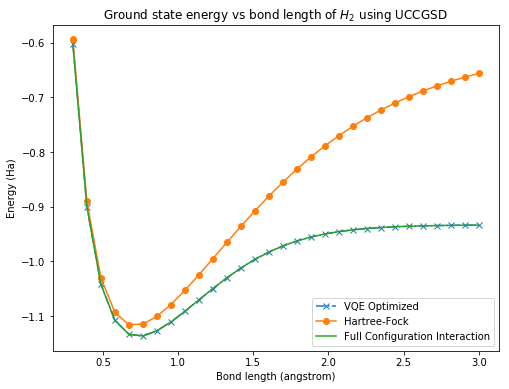

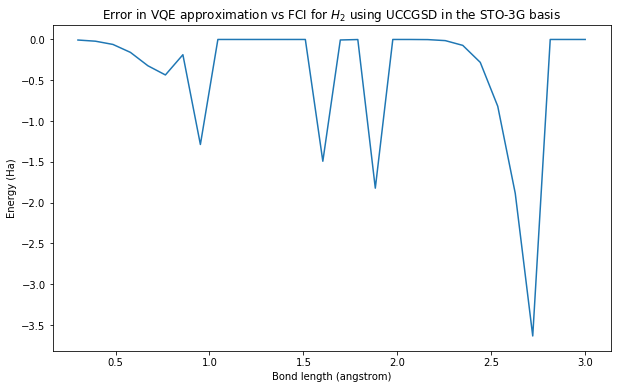

In [109]:
import matplotlib.pyplot as plt

# molecule_name = "LiH"
# ansatz_name = "2-UpCCSD"
# ansatz_name = "Singlet UCCSD"

plt.figure(figsize=(8, 6))

plt.plot(separation, observable, 'x-.', label="VQE Optimized")
# plt.errorbar(x=separation, y=observable, yerr=observable_variance, marker='x', linestyle='')

pyscf_hf_energies = []
pyscf_fci_energies = []

for atomic_separation in separation:  
    molecule = MolecularData_from_specification(molecule_specification, atomic_separation)
    run_pyscf(molecule, run_scf=True, run_fci=True)
    pyscf_hf_energies.append(molecule.hf_energy)
    pyscf_fci_energies.append(molecule.fci_energy)
    
print(pyscf_fci_energies)

plt.plot(separation, pyscf_hf_energies, 'o-', label="Hartree-Fock")
plt.plot(separation, pyscf_fci_energies, linestyle='-', label="Full Configuration Interaction")

plt.title(r"Ground state energy vs bond length of {} using {}".format(molecule_name, ansatz_name))
plt.xlabel("Bond length (angstrom)")
plt.ylabel("Energy (Ha)")
plt.legend()
plt.savefig("{} {}".format(molecule_name, ansatz_name))
plt.show()

# fig, ax = plt.subplots()
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.yaxis.offsetText.set_visible(False)
ax.plot(separation, [pyscf_fci_energies[i] - observable[i] for i in range(len(observable))])
plt.title(r"Error in VQE approximation vs FCI for {} using {} in the STO-3G basis".format(molecule_name, ansatz_name))
plt.xlabel(r"Bond length (angstrom)")
plt.ylabel("Energy (Ha)")
fig.savefig("{} {} error".format(molecule_name, ansatz_name))
plt.show()
